In [1]:
import pandas as pd
import tensorflow as tf
from sklearn import preprocessing
from sklearn.cluster import DBSCAN
from tabulate import tabulate
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split 
import seaborn as sns
import numpy as np
# importing required libraries for normalizing data
from sklearn.preprocessing import StandardScaler,LabelBinarizer,MinMaxScaler
from sklearn.neighbors import NearestNeighbors
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
# representation of model layers
from tensorflow.keras.utils import plot_model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score , classification_report
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
import joblib
from sklearn.svm import SVC
from sklearn.mixture import GaussianMixture
from sklearn.naive_bayes import GaussianNB

2025-04-21 11:01:16.370123: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745233276.612155      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745233276.678109      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# **ĐỌC DỮ LIỆU**

📌 Nhãn Attack: Thêm 234,021 dòng, tổng cộng 234,021 dòng
📌 Nhãn Benign: Thêm 5,645 dòng, tổng cộng 5,645 dòng
📌 File 0: Giữ 239,666 dòng sau khi lọc giới hạn
📌 Nhãn Attack: Thêm 236,587 dòng, tổng cộng 470,608 dòng
📌 Nhãn Benign: Thêm 5,778 dòng, tổng cộng 11,423 dòng
📌 File 1: Giữ 242,365 dòng sau khi lọc giới hạn
📌 Nhãn Attack: Thêm 226,788 dòng, tổng cộng 697,396 dòng
📌 Nhãn Benign: Thêm 5,440 dòng, tổng cộng 16,863 dòng
📌 File 2: Giữ 232,228 dòng sau khi lọc giới hạn
📌 Nhãn Attack: Thêm 217,009 dòng, tổng cộng 914,405 dòng
📌 Nhãn Benign: Thêm 5,416 dòng, tổng cộng 22,279 dòng
📌 File 3: Giữ 222,425 dòng sau khi lọc giới hạn
📌 Nhãn Attack: Thêm 85,595 dòng, tổng cộng 1,000,000 dòng
📌 Nhãn Benign: Thêm 5,394 dòng, tổng cộng 27,673 dòng
📌 File 4: Giữ 90,989 dòng sau khi lọc giới hạn
⚠ Nhãn Attack đã đủ 1,000,000 dòng, không đọc thêm!
📌 Nhãn Benign: Thêm 5,967 dòng, tổng cộng 33,640 dòng
📌 File 5: Giữ 5,967 dòng sau khi lọc giới hạn
⚠ Nhãn Attack đã đủ 1,000,000 dòng, không đọc thêm!
📌 

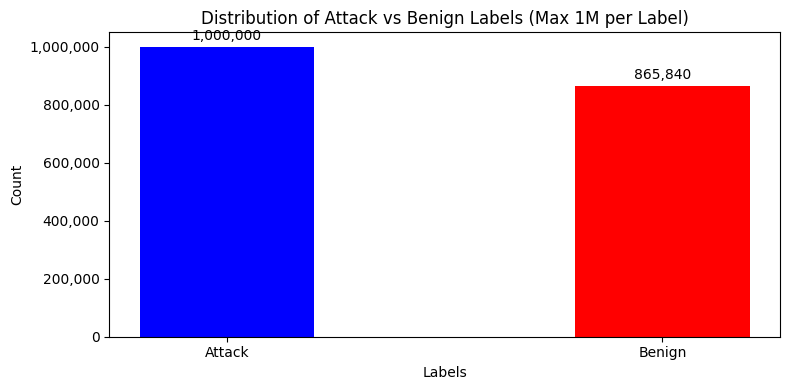

📦 Dữ liệu đã được lưu tại processed_data/data_2labels_1M.csv


In [2]:
import pandas as pd
import os
import glob
import matplotlib.pyplot as plt
import cudf  # Dùng cuDF để xử lý dữ liệu nhanh hơn trên GPU

# Định nghĩa thư mục lưu dữ liệu
output_dir = "processed_data"
os.makedirs(output_dir, exist_ok=True)

# Hàm gộp nhãn thành 2 nhãn: Attack và Benign
def change_label(df):
    attack_labels = {
        'DDoS-ICMP_Flood', 'DDoS-UDP_Flood', 'DDoS-TCP_Flood',
        'DDoS-PSHACK_Flood', 'DDoS-SYN_Flood', 'DDoS-RSTFINFlood',
        'DDoS-SynonymousIP_Flood', 'DDoS-ICMP_Fragmentation',
        'DDoS-UDP_Fragmentation', 'DDoS-ACK_Fragmentation',
        'DDoS-HTTP_Flood', 'DDoS-SlowLoris', 'DoS-UDP_Flood',
        'DoS-TCP_Flood', 'DoS-SYN_Flood', 'DoS-HTTP_Flood',
        'Recon-HostDiscovery', 'Recon-OSScan', 'Recon-PortScan',
        'Recon-PingSweep', 'VulnerabilityScan', 'MITM-ArpSpoofing',
        'DNS_Spoofing', 'DictionaryBruteForce', 'BrowserHijacking',
        'XSS', 'Uploading_Attack', 'SqlInjection', 'CommandInjection',
        'Backdoor_Malware', 'Mirai-greeth_flood', 'Mirai-udpplain',
        'Mirai-greip_flood'
    }

    # Thay thế tất cả nhãn attack thành "Attack"
    df["label"] = df["label"].replace(to_replace=list(attack_labels), value="Attack")
    
    # Thay thế "BenignTraffic" thành "Benign"
    df["label"] = df["label"].replace("BenignTraffic", "Benign")
    return df

# Đọc dữ liệu từ thư mục
data_dir = "/kaggle/input/cic-iot-2023/"
file_list = glob.glob(f"{data_dir}*.csv")[:134]  # Lấy tối đa 100 file

# Giới hạn tối đa 1,000,000 dòng cho mỗi nhãn (Attack và Benign)
MAX_ROWS_PER_LABEL = 1_000_000
label_counts = {"Attack": 0, "Benign": 0}  # Theo dõi số dòng của từng nhãn

def read_file(filename, index):
    try:
        # Đọc file CSV bằng cuDF
        df = cudf.read_csv(filename)
        
        # Kiểm tra cột 'label'
        if 'label' not in df.columns:
            print(f"❌ File {filename}: Không tìm thấy cột 'label'!")
            return None
        
        # Gộp nhãn thành Attack và Benign
        df = change_label(df)
        
        # Lọc dữ liệu dựa trên giới hạn 1M cho mỗi nhãn
        valid_rows = []
        unique_labels = df['label'].unique().to_pandas().tolist()
        for label in unique_labels:
            current_count = label_counts.get(label, 0)
            remaining_quota = MAX_ROWS_PER_LABEL - current_count
            
            if remaining_quota <= 0:
                print(f"⚠ Nhãn {label} đã đủ {MAX_ROWS_PER_LABEL:,} dòng, không đọc thêm!")
                continue
            
            # Lấy các dòng thuộc nhãn này
            label_df = df[df['label'] == label]
            rows_to_take = min(len(label_df), remaining_quota)
            
            if rows_to_take > 0:
                valid_rows.append(label_df[:rows_to_take])
                label_counts[label] = current_count + rows_to_take
                print(f"📌 Nhãn {label}: Thêm {rows_to_take:,} dòng, tổng cộng {label_counts[label]:,} dòng")
        
        # Gộp các dòng hợp lệ
        if valid_rows:
            df_filtered = cudf.concat(valid_rows, ignore_index=True)
            print(f"📌 File {index}: Giữ {df_filtered.shape[0]:,} dòng sau khi lọc giới hạn")
            return df_filtered
        else:
            print(f"⚠ File {index}: Không có dữ liệu nào được giữ lại!")
            return None
    except Exception as e:
        print(f"❌ Lỗi khi đọc file {filename}: {e}")
        return None

# Đọc tuần tự từng file
dfs = []
for idx, fname in enumerate(file_list):
    df = read_file(fname, idx)
    if df is not None:
        dfs.append(df)

# Nối dữ liệu và vẽ biểu đồ
if dfs:
    df_full = cudf.concat(dfs, ignore_index=True)
    print(f"✅ Dữ liệu đã được nối! Kích thước: {df_full.shape}")
    print(f"📋 Nhãn duy nhất: {df_full['label'].unique().to_pandas().tolist()}")
    
    # Chuyển sang pandas để vẽ biểu đồ
    df_pandas = df_full.to_pandas()
    
    # Kiểm tra phân bố nhãn
    print("\n📋 Phân bố nhãn sau khi gộp:")
    print(df_pandas["label"].value_counts())
    
    # Vẽ biểu đồ phân bố nhãn
    fig, ax = plt.subplots(figsize=(8, 4))
    label_counts = df_pandas["label"].value_counts()

    bars = ax.bar(label_counts.index, label_counts.values, width=0.4, color=['blue', 'red'])
    plt.xticks(rotation=0, ha='center', fontsize=10)
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x):,}'))
    ax.set_xlabel('Labels')
    ax.set_ylabel('Count')
    ax.set_title('Distribution of Attack vs Benign Labels (Max 1M per Label)')

    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{int(height):,}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=10)

    plt.tight_layout()
    plt.savefig(f'{output_dir}/label_distribution_2labels_1M.png')  # Lưu biểu đồ
    plt.show()
    
    # Lưu dữ liệu để sử dụng ở các bước sau
    df_pandas.to_csv(f"{output_dir}/data_2labels_1M.csv", index=False)
    print(f"📦 Dữ liệu đã được lưu tại {output_dir}/data_2labels_1M.csv")
else:
    print("⚠ Không có file nào được đọc thành công hoặc tất cả dữ liệu rỗng!")

# **ÁNH XẠ NHÃN**

📋 Nhãn duy nhất trong dữ liệu: ['Attack', 'Benign']
📊 Ánh xạ nhãn (2 nhãn): {'Attack': 0, 'Benign': 1}

📊 Phân bố nhãn trong tập huấn luyện:
Benign    650000
Attack    562796
Name: count, dtype: int64

📊 Phân bố nhãn trong tập validation:
Benign    150000
Attack    129876
Name: count, dtype: int64

📊 Phân bố nhãn trong tập kiểm tra:
Benign    200000
Attack    173168
Name: count, dtype: int64
🔍 Giá trị tối đa và tối thiểu trong X_train_scaled:
            IAT  Weight  Number  rst_count  urg_count  Variance   Tot size  \
min -110.559660 -140.55    -8.5  -0.001763  -0.014347 -0.211111  -0.064690   
max  112.408913  103.05     5.5  16.174396  61.857963  0.900000  36.433962   

           Max  Magnitue        AVG  
min  -0.058294 -0.139120  -0.069065  
max  32.524304  8.450362  34.839941  
🔍 Giá trị tối đa và tối thiểu trong X_val_scaled:
            IAT  Weight  Number  rst_count  urg_count  Variance   Tot size  \
min -110.559660 -140.55    -8.5  -0.001763  -0.014347 -0.211111  -0.064690  

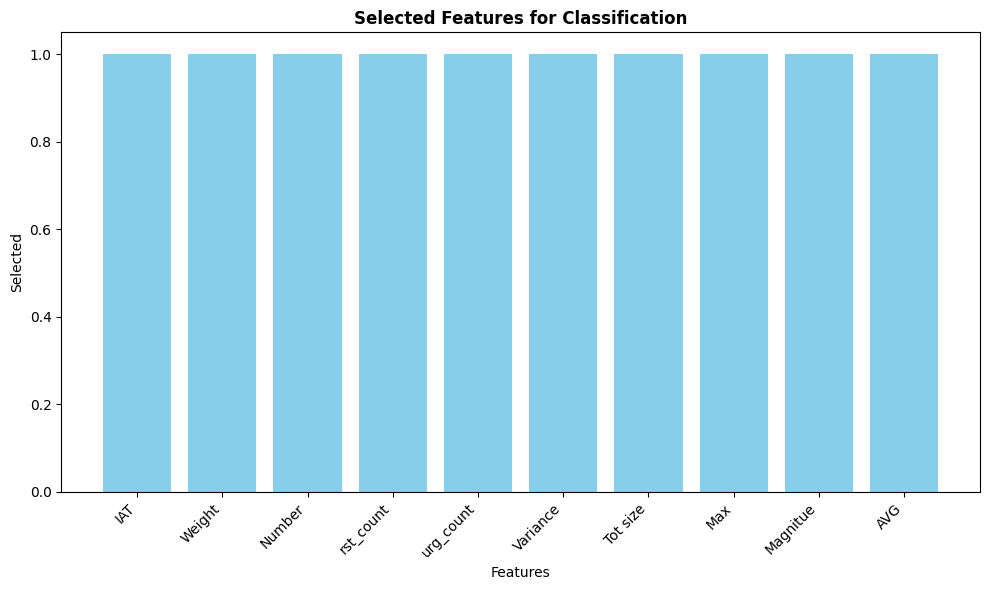

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.impute import KNNImputer
import pickle
import os
import matplotlib.pyplot as plt

# Đường dẫn lưu dữ liệu
output_dir = "processed_data"
os.makedirs(output_dir, exist_ok=True)

# Giả định df_full là DataFrame từ cell đọc dữ liệu trước đó (cuDF)
# Chuyển từ cuDF sang Pandas
df_original = df_full.to_pandas()

# Kiểm tra dữ liệu đầu vào
if df_original.empty or 'label' not in df_original.columns:
    raise ValueError("❌ Dữ liệu đầu vào rỗng hoặc thiếu cột 'label'!")

# Xử lý giá trị thiếu cho cột số
numeric_columns = df_original.select_dtypes(include=[np.number]).columns
df_original[numeric_columns] = df_original[numeric_columns].fillna(df_original[numeric_columns].mean())

# Tách đặc trưng và nhãn
X = df_original.drop(columns=['label']).select_dtypes(include=[np.number])
y = df_original['label']

# Kiểm tra nhãn duy nhất
print("📋 Nhãn duy nhất trong dữ liệu:", y.unique().tolist())

# Sử dụng danh sách đặc trưng cố định
top_features = ['IAT', 'Weight', 'Number', 'rst_count', 'urg_count', 'Variance', 'Tot size', 'Max', 'Magnitue', 'AVG']

# Kiểm tra xem các đặc trưng có tồn tại trong dữ liệu không
missing_features = [f for f in top_features if f not in X.columns]
if missing_features:
    raise ValueError(f"❌ Các đặc trưng sau không tồn tại trong dữ liệu: {missing_features}")

# Lấy chỉ số của các đặc trưng đã chọn
feature_indices = [list(X.columns).index(f) for f in top_features]

# Áp dụng các đặc trưng đã chọn trước khi chia dữ liệu
X = X[top_features]

# Chia dữ liệu thành tập train, val, test
X_temp, X_test, Y_temp, Y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train, X_val, Y_train, Y_val = train_test_split(X_temp, Y_temp, test_size=0.1875, stratify=Y_temp, random_state=42)

# Mã hóa nhãn (2 nhãn: Benign = 0, Attack = 1)
label_encoder = LabelEncoder()
Y_train_encoded = label_encoder.fit_transform(Y_train)
Y_val_encoded = label_encoder.transform(Y_val)
Y_test_encoded = label_encoder.transform(Y_test)
label_mapping = dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))
print("📊 Ánh xạ nhãn (2 nhãn):", label_mapping)

# Kiểm tra phân bố nhãn
print("\n📊 Phân bố nhãn trong tập huấn luyện:")
print(pd.Series(Y_train_encoded).value_counts().rename({0: 'Benign', 1: 'Attack'}))
print("\n📊 Phân bố nhãn trong tập validation:")
print(pd.Series(Y_val_encoded).value_counts().rename({0: 'Benign', 1: 'Attack'}))
print("\n📊 Phân bố nhãn trong tập kiểm tra:")
print(pd.Series(Y_test_encoded).value_counts().rename({0: 'Benign', 1: 'Attack'}))

# Xử lý NaN và outlier bằng KNNImputer
imputer = KNNImputer(n_neighbors=5)
X_train_imputed = imputer.fit_transform(X_train)
X_val_imputed = imputer.transform(X_val)
X_test_imputed = imputer.transform(X_test)

# Chuẩn hóa dữ liệu bằng RobustScaler
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_val_scaled = scaler.transform(X_val_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

# Kiểm tra giá trị sau khi chọn đặc trưng
print("🔍 Giá trị tối đa và tối thiểu trong X_train_scaled:")
print(pd.DataFrame(X_train_scaled, columns=top_features).describe().loc[['min', 'max']])
print("🔍 Giá trị tối đa và tối thiểu trong X_val_scaled:")
print(pd.DataFrame(X_val_scaled, columns=top_features).describe().loc[['min', 'max']])
print("🔍 Giá trị tối đa và tối thiểu trong X_test_scaled:")
print(pd.DataFrame(X_test_scaled, columns=top_features).describe().loc[['min', 'max']])

# Lưu dữ liệu đã xử lý
np.save(f"{output_dir}/X_train_scaled_2labels.npy", X_train_scaled)
np.save(f"{output_dir}/Y_train_encoded_2labels.npy", Y_train_encoded)
np.save(f"{output_dir}/X_val_scaled_2labels.npy", X_val_scaled)
np.save(f"{output_dir}/Y_val_encoded_2labels.npy", Y_val_encoded)
np.save(f"{output_dir}/X_test_scaled_2labels.npy", X_test_scaled)
np.save(f"{output_dir}/Y_test_encoded_2labels.npy", Y_test_encoded)

# Lưu các đối tượng xử lý
with open(f"{output_dir}/label_encoder_2labels.pkl", 'wb') as f:
    pickle.dump(label_encoder, f)
with open(f"{output_dir}/scaler_2labels.pkl", 'wb') as f:
    pickle.dump(scaler, f)
with open(f"{output_dir}/imputer_2labels.pkl", 'wb') as f:
    pickle.dump(imputer, f)
with open(f"{output_dir}/selected_features_2labels.pkl", 'wb') as f:
    pickle.dump(top_features, f)

# In thông tin chi tiết
print(f"✅ Dữ liệu đã xử lý và lưu trong '{output_dir}'!")
print(f"📌 Số đặc trưng được chọn: {len(top_features)}")
print(f"📋 Các đặc trưng được chọn: {top_features}")

# Vẽ biểu đồ danh sách đặc trưng được chọn
plt.figure(figsize=(10, 6))
plt.bar(top_features, [1] * len(top_features), color='skyblue')
plt.title('Selected Features for Classification', fontsize=12, fontweight='bold')
plt.xlabel('Features', fontsize=10)
plt.ylabel('Selected', fontsize=10)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig(f"{output_dir}/selected_features_2labels.png")
plt.show()

# **LẤY SOFT LABLE**

In [4]:
import numpy as np
import xgboost as xgb
import joblib
from sklearn.preprocessing import StandardScaler
import os
from tqdm import tqdm

# Tạo thư mục lưu dữ liệu
output_dir = "processed_data"
results_dir = "results"
os.makedirs(output_dir, exist_ok=True)
os.makedirs(results_dir, exist_ok=True)

# Tải dữ liệu đã xử lý (2 nhãn, 10 đặc trưng)
X_train_scaled = np.load(f"{output_dir}/X_train_scaled_2labels.npy")
Y_train_encoded = np.load(f"{output_dir}/Y_train_encoded_2labels.npy")
X_val_scaled = np.load(f"{output_dir}/X_val_scaled_2labels.npy")
Y_val_encoded = np.load(f"{output_dir}/Y_val_encoded_2labels.npy")
X_test_scaled = np.load(f"{output_dir}/X_test_scaled_2labels.npy")
Y_test_encoded = np.load(f"{output_dir}/Y_test_encoded_2labels.npy")

# Kiểm tra kích thước dữ liệu
print(f"📏 Kích thước X_train_scaled: {X_train_scaled.shape}")
print(f"📏 Kích thước X_val_scaled: {X_val_scaled.shape}")
print(f"📏 Kích thước X_test_scaled: {X_test_scaled.shape}")
print(f"📋 Nhãn duy nhất trong Y_train_encoded: {np.unique(Y_train_encoded)}")

# Chuẩn hóa dữ liệu bằng StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_scaled)
X_val_scaled = scaler.transform(X_val_scaled)
X_test_scaled = scaler.transform(X_test_scaled)
joblib.dump(scaler, f"{results_dir}/xgboost_scaler_2labels.pkl")
tqdm.write(f"📦 Lưu StandardScaler tại {results_dir}/xgboost_scaler_2labels.pkl")

# Thiết lập tham số XGBoost cho phân loại nhị phân
xgb_params = {
    'objective': 'binary:logistic',  # Phân loại nhị phân
    'max_depth': 6,
    'learning_rate': 0.1,
    'n_estimators': 100,  # Giảm số cây để tăng tốc độ
    'eval_metric': 'logloss',
    'random_state': 42
}

# Huấn luyện mô hình XGBoost
tqdm.write("🚀 Bắt đầu huấn luyện XGBoost...")
xgb_model = xgb.XGBClassifier(**xgb_params)
xgb_model.fit(X_train_scaled, Y_train_encoded)

# Lấy soft labels (xác suất)
soft_labels_train = xgb_model.predict_proba(X_train_scaled)
soft_labels_val = xgb_model.predict_proba(X_val_scaled)
soft_labels_test = xgb_model.predict_proba(X_test_scaled)

# Kiểm tra kích thước soft labels
print(f"📏 Kích thước soft_labels_train: {soft_labels_train.shape}")
print(f"📏 Kích thước soft_labels_val: {soft_labels_val.shape}")
print(f"📏 Kích thước soft_labels_test: {soft_labels_test.shape}")

# Lưu mô hình XGBoost
xgb_model.save_model(f"{results_dir}/xgboost_model_2labels.json")
tqdm.write(f"📦 Lưu mô hình XGBoost tại {results_dir}/xgboost_model_2labels.json")

# Lưu soft labels
np.save(f"{results_dir}/soft_labels_train_2labels.npy", soft_labels_train)
np.save(f"{results_dir}/soft_labels_val_2labels.npy", soft_labels_val)
np.save(f"{results_dir}/soft_labels_test_2labels.npy", soft_labels_test)
tqdm.write(f"📦 Lưu soft labels tại {results_dir}/ (soft_labels_train_2labels.npy, soft_labels_val_2labels.npy, soft_labels_test_2labels.npy)")

tqdm.write("✅ Hoàn thành lấy và lưu soft labels từ XGBoost!")

📏 Kích thước X_train_scaled: (1212796, 10)
📏 Kích thước X_val_scaled: (279876, 10)
📏 Kích thước X_test_scaled: (373168, 10)
📋 Nhãn duy nhất trong Y_train_encoded: [0 1]
📦 Lưu StandardScaler tại results/xgboost_scaler_2labels.pkl
🚀 Bắt đầu huấn luyện XGBoost...
📏 Kích thước soft_labels_train: (1212796, 2)
📏 Kích thước soft_labels_val: (279876, 2)
📏 Kích thước soft_labels_test: (373168, 2)
📦 Lưu mô hình XGBoost tại results/xgboost_model_2labels.json
📦 Lưu soft labels tại results/ (soft_labels_train_2labels.npy, soft_labels_val_2labels.npy, soft_labels_test_2labels.npy)
✅ Hoàn thành lấy và lưu soft labels từ XGBoost!


# **MÔ HÌNH DCN-V2  30.86 giây**

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import numpy as np
import time
from tqdm import tqdm
import os

# Tạo thư mục lưu dữ liệu
output_dir = "processed_data"
results_dir = "results"
os.makedirs(output_dir, exist_ok=True)
os.makedirs(results_dir, exist_ok=True)

# Contrastive Loss
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss_positive = torch.mean((1 - label) * torch.pow(euclidean_distance, 2))
        loss_negative = torch.mean(label * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
        return (loss_positive + loss_negative) / 2

# Ghost Batch Normalization
class GhostBN1d(nn.Module):
    def __init__(self, num_features, virtual_batch_size=512):
        super(GhostBN1d, self).__init__()
        self.bn = nn.BatchNorm1d(num_features)
        self.virtual_batch_size = virtual_batch_size

    def forward(self, x):
        batch_size = x.size(0)
        if batch_size <= self.virtual_batch_size:
            return self.bn(x)
        n_splits = batch_size // self.virtual_batch_size
        x_splits = torch.split(x, self.virtual_batch_size, dim=0)
        x_splits = [self.bn(split) for split in x_splits[:n_splits]]
        remaining = batch_size % self.virtual_batch_size
        if remaining > 0:
            x_splits.append(self.bn(x[-remaining:]))
        return torch.cat(x_splits, dim=0)

# DCN-V2 Cross Layer
class CrossLayer(nn.Module):
    def __init__(self, input_dim):
        super(CrossLayer, self).__init__()
        self.weight = nn.Parameter(torch.randn(input_dim, 1))
        self.bias = nn.Parameter(torch.zeros(input_dim))
        nn.init.xavier_normal_(self.weight)
        nn.init.zeros_(self.bias)

    def forward(self, x):
        x0 = x
        xw = torch.matmul(x0, self.weight)
        x = x0 * xw + x0 + self.bias
        return x

# DCN-V2 Model
class DCNV2(nn.Module):
    def __init__(self, input_dim, num_classes, n_cross_layers=3, n_deep_layers=3, deep_layer_dim=128, embed_dim=64):
        super(DCNV2, self).__init__()
        self.input_dim = input_dim
        self.bn = GhostBN1d(input_dim, virtual_batch_size=512)  # Sửa lỗi từ GattorBN1d
        self.cross_layers = nn.ModuleList([CrossLayer(input_dim) for _ in range(n_cross_layers)])
        deep_layers = []
        prev_dim = input_dim
        for _ in range(n_deep_layers):
            deep_layers.extend([
                nn.Linear(prev_dim, deep_layer_dim),
                nn.BatchNorm1d(deep_layer_dim),
                nn.ReLU(),
                nn.Dropout(0.2)
            ])
            prev_dim = deep_layer_dim
        self.deep = nn.Sequential(*deep_layers)
        self.combine_fc_embed = nn.Linear(input_dim + deep_layer_dim, embed_dim)  # Dùng cho Stage 1
        self.combine_fc = nn.Linear(input_dim + deep_layer_dim, num_classes)     # Dùng cho Stage 2
        nn.init.xavier_normal_(self.combine_fc_embed.weight)
        nn.init.xavier_normal_(self.combine_fc.weight)
        nn.init.zeros_(self.combine_fc_embed.bias)
        nn.init.zeros_(self.combine_fc.bias)
        self.importance_layer = nn.Linear(input_dim, input_dim)
        nn.init.xavier_normal_(self.importance_layer.weight)

    def forward(self, x, stage='classification'):
        x = torch.clamp(self.bn(x), -50, 50)
        x_cross = x
        for layer in self.cross_layers:
            x_cross = layer(x_cross)
        x_deep = self.deep(x)
        combined = torch.cat([x_cross, x_deep], dim=1)
        if stage == 'feature_learning':
            output = self.combine_fc_embed(combined)
        else:  # stage == 'classification'
            output = self.combine_fc(combined)
        importance = torch.sigmoid(self.importance_layer(x))
        sparsity_loss = torch.mean(-importance * torch.log(importance + 1e-8))
        masks = [importance]
        return output, sparsity_loss, masks

# Tải dữ liệu (2 nhãn, 10 đặc trưng)
X_train_scaled = np.load(f"{output_dir}/X_train_scaled_2labels.npy")
Y_train_encoded = np.load(f"{output_dir}/Y_train_encoded_2labels.npy")
X_val_scaled = np.load(f"{output_dir}/X_val_scaled_2labels.npy")
Y_val_encoded = np.load(f"{output_dir}/Y_val_encoded_2labels.npy")
X_test_scaled = np.load(f"{output_dir}/X_test_scaled_2labels.npy")
Y_test_encoded = np.load(f"{output_dir}/Y_test_encoded_2labels.npy")

# Tải soft labels từ XGBoost (2 nhãn)
soft_labels_train = np.load(f"{results_dir}/soft_labels_train_2labels.npy")
soft_labels_val = np.load(f"{results_dir}/soft_labels_val_2labels.npy")
soft_labels_test = np.load(f"{results_dir}/soft_labels_test_2labels.npy")
tqdm.write(f"📦 Đã tải soft labels từ {results_dir}/ (soft_labels_train_2labels.npy, soft_labels_val_2labels.npy, soft_labels_test_2labels.npy)")

# Feature Augmentation: Nối xác suất XGBoost vào input
X_train_aug = np.concatenate([X_train_scaled, soft_labels_train], axis=1)
X_val_aug = np.concatenate([X_val_scaled, soft_labels_val], axis=1)
X_test_aug = np.concatenate([X_test_scaled, soft_labels_test], axis=1)

# Kiểm tra kích thước dữ liệu
print(f"📏 Kích thước X_train_aug: {X_train_aug.shape}")
print(f"📏 Kích thước X_val_aug: {X_val_aug.shape}")
print(f"📏 Kích thước X_test_aug: {X_test_aug.shape}")

# Chuyển thành tensor
X_train_tensor = torch.tensor(X_train_aug, dtype=torch.float32)
Y_train_tensor = torch.tensor(Y_train_encoded, dtype=torch.long)
soft_labels_train_tensor = torch.tensor(soft_labels_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val_aug, dtype=torch.float32)
Y_val_tensor = torch.tensor(Y_val_encoded, dtype=torch.long)
soft_labels_val_tensor = torch.tensor(soft_labels_val, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_aug, dtype=torch.float32)
Y_test_tensor = torch.tensor(Y_test_encoded, dtype=torch.long)

# DataLoader
batch_size = 512
train_dataset = TensorDataset(X_train_tensor, Y_train_tensor, soft_labels_train_tensor)
val_dataset = TensorDataset(X_val_tensor, Y_val_tensor, soft_labels_val_tensor)
test_dataset = TensorDataset(X_test_tensor, Y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"📡 Thiết bị: {device}")

# Khởi tạo mô hình và tối ưu hóa
input_dim = X_train_aug.shape[1]  # 10 đặc trưng + 2 soft labels = 12
model = DCNV2(input_dim=input_dim, num_classes=2, n_cross_layers=3, n_deep_layers=3, deep_layer_dim=128, embed_dim=64).to(device)
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2, eta_min=1e-6)
criterion_bce = nn.BCEWithLogitsLoss()  # Dùng cho phân loại nhị phân
criterion_contrast = ContrastiveLoss(margin=1.0)

# Danh sách lưu dữ liệu
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
epoch_times = []

# Two-Stage Training
num_epochs_stage1 = 5
num_epochs_stage2 = 100
distillation_weight = 0.5
temperature = 2.0

# Stage 1: Feature Learning
print("Stage 1: Feature Learning with Contrastive Loss")
for epoch in range(num_epochs_stage1):
    epoch_start_time = time.time()
    model.train()
    running_loss = 0
    with tqdm(train_loader, desc=f"Training Batch (Epoch {epoch+1}/{num_epochs_stage1})", unit="batch", leave=False) as pbar:
        for X_batch, Y_batch, _ in pbar:
            X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
            optimizer.zero_grad()
            idx = torch.randperm(X_batch.size(0))
            X_batch_2 = X_batch[idx]
            Y_batch_2 = Y_batch[idx]
            label = (Y_batch == Y_batch_2).float()
            features, _, _ = model(X_batch, stage='feature_learning')
            features_2, _, _ = model(X_batch_2, stage='feature_learning')
            loss = criterion_contrast(features, features_2, label)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)
            optimizer.step()
            running_loss += loss.item() * X_batch.size(0)
            pbar.set_postfix({"loss": f"{loss.item():.4f}"})
    train_losses.append(running_loss / len(train_loader.dataset))
    train_accuracies.append(0.0)  # Không tính accuracy trong Stage 1
    val_losses.append(0.0)
    val_accuracies.append(0.0)
    epoch_time = time.time() - epoch_start_time
    epoch_times.append(epoch_time)
    tqdm.write(f"✅ Epoch {epoch+1}/{num_epochs_stage1}, Train Loss: {train_losses[-1]:.4f}, Time: {epoch_time:.2f}s")

# Stage 2: Classification with BCE + KL + Sparsity Loss
print("Stage 2: Classification with BCE + KL + Sparsity Loss")
best_f1 = 0
for epoch in range(num_epochs_stage2):
    epoch_start_time = time.time()
    model.train()
    running_loss = 0
    train_preds = []
    train_labels = []
    with tqdm(train_loader, desc=f"Training Batch (Epoch {epoch+1}/{num_epochs_stage2})", unit="batch", leave=False) as pbar:
        for X_batch, Y_batch, soft_labels in pbar:
            X_batch, Y_batch, soft_labels = X_batch.to(device), Y_batch.to(device), soft_labels.to(device)
            optimizer.zero_grad()
            logits, sparsity_loss, masks = model(X_batch, stage='classification')
            # Chuyển Y_batch thành one-hot cho BCEWithLogitsLoss
            Y_batch_onehot = F.one_hot(Y_batch, num_classes=2).float()
            bce_loss = criterion_bce(logits, Y_batch_onehot)
            kl_loss = torch.clamp(F.kl_div(F.log_softmax(logits / temperature, dim=1), soft_labels / temperature, reduction='batchmean', log_target=False), min=0.0)
            loss = bce_loss + distillation_weight * kl_loss + 1e-8 * sparsity_loss
            loss.backward()
            grad_norm = nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)
            optimizer.step()
            running_loss += loss.item()
            train_preds.extend(torch.argmax(logits, dim=1).cpu().numpy())
            train_labels.extend(Y_batch.cpu().numpy())
            pbar.set_postfix({"loss": f"{loss.item():.4f}"})

    train_loss = running_loss / len(train_loader)
    train_acc = accuracy_score(train_labels, train_preds) * 100
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    scheduler.step()

    # Validation
    model.eval()
    running_val_loss = 0
    val_preds = []
    val_labels = []
    with torch.no_grad():
        with tqdm(val_loader, desc=f"Validation (Epoch {epoch+1})", unit="batch", leave=False) as pbar_val:
            for X_batch, Y_batch, soft_labels in pbar_val:
                X_batch, Y_batch, soft_labels = X_batch.to(device), Y_batch.to(device), soft_labels.to(device)
                logits, sparsity_loss, _ = model(X_batch, stage='classification')
                Y_batch_onehot = F.one_hot(Y_batch, num_classes=2).float()
                bce_loss = criterion_bce(logits, Y_batch_onehot)
                kl_loss = torch.clamp(F.kl_div(F.log_softmax(logits / temperature, dim=1), soft_labels / temperature, reduction='batchmean', log_target=False), min=0.0)
                loss = bce_loss + distillation_weight * kl_loss + 1e-8 * sparsity_loss
                running_val_loss += loss.item()
                val_preds.extend(torch.argmax(logits, dim=1).cpu().numpy())
                val_labels.extend(Y_batch.cpu().numpy())
                pbar_val.set_postfix({"val_loss": f"{loss.item():.4f}"})

    val_loss = running_val_loss / len(val_loader)
    val_acc = accuracy_score(val_labels, val_preds) * 100
    f1 = f1_score(val_labels, val_preds, average='weighted')
    precision = precision_score(val_labels, val_preds, average='weighted', zero_division=0)
    recall = recall_score(val_labels, val_preds, average='weighted')
    cm = confusion_matrix(val_labels, val_preds)

    pred_counts = np.bincount(val_preds, minlength=2)  # Chỉ 2 nhãn
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    epoch_time = time.time() - epoch_start_time
    epoch_times.append(epoch_time)

    tqdm.write(f"✅ Epoch {epoch+1}/{num_epochs_stage2}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
              f"Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%, F1: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, Time: {epoch_time:.2f}s")
    tqdm.write(f"Phân bố dự đoán (Validation): {pred_counts}")
    tqdm.write(f"Confusion Matrix:\n{cm}")

    # Lưu mô hình tốt nhất dựa trên F1
    if f1 > best_f1:
        best_f1 = f1
        torch.save(model.state_dict(), f"{results_dir}/dcnv2_2labels.pth")
        tqdm.write(f"📦 Lưu mô hình tốt nhất tại epoch {epoch+1}")

# Lưu mô hình cuối cùng
torch.save(model.state_dict(), f"{results_dir}/dcnv2_2labels_final.pth")
tqdm.write(f"📦 Lưu mô hình cuối cùng tại {results_dir}/dcnv2_2labels_final.pth")

# Lưu dữ liệu
np.save(f"{results_dir}/train_losses_2labels.npy", np.array(train_losses))
np.save(f"{results_dir}/train_accuracies_2labels.npy", np.array(train_accuracies))
np.save(f"{results_dir}/val_losses_2labels.npy", np.array(val_losses))
np.save(f"{results_dir}/val_accuracies_2labels.npy", np.array(val_accuracies))
np.save(f"{results_dir}/epoch_times_2labels.npy", np.array(epoch_times))
total_time = sum(epoch_times)
np.save(f"{results_dir}/total_time_2labels.npy", np.array([total_time]))
tqdm.write(f"📊 Tổng thời gian huấn luyện: {total_time:.2f}s")

# Test trên tập test
model.load_state_dict(torch.load(f"{results_dir}/dcnv2_2labels.pth", weights_only=True))
model.eval()
test_preds = []
test_labels = []
test_features = []
test_probs = []
test_masks = []
with torch.no_grad():
    with tqdm(test_loader, desc="Testing", unit="batch") as pbar_test:
        for X_batch, Y_batch in pbar_test:
            X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
            logits, sparsity_loss, masks = model(X_batch, stage='classification')
            probs = torch.softmax(logits, dim=1)
            test_probs.extend(probs.cpu().numpy())
            test_preds.extend(torch.argmax(logits, dim=1).cpu().numpy())
            test_labels.extend(Y_batch.cpu().numpy())
            test_features.extend(torch.cat([X_batch, logits], dim=1).cpu().numpy())
            if X_batch.size(0) == batch_size:
                test_masks.extend([mask.detach().cpu().numpy() for mask in masks])
            pbar_test.set_postfix({"test_loss": f"{sparsity_loss.item():.4f}"})

pred_counts = np.bincount(test_preds, minlength=2)  # Chỉ 2 nhãn
test_acc = accuracy_score(test_labels, test_preds) * 100
f1 = f1_score(test_labels, test_preds, average='weighted')
precision = precision_score(test_labels, test_preds, average='weighted', zero_division=0)
recall = recall_score(test_labels, test_preds, average='weighted')
cm = confusion_matrix(test_labels, test_preds)

tqdm.write(f"\n📊 Kết quả trên tập test:")
tqdm.write(f"Test Acc: {test_acc:.2f}%, F1: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")
tqdm.write(f"Phân bố dự đoán (Test): {pred_counts}")
tqdm.write(f"Confusion Matrix:\n{cm}")

# Lưu dữ liệu cho biểu đồ
if test_masks:
    shapes = [mask.shape for mask in test_masks]
    if len(set(shapes)) == 1:
        avg_mask = np.mean(np.stack(test_masks, axis=0), axis=(0, 1))
    else:
        tqdm.write(f"Warning: Inconsistent mask shapes: {shapes}")
        avg_mask = np.zeros((batch_size, input_dim))
else:
    avg_mask = np.zeros((batch_size, input_dim))

np.save(f"{results_dir}/confusion_matrix_test_2labels.npy", cm)
np.save(f"{results_dir}/test_probs_2labels.npy", np.array(test_probs))
np.save(f"{results_dir}/test_labels_2labels.npy", np.array(test_labels))
np.save(f"{results_dir}/test_features_2labels.npy", np.array(test_features))
np.save(f"{results_dir}/feature_importance_2labels.npy", avg_mask)

tqdm.write(f"Train Losses shape: {np.array(train_losses).shape}")
tqdm.write(f"Train Accuracies shape: {np.array(train_accuracies).shape}")
tqdm.write(f"Val Losses shape: {np.array(val_losses).shape}")
tqdm.write(f"Val Accuracies shape: {np.array(val_accuracies).shape}")
tqdm.write(f"Epoch Times shape: {np.array(epoch_times).shape}")
tqdm.write(f"Confusion Matrix shape: {cm.shape}")
tqdm.write(f"Test Probs shape: {np.array(test_probs).shape}")
tqdm.write(f"Test Labels shape: {np.array(test_labels).shape}")
tqdm.write(f"Test Features shape: {np.array(test_features).shape}")
tqdm.write(f"Feature Importance shape: {avg_mask.shape}")

**VẼ CÁC SƠ ĐỒ DCN-V2**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, roc_auc_score, roc_curve
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

# Thư mục lưu dữ liệu
results_dir = "results"

# Tải dữ liệu
train_losses = np.load(f"{results_dir}/train_losses_2labels.npy")
val_losses = np.load(f"{results_dir}/val_losses_2labels.npy")
train_accuracies = np.load(f"{results_dir}/train_accuracies_2labels.npy")
val_accuracies = np.load(f"{results_dir}/val_accuracies_2labels.npy")
epoch_times = np.load(f"{results_dir}/epoch_times_2labels.npy")
test_labels = np.load(f"{results_dir}/test_labels_2labels.npy")
test_probs = np.load(f"{results_dir}/test_probs_2labels.npy")
test_features = np.load(f"{results_dir}/test_features_2labels.npy")
cm = np.load(f"{results_dir}/confusion_matrix_test_2labels.npy")
feature_importance = np.load(f"{results_dir}/feature_importance_2labels.npy")
epochs = np.arange(len(train_losses))

# Ánh xạ nhãn cho bài toán 2 nhãn
label_map = {0: 'Attack', 1: 'Benign'}
class_names = [label_map[i] for i in range(len(label_map))]

# 1️⃣ Loss (Thu hẹp trục y, phân biệt hai đường rõ hơn)
plt.figure(figsize=(12, 6))
plt.plot(epochs, train_losses, label="Train Loss", linestyle="-", color="red", marker='o', markersize=6, linewidth=2)
plt.plot(epochs, val_losses, label="Val Loss", linestyle="--", color="green", marker='s', markersize=6, linewidth=2)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train & Validation Loss (Enhanced View)")
plt.legend()
plt.grid(True, which="both", linestyle="--", alpha=0.7)  # Thêm lưới chính và phụ
# Thu hẹp trục y để phóng to vùng dao động
plt.ylim(0.015, 0.040)  # Loss dao động từ 0.0168 đến 0.0371
plt.minorticks_on()  # Bật lưới phụ
plt.tight_layout()
plt.savefig(f"{results_dir}/loss_plot_2labels_enhanced.png")
plt.show()

# 2️⃣ Accuracy (Thu hẹp trục y, phân biệt hai đường rõ hơn)
plt.figure(figsize=(12, 6))
plt.plot(epochs, train_accuracies, label="Train Accuracy", linestyle="-", color="red", marker='o', markersize=6, linewidth=2)
plt.plot(epochs, val_accuracies, label="Val Accuracy", linestyle="--", color="green", marker='s', markersize=6, linewidth=2)
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Train & Validation Accuracy (Enhanced View)")
plt.legend()
plt.grid(True, which="both", linestyle="--", alpha=0.7)  # Thêm lưới chính và phụ
# Thu hẹp trục y để phóng to vùng dao động
plt.ylim(99.2, 99.6)  # Accuracy dao động từ 99.27% đến 99.59%
plt.minorticks_on()  # Bật lưới phụ
plt.tight_layout()
plt.savefig(f"{results_dir}/accuracy_plot_2labels_enhanced.png")
plt.show()

# 3️⃣ Confusion Matrix
fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap="Blues", values_format="d", ax=ax, colorbar=True)
plt.title("Confusion Matrix (Test)")
plt.grid(False)
plt.tight_layout()
plt.savefig(f"{results_dir}/confusion_matrix_2labels.png")
plt.show()

# 4️⃣ ROC-AUC
fpr, tpr, _ = roc_curve(test_labels, test_probs[:, 1])  # Xác suất của nhãn 1 (Benign)
roc_auc = roc_auc_score(test_labels, test_probs[:, 1])

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.4f})", color="darkorange")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Attack vs Benign)")
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig(f"{results_dir}/roc_curve_2labels.png")
plt.show()
print(f"📈 ROC-AUC Score (Attack vs Benign): {roc_auc:.4f}")

# 5️⃣ PCA 3D
pca = PCA(n_components=3)
pca_result = pca.fit_transform(test_features)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Tách dữ liệu theo nhãn để vẽ riêng và gán nhãn trong chú thích
for label in np.unique(test_labels):
    idx = test_labels == label
    ax.scatter(pca_result[idx, 0], pca_result[idx, 1], pca_result[idx, 2], 
               label=label_map[label], alpha=0.7)

ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.set_title("PCA 3D Visualization (Attack vs Benign)")
ax.legend(title="Classes")
plt.tight_layout()
plt.savefig(f"{results_dir}/pca_3d_2labels.png")
plt.show()

# # 6️⃣ t-SNE 3D
# tsne = TSNE(n_components=3, perplexity=30, n_iter=1000, random_state=42)
# tsne_result = tsne.fit_transform(test_features)

# fig = plt.figure(figsize=(10, 8))
# ax = fig.add_subplot(111, projection='3d')

# # Tách dữ liệu theo nhãn để vẽ riêng và gán nhãn trong chú thích
# for label in np.unique(test_labels):
#     idx = test_labels == label
#     ax.scatter(tsne_result[idx, 0], tsne_result[idx, 1], tsne_result[idx, 2], 
#                label=label_map[label], alpha=0.7)

# ax.set_xlabel("t-SNE1")
# ax.set_ylabel("t-SNE2")
# ax.set_zlabel("t-SNE3")
# ax.set_title("t-SNE 3D Visualization (Attack vs Benign)")
# ax.legend(title="Classes")
# plt.tight_layout()
# plt.savefig(f"{results_dir}/tsne_3d_2labels.png")
# plt.show()

# # 7️⃣ Feature Importance
# plt.figure(figsize=(10, 5))
# plt.bar(range(len(feature_importance[0])), feature_importance[0], color='tab:purple')
# plt.xlabel("Feature Index")
# plt.ylabel("Importance Score")
# plt.title("Feature Importance")
# plt.grid(True, axis='y')
# plt.tight_layout()
# plt.savefig(f"{results_dir}/feature_importance_2labels.png")
# plt.show()

# 8️⃣ Thời gian huấn luyện trung bình
avg_time = np.mean(epoch_times)
print(f"⏱️ Thời gian huấn luyện trung bình mỗi epoch: {avg_time:.2f} giây")

**TEST FILE THỰC TẾ**

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder
import joblib
import xgboost as xgb
import pickle
import os
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix

# Các lớp mô hình từ code huấn luyện
class GhostBN1d(nn.Module):
    def __init__(self, num_features, virtual_batch_size=512):
        super(GhostBN1d, self).__init__()
        self.bn = nn.BatchNorm1d(num_features)
        self.virtual_batch_size = virtual_batch_size

    def forward(self, x):
        batch_size = x.size(0)
        if batch_size <= self.virtual_batch_size:
            return self.bn(x)
        n_splits = batch_size // self.virtual_batch_size
        x_splits = torch.split(x, self.virtual_batch_size, dim=0)
        x_splits = [self.bn(split) for split in x_splits[:n_splits]]
        remaining = batch_size % self.virtual_batch_size
        if remaining > 0:
            x_splits.append(self.bn(x[-remaining:]))
        return torch.cat(x_splits, dim=0)

class CrossLayer(nn.Module):
    def __init__(self, input_dim):
        super(CrossLayer, self).__init__()
        self.weight = nn.Parameter(torch.randn(input_dim, 1))
        self.bias = nn.Parameter(torch.zeros(input_dim))
        nn.init.xavier_normal_(self.weight)
        nn.init.zeros_(self.bias)

    def forward(self, x):
        x0 = x
        xw = torch.matmul(x0, self.weight)
        x = x0 * xw + x0 + self.bias
        return x

class DCNV2(nn.Module):
    def __init__(self, input_dim, num_classes, n_cross_layers=3, n_deep_layers=3, deep_layer_dim=128, embed_dim=64):
        super(DCNV2, self).__init__()
        self.input_dim = input_dim
        self.bn = GhostBN1d(input_dim, virtual_batch_size=512)
        self.cross_layers = nn.ModuleList([CrossLayer(input_dim) for _ in range(n_cross_layers)])
        deep_layers = []
        prev_dim = input_dim
        for _ in range(n_deep_layers):
            deep_layers.extend([
                nn.Linear(prev_dim, deep_layer_dim),
                nn.BatchNorm1d(deep_layer_dim),
                nn.ReLU(),
                nn.Dropout(0.2)
            ])
            prev_dim = deep_layer_dim
        self.deep = nn.Sequential(*deep_layers)
        self.combine_fc_embed = nn.Linear(input_dim + deep_layer_dim, embed_dim)
        self.combine_fc = nn.Linear(input_dim + deep_layer_dim, num_classes)
        nn.init.xavier_normal_(self.combine_fc_embed.weight)
        nn.init.xavier_normal_(self.combine_fc.weight)
        nn.init.zeros_(self.combine_fc_embed.bias)
        nn.init.zeros_(self.combine_fc.bias)
        self.importance_layer = nn.Linear(input_dim, input_dim)
        nn.init.xavier_normal_(self.importance_layer.weight)

    def forward(self, x, stage='classification'):
        x = torch.clamp(self.bn(x), -50, 50)
        x_cross = x
        for layer in self.cross_layers:
            x_cross = layer(x_cross)
        x_deep = self.deep(x)
        combined = torch.cat([x_cross, x_deep], dim=1)
        if stage == 'feature_learning':
            output = self.combine_fc_embed(combined)
        else:
            output = self.combine_fc(combined)
        importance = torch.sigmoid(self.importance_layer(x))
        sparsity_loss = torch.mean(-importance * torch.log(importance + 1e-8))
        masks = [importance]
        return output, sparsity_loss, masks

# Hàm ánh xạ nhãn thành 2 nhãn: Attack và Benign
def change_label(df):
    attack_labels = {
        'DDoS-ICMP_Flood', 'DDoS-UDP_Flood', 'DDoS-TCP_Flood',
        'DDoS-PSHACK_Flood', 'DDoS-SYN_Flood', 'DDoS-RSTFINFlood',
        'DDoS-SynonymousIP_Flood', 'DDoS-ICMP_Fragmentation',
        'DDoS-UDP_Fragmentation', 'DDoS-ACK_Fragmentation',
        'DDoS-HTTP_Flood', 'DDoS-SlowLoris', 'DoS-UDP_Flood',
        'DoS-TCP_Flood', 'DoS-SYN_Flood', 'DoS-HTTP_Flood',
        'Recon-HostDiscovery', 'Recon-OSScan', 'Recon-PortScan',
        'Recon-PingSweep', 'VulnerabilityScan', 'MITM-ArpSpoofing',
        'DNS_Spoofing', 'DictionaryBruteForce', 'BrowserHijacking',
        'XSS', 'Uploading_Attack', 'SqlInjection', 'CommandInjection',
        'Backdoor_Malware', 'Mirai-greeth_flood', 'Mirai-udpplain',
        'Mirai-greip_flood'
    }
    df["label"] = df["label"].replace(to_replace=list(attack_labels), value="Attack")
    df["label"] = df["label"].replace("BenignTraffic", "Benign")
    return df

# Hàm xử lý dữ liệu thực tế
def preprocess_real_data(file_path, selected_features, imputer, scaler, xgb_model, xgb_scaler, label_encoder):
    try:
        # Đọc dữ liệu thực tế
        df_real = pd.read_csv(file_path)
        tqdm.write(f"📂 Đã đọc dữ liệu thực tế từ {file_path}, shape: {df_real.shape}")

        # Ánh xạ nhãn
        if 'label' in df_real.columns:
            df_real = change_label(df_real)
            tqdm.write("✅ Đã ánh xạ nhãn thành Attack và Benign")

        # Xử lý giá trị thiếu cho cột số
        numeric_columns = df_real.select_dtypes(include=[np.number]).columns
        df_real[numeric_columns] = df_real[numeric_columns].fillna(df_real[numeric_columns].mean())

        # Kiểm tra xem các đặc trưng đã chọn có trong dữ liệu không
        missing_features = [f for f in selected_features if f not in df_real.columns]
        if missing_features:
            raise ValueError(f"Các đặc trưng sau không có trong dữ liệu: {missing_features}")

        # Chỉ lấy các đặc trưng đã chọn
        X_real = df_real[selected_features]
        tqdm.write(f"📋 Sử dụng {len(selected_features)} đặc trưng: {selected_features}")

        # Xử lý NaN bằng KNNImputer
        X_real_imputed = imputer.transform(X_real)
        tqdm.write("✅ Đã xử lý giá trị thiếu bằng KNNImputer")

        # Chuẩn hóa dữ liệu bằng RobustScaler
        X_real_scaled = scaler.transform(X_real_imputed)
        tqdm.write("✅ Đã chuẩn hóa dữ liệu bằng RobustScaler")

        # Chuẩn hóa cho XGBoost
        X_real_xgb_scaled = xgb_scaler.transform(X_real_scaled)
        tqdm.write("✅ Đã chuẩn hóa dữ liệu cho XGBoost bằng StandardScaler")

        # Lấy soft labels từ XGBoost
        soft_labels_real = xgb_model.predict_proba(X_real_xgb_scaled)
        tqdm.write("✅ Đã tạo soft labels từ XGBoost")

        # Nối soft labels vào dữ liệu
        X_real_aug = np.concatenate([X_real_scaled, soft_labels_real], axis=1)
        tqdm.write(f"📊 Dữ liệu sau khi nối soft labels, shape: {X_real_aug.shape}")

        # Chuyển thành tensor
        X_real_tensor = torch.tensor(X_real_aug, dtype=torch.float32)

        # Nếu có nhãn trong dữ liệu thực tế, mã hóa nhãn
        Y_real_tensor = None
        if 'label' in df_real.columns:
            unique_labels = df_real['label'].unique()
            unknown_labels = [label for label in unique_labels if label not in label_encoder.classes_]
            if unknown_labels:
                raise ValueError(f"Nhãn chưa được ánh xạ đúng hoặc không có trong LabelEncoder: {unknown_labels}")
            Y_real_encoded = label_encoder.transform(df_real['label'])
            Y_real_tensor = torch.tensor(Y_real_encoded, dtype=torch.long)
            tqdm.write("✅ Đã mã hóa nhãn thực tế")

        return X_real_tensor, Y_real_tensor, soft_labels_real

    except Exception as e:
        tqdm.write(f"❌ Lỗi trong preprocess_real_data: {str(e)}")
        raise

# Hàm dự đoán
def predict(model, X_tensor, device, batch_size=512):
    try:
        model.eval()
        predictions = []
        probabilities = []

        # Tạo DataLoader
        dataset = TensorDataset(X_tensor)
        loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

        with torch.no_grad():
            for X_batch in tqdm(loader, desc="Predicting", unit="batch"):
                X_batch = X_batch[0].to(device)
                outputs, _, _ = model(X_batch, stage='classification')
                probs = torch.softmax(outputs, dim=1)
                preds = torch.argmax(probs, dim=1)
                predictions.extend(preds.cpu().numpy())
                probabilities.extend(probs.cpu().numpy())

        return np.array(predictions), np.array(probabilities)

    except Exception as e:
        tqdm.write(f"❌ Lỗi trong predict: {str(e)}")
        raise

# Main
def main():
    # Đường dẫn đến file dữ liệu thực tế
    real_data_path = "/kaggle/input/cic-iot-2023/part-00024-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv"
    output_dir = "processed_data"
    results_dir = "results"
    model_path = f"{results_dir}/dcnv2_2labels.pth"
    output_csv_path = f"{results_dir}/predictions_real_data_2labels.csv"

    # Device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    tqdm.write(f"📡 Thiết bị: {device}")

    try:
        # Tải các đối tượng xử lý
        with open(f"{output_dir}/imputer_2labels.pkl", 'rb') as f:
            imputer = pickle.load(f)
        with open(f"{output_dir}/scaler_2labels.pkl", 'rb') as f:
            scaler = pickle.load(f)
        with open(f"{output_dir}/label_encoder_2labels.pkl", 'rb') as f:
            label_encoder = pickle.load(f)
        with open(f"{output_dir}/selected_features_2labels.pkl", 'rb') as f:
            selected_features = pickle.load(f)
        xgb_scaler = joblib.load(f"{results_dir}/xgboost_scaler_2labels.pkl")

        # Tải mô hình XGBoost
        xgb_model = xgb.XGBClassifier()
        xgb_model.load_model(f"{results_dir}/xgboost_model_2labels.json")
        tqdm.write(f"✅ Đã tải mô hình XGBoost từ {results_dir}/xgboost_model_2labels.json")

        # Tải và xử lý dữ liệu thực tế
        X_real_tensor, Y_real_tensor, soft_labels_real = preprocess_real_data(
            real_data_path, selected_features, imputer, scaler, xgb_model, xgb_scaler, label_encoder
        )

        # Khởi tạo mô hình
        model = DCNV2(input_dim=12, num_classes=2, n_cross_layers=3, n_deep_layers=3, deep_layer_dim=128, embed_dim=64).to(device)
        model.load_state_dict(torch.load(model_path, weights_only=True))
        tqdm.write(f"✅ Đã tải mô hình từ {model_path}")

        # Dự đoán
        predictions, probabilities = predict(model, X_real_tensor, device)
        tqdm.write(f"✅ Hoàn thành dự đoán, shape dự đoán: {predictions.shape}, shape xác suất: {probabilities.shape}")

        # Chuyển ngược dự đoán thành nhãn gốc
        predicted_labels = label_encoder.inverse_transform(predictions)

        # Lưu kết quả
        df_real = pd.read_csv(real_data_path)
        df_real = change_label(df_real)  # Ánh xạ nhãn cho True_Label
        result_df = pd.DataFrame({
            'Index': df_real.index,
            'Predicted_Label': predicted_labels,
            'True_Label': df_real['label'] if 'label' in df_real.columns else None
        })
        for i, class_name in enumerate(label_encoder.classes_):
            result_df[f'Prob_{class_name}'] = probabilities[:, i]

        result_df.to_csv(output_csv_path, index=False)
        tqdm.write(f"📦 Đã lưu kết quả dự đoán tại {output_csv_path}")

        # Nếu có nhãn thực tế, đánh giá hiệu suất
        if Y_real_tensor is not None:
            true_labels = Y_real_tensor.numpy()
            acc = accuracy_score(true_labels, predictions) * 100
            f1 = f1_score(true_labels, predictions, average='weighted')
            precision = precision_score(true_labels, predictions, average='weighted', zero_division=0)
            recall = recall_score(true_labels, predictions, average='weighted')
            cm = confusion_matrix(true_labels, predictions)

            tqdm.write(f"\n📊 Kết quả trên dữ liệu thực tế:")
            tqdm.write(f"Accuracy: {acc:.2f}%")
            tqdm.write(f"F1 Score: {f1:.4f}")
            tqdm.write(f"Precision: {precision:.4f}")
            tqdm.write(f"Recall: {recall:.4f}")
            tqdm.write(f"Confusion Matrix:\n{cm}")

    except Exception as e:
        tqdm.write(f"❌ Lỗi trong main: {str(e)}")
        raise

if __name__ == "__main__":
    main()

# **MÔ HÌNH TABNET 47.95 giây**

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import numpy as np
import time
from tqdm import tqdm
import os

# Tạo thư mục lưu dữ liệu
output_dir = "processed_data"
results_dir = "results"
os.makedirs(output_dir, exist_ok=True)
os.makedirs(results_dir, exist_ok=True)

# Contrastive Loss
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss_positive = torch.mean((1 - label) * torch.pow(euclidean_distance, 2))
        loss_negative = torch.mean(label * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
        return (loss_positive + loss_negative) / 2

# Entmax
def entmax15(x, dim=-1):
    x = F.softmax(x * 1.5, dim=dim)
    return x

# Ghost Batch Normalization
class GhostBN1d(nn.Module):
    def __init__(self, num_features, virtual_batch_size=512):
        super(GhostBN1d, self).__init__()
        self.bn = nn.BatchNorm1d(num_features)
        self.virtual_batch_size = virtual_batch_size

    def forward(self, x):
        batch_size = x.size(0)
        if batch_size <= self.virtual_batch_size:
            return self.bn(x)
        n_splits = batch_size // self.virtual_batch_size
        x_splits = torch.split(x, self.virtual_batch_size, dim=0)
        x_splits = [self.bn(split) for split in x_splits[:n_splits]]
        remaining = batch_size % self.virtual_batch_size
        if remaining > 0:
            x_splits.append(self.bn(x[-remaining:]))
        return torch.cat(x_splits, dim=0)

# TabNet thuần túy
class TabNet(nn.Module):
    def __init__(self, input_dim, num_classes, n_d=64, n_a=64, n_steps=5, gamma=1.3, lambda_sparse=1e-8):
        super(TabNet, self).__init__()
        self.input_dim = input_dim
        self.num_classes = num_classes
        self.n_d = n_d
        self.n_a = n_a
        self.n_steps = n_steps
        self.gamma = gamma
        self.lambda_sparse = lambda_sparse

        # BatchNorm đầu vào
        self.bn = GhostBN1d(input_dim, virtual_batch_size=512)

        # Lớp FC ban đầu
        self.initial_fc = nn.Linear(input_dim, n_d + n_a)
        nn.init.xavier_normal_(self.initial_fc.weight)
        nn.init.zeros_(self.initial_fc.bias)

        # Các lớp chú ý (attention) và quyết định (decision) cho từng bước
        self.attention_layers = nn.ModuleList([
            nn.Sequential(
                nn.Linear(n_a, input_dim),
                nn.BatchNorm1d(input_dim),
                nn.ReLU()
            ) for _ in range(n_steps)
        ])
        self.decision_layers = nn.ModuleList([
            nn.Sequential(
                nn.Linear(input_dim, n_d),
                nn.BatchNorm1d(n_d),
                nn.ReLU(),
                nn.Dropout(0.2)
            ) for _ in range(n_steps)
        ])

        # Lớp cuối để tạo embedding (Stage 1) hoặc logits (Stage 2)
        self.fc_embed = nn.Linear(n_d * n_steps, n_d)  # Dùng trong Stage 1
        self.fc_output = nn.Linear(n_d * n_steps, num_classes)  # Dùng trong Stage 2
        nn.init.xavier_normal_(self.fc_embed.weight)
        nn.init.xavier_normal_(self.fc_output.weight)
        nn.init.zeros_(self.fc_embed.bias)
        nn.init.zeros_(self.fc_output.bias)

    def forward(self, x, stage='classification'):
        x = torch.clamp(self.bn(x), -50, 50)
        prior = torch.ones_like(x)
        outputs = []
        sparsity_loss = 0
        masks = []

        for step in range(self.n_steps):
            # Tạo đặc trưng chú ý và quyết định
            att = self.initial_fc(x)
            att_d, att_a = att[:, :self.n_d], att[:, self.n_d:]
            mask = self.attention_layers[step](att_a)
            mask = entmax15(mask, dim=1)
            
            # Tính sparsity loss
            entropy = -torch.sum(mask * torch.log(mask + 1e-8), dim=1)
            sparsity_loss += torch.mean(entropy) / self.n_steps / self.input_dim
            masks.append(mask)

            # Cập nhật prior và áp dụng mask
            prior = prior * (self.gamma - mask)
            masked_x = x * mask

            # Tạo đầu ra quyết định
            out = self.decision_layers[step](masked_x)
            outputs.append(out)

        # Kết hợp đầu ra từ tất cả các bước
        combined = torch.cat(outputs, dim=1)  # [batch_size, n_d * n_steps]

        # Tạo embedding (Stage 1) hoặc logits (Stage 2)
        if stage == 'feature_learning':
            output = self.fc_embed(combined)
        else:  # stage == 'classification'
            output = self.fc_output(combined)

        return output, sparsity_loss, masks

# Tải dữ liệu (2 nhãn, 10 đặc trưng)
try:
    X_train_scaled = np.load(f"{output_dir}/X_train_scaled_2labels.npy")
    Y_train_encoded = np.load(f"{output_dir}/Y_train_encoded_2labels.npy")
    X_val_scaled = np.load(f"{output_dir}/X_val_scaled_2labels.npy")
    Y_val_encoded = np.load(f"{output_dir}/Y_val_encoded_2labels.npy")
    X_test_scaled = np.load(f"{output_dir}/X_test_scaled_2labels.npy")
    Y_test_encoded = np.load(f"{output_dir}/Y_test_encoded_2labels.npy")
    tqdm.write("✅ Đã tải dữ liệu scaled và nhãn")
except Exception as e:
    tqdm.write(f"❌ Lỗi khi tải dữ liệu: {str(e)}")
    raise

# Tải soft labels từ XGBoost (2 nhãn)
try:
    soft_labels_train = np.load(f"{results_dir}/soft_labels_train_2labels.npy")
    soft_labels_val = np.load(f"{results_dir}/soft_labels_val_2labels.npy")
    soft_labels_test = np.load(f"{results_dir}/soft_labels_test_2labels.npy")
    tqdm.write(f"✅ Đã tải soft labels từ {results_dir}")
except Exception as e:
    tqdm.write(f"❌ Lỗi khi tải soft labels: {str(e)}")
    raise

# Kiểm tra kích thước soft labels
if soft_labels_train.shape[0] != X_train_scaled.shape[0]:
    raise ValueError(f"Kích thước soft_labels_train ({soft_labels_train.shape[0]}) không khớp với X_train_scaled ({X_train_scaled.shape[0]})")
if soft_labels_val.shape[0] != X_val_scaled.shape[0]:
    raise ValueError(f"Kích thước soft_labels_val ({soft_labels_val.shape[0]}) không khớp với X_val_scaled ({X_val_scaled.shape[0]})")
if soft_labels_test.shape[0] != X_test_scaled.shape[0]:
    raise ValueError(f"Kích thước soft_labels_test ({soft_labels_test.shape[0]}) không khớp với X_test_scaled ({X_test_scaled.shape[0]})")

# Feature Augmentation: Nối soft labels vào input
X_train_aug = np.concatenate([X_train_scaled, soft_labels_train], axis=1)
X_val_aug = np.concatenate([X_val_scaled, soft_labels_val], axis=1)
X_test_aug = np.concatenate([X_test_scaled, soft_labels_test], axis=1)
tqdm.write(f"✅ Đã nối soft labels, shape: train {X_train_aug.shape}, val {X_val_aug.shape}, test {X_test_aug.shape}")

# Chuyển thành tensor
X_train_tensor = torch.tensor(X_train_aug, dtype=torch.float32)
Y_train_tensor = torch.tensor(Y_train_encoded, dtype=torch.long)
soft_labels_train_tensor = torch.tensor(soft_labels_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val_aug, dtype=torch.float32)
Y_val_tensor = torch.tensor(Y_val_encoded, dtype=torch.long)
soft_labels_val_tensor = torch.tensor(soft_labels_val, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_aug, dtype=torch.float32)
Y_test_tensor = torch.tensor(Y_test_encoded, dtype=torch.long)

# DataLoader
batch_size = 512
train_dataset = TensorDataset(X_train_tensor, Y_train_tensor, soft_labels_train_tensor)
val_dataset = TensorDataset(X_val_tensor, Y_val_tensor, soft_labels_val_tensor)
test_dataset = TensorDataset(X_test_tensor, Y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tqdm.write(f"📡 Thiết bị: {device}")

# Khởi tạo mô hình và tối ưu hóa
input_dim = X_train_aug.shape[1]  # 10 đặc trưng + 2 soft labels = 12
model = TabNet(input_dim=input_dim, num_classes=2, n_d=64, n_a=64, n_steps=5).to(device)
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2, eta_min=1e-6)
criterion_bce = nn.BCEWithLogitsLoss()  # Dùng cho phân loại nhị phân
criterion_contrast = ContrastiveLoss(margin=1.0)

# Danh sách lưu dữ liệu
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
epoch_times = []

# Two-Stage Training
num_epochs_stage1 = 5
num_epochs_stage2 = 100
distillation_weight = 0.5
temperature = 2.0

# Stage 1: Feature Learning
tqdm.write("Stage 1: Feature Learning with Contrastive Loss")
for epoch in range(num_epochs_stage1):
    epoch_start_time = time.time()
    model.train()
    running_loss = 0
    with tqdm(train_loader, desc=f"Training Batch (Epoch {epoch+1}/{num_epochs_stage1})", unit="batch", leave=False) as pbar:
        for X_batch, Y_batch, _ in pbar:
            X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
            optimizer.zero_grad()
            idx = torch.randperm(X_batch.size(0))
            X_batch_2 = X_batch[idx]
            Y_batch_2 = Y_batch[idx]
            label = (Y_batch == Y_batch_2).float()
            features, _, _ = model(X_batch, stage='feature_learning')
            features_2, _, _ = model(X_batch_2, stage='feature_learning')
            loss = criterion_contrast(features, features_2, label)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)
            optimizer.step()
            running_loss += loss.item() * X_batch.size(0)
            pbar.set_postfix({"loss": f"{loss.item():.4f}"})
    train_losses.append(running_loss / len(train_loader.dataset))
    train_accuracies.append(0.0)  # Không tính accuracy trong Stage 1
    val_losses.append(0.0)
    val_accuracies.append(0.0)
    epoch_time = time.time() - epoch_start_time
    epoch_times.append(epoch_time)
    tqdm.write(f"✅ Epoch {epoch+1}/{num_epochs_stage1}, Train Loss: {train_losses[-1]:.4f}, Time: {epoch_time:.2f}s")

# Stage 2: Classification with BCE + KL + Sparsity Loss
tqdm.write("Stage 2: Classification with BCE + KL + Sparsity Loss")
best_f1 = 0
for epoch in range(num_epochs_stage2):
    epoch_start_time = time.time()
    model.train()
    running_loss = 0
    train_preds = []
    train_labels = []
    with tqdm(train_loader, desc=f"Training Batch (Epoch {epoch+1}/{num_epochs_stage2})", unit="batch", leave=False) as pbar:
        for X_batch, Y_batch, soft_labels in pbar:
            X_batch, Y_batch, soft_labels = X_batch.to(device), Y_batch.to(device), soft_labels.to(device)
            optimizer.zero_grad()
            outputs, sparsity_loss, masks = model(X_batch, stage='classification')
            # Chuyển Y_batch thành one-hot cho BCEWithLogitsLoss
            Y_batch_onehot = F.one_hot(Y_batch, num_classes=2).float()
            bce_loss = criterion_bce(outputs, Y_batch_onehot)
            kl_loss = torch.clamp(F.kl_div(F.log_softmax(outputs / temperature, dim=1), soft_labels / temperature, reduction='batchmean', log_target=False), min=0.0)
            loss = bce_loss + distillation_weight * kl_loss + model.lambda_sparse * sparsity_loss
            loss.backward()
            grad_norm = nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)
            optimizer.step()
            running_loss += loss.item()
            train_preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            train_labels.extend(Y_batch.cpu().numpy())
            pbar.set_postfix({"loss": f"{loss.item():.4f}"})

    train_loss = running_loss / len(train_loader)
    train_acc = accuracy_score(train_labels, train_preds) * 100
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    scheduler.step()

    # Validation
    model.eval()
    running_val_loss = 0
    val_preds = []
    val_labels = []
    with torch.no_grad():
        with tqdm(val_loader, desc=f"Validation (Epoch {epoch+1})", unit="batch", leave=False) as pbar_val:
            for X_batch, Y_batch, soft_labels in pbar_val:
                X_batch, Y_batch, soft_labels = X_batch.to(device), Y_batch.to(device), soft_labels.to(device)
                outputs, sparsity_loss, _ = model(X_batch, stage='classification')
                Y_batch_onehot = F.one_hot(Y_batch, num_classes=2).float()
                bce_loss = criterion_bce(outputs, Y_batch_onehot)
                kl_loss = torch.clamp(F.kl_div(F.log_softmax(outputs / temperature, dim=1), soft_labels / temperature, reduction='batchmean', log_target=False), min=0.0)
                loss = bce_loss + distillation_weight * kl_loss + model.lambda_sparse * sparsity_loss
                running_val_loss += loss.item()
                val_preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
                val_labels.extend(Y_batch.cpu().numpy())
                pbar_val.set_postfix({"val_loss": f"{loss.item():.4f}"})

    val_loss = running_val_loss / len(val_loader)
    val_acc = accuracy_score(val_labels, val_preds) * 100
    f1 = f1_score(val_labels, val_preds, average='weighted')
    precision = precision_score(val_labels, val_preds, average='weighted', zero_division=0)
    recall = recall_score(val_labels, val_preds, average='weighted')
    cm = confusion_matrix(val_labels, val_preds)

    pred_counts = np.bincount(val_preds, minlength=2)  # Chỉ 2 nhãn
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    epoch_time = time.time() - epoch_start_time
    epoch_times.append(epoch_time)

    tqdm.write(f"✅ Epoch {epoch+1}/{num_epochs_stage2}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
              f"Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%, F1: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, Time: {epoch_time:.2f}s")
    tqdm.write(f"Phân bố dự đoán (Validation): {pred_counts}")
    tqdm.write(f"Confusion Matrix:\n{cm}")

    # Lưu mô hình tốt nhất dựa trên F1
    if f1 > best_f1:
        best_f1 = f1
        torch.save(model.state_dict(), f"{results_dir}/tabnet_2labels.pth")
        tqdm.write(f"📦 Lưu mô hình tốt nhất tại epoch {epoch+1}")

# Lưu mô hình cuối cùng
torch.save(model.state_dict(), f"{results_dir}/tabnet_2labels_final.pth")
tqdm.write(f"📦 Lưu mô hình cuối cùng tại {results_dir}/tabnet_2labels_final.pth")

# Lưu dữ liệu
np.save(f"{results_dir}/train_losses_2labels.npy", np.array(train_losses))
np.save(f"{results_dir}/train_accuracies_2labels.npy", np.array(train_accuracies))
np.save(f"{results_dir}/val_losses_2labels.npy", np.array(val_losses))
np.save(f"{results_dir}/val_accuracies_2labels.npy", np.array(val_accuracies))
np.save(f"{results_dir}/epoch_times_2labels.npy", np.array(epoch_times))
total_time = sum(epoch_times)
np.save(f"{results_dir}/total_time_2labels.npy", np.array([total_time]))
tqdm.write(f"📊 Tổng thời gian huấn luyện: {total_time:.2f}s")

# Test trên tập test
model.load_state_dict(torch.load(f"{results_dir}/tabnet_2labels.pth", weights_only=True))
model.eval()
test_preds = []
test_labels = []
test_features = []
test_probs = []
test_masks = []
with torch.no_grad():
    with tqdm(test_loader, desc="Testing", unit="batch") as pbar_test:
        for X_batch, Y_batch in pbar_test:
            X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
            outputs, sparsity_loss, masks = model(X_batch, stage='classification')
            probs = torch.softmax(outputs, dim=1)
            test_probs.extend(probs.cpu().numpy())
            test_preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            test_labels.extend(Y_batch.cpu().numpy())
            test_features.extend(outputs.detach().cpu().numpy())  # Lưu logits
            if X_batch.size(0) == batch_size:
                test_masks.extend([mask.detach().cpu().numpy() for mask in masks])
            pbar_test.set_postfix({"test_loss": f"{sparsity_loss.item():.4f}"})

pred_counts = np.bincount(test_preds, minlength=2)  # Chỉ 2 nhãn
test_acc = accuracy_score(test_labels, test_preds) * 100
f1 = f1_score(test_labels, test_preds, average='weighted')
precision = precision_score(test_labels, test_preds, average='weighted', zero_division=0)
recall = recall_score(test_labels, test_preds, average='weighted')
cm = confusion_matrix(test_labels, test_preds)

tqdm.write(f"\n📊 Kết quả trên tập test:")
tqdm.write(f"Test Acc: {test_acc:.2f}%, F1: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")
tqdm.write(f"Phân bố dự đoán (Test): {pred_counts}")
tqdm.write(f"Confusion Matrix:\n{cm}")

# Lưu dữ liệu cho biểu đồ
if test_masks:
    shapes = [mask.shape for mask in test_masks]
    if len(set(shapes)) == 1:
        avg_mask = np.mean(np.stack(test_masks, axis=0), axis=(0, 1))
    else:
        tqdm.write(f"Warning: Inconsistent mask shapes: {shapes}")
        avg_mask = np.zeros((batch_size, input_dim))
else:
    avg_mask = np.zeros((batch_size, input_dim))

np.save(f"{results_dir}/confusion_matrix_test_2labels.npy", cm)
np.save(f"{results_dir}/test_probs_2labels.npy", np.array(test_probs))
np.save(f"{results_dir}/test_labels_2labels.npy", np.array(test_labels))
np.save(f"{results_dir}/test_features_2labels.npy", np.array(test_features))
np.save(f"{results_dir}/feature_importance_2labels.npy", avg_mask)

tqdm.write(f"Train Losses shape: {np.array(train_losses).shape}")
tqdm.write(f"Train Accuracies shape: {np.array(train_accuracies).shape}")
tqdm.write(f"Val Losses shape: {np.array(val_losses).shape}")
tqdm.write(f"Val Accuracies shape: {np.array(val_accuracies).shape}")
tqdm.write(f"Epoch Times shape: {np.array(epoch_times).shape}")
tqdm.write(f"Confusion Matrix shape: {cm.shape}")
tqdm.write(f"Test Probs shape: {np.array(test_probs).shape}")
tqdm.write(f"Test Labels shape: {np.array(test_labels).shape}")
tqdm.write(f"Test Features shape: {np.array(test_features).shape}")
tqdm.write(f"Feature Importance shape: {avg_mask.shape}")

**VẼ CÁC SƠ ĐỒ**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, roc_auc_score, roc_curve
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

# Thư mục lưu dữ liệu
results_dir = "results"

# Tải dữ liệu
train_losses = np.load(f"{results_dir}/train_losses_2labels.npy")
val_losses = np.load(f"{results_dir}/val_losses_2labels.npy")
train_accuracies = np.load(f"{results_dir}/train_accuracies_2labels.npy")
val_accuracies = np.load(f"{results_dir}/val_accuracies_2labels.npy")
epoch_times = np.load(f"{results_dir}/epoch_times_2labels.npy")
test_labels = np.load(f"{results_dir}/test_labels_2labels.npy")
test_probs = np.load(f"{results_dir}/test_probs_2labels.npy")
test_features = np.load(f"{results_dir}/test_features_2labels.npy")
cm = np.load(f"{results_dir}/confusion_matrix_test_2labels.npy")
feature_importance = np.load(f"{results_dir}/feature_importance_2labels.npy")
epochs = np.arange(len(train_losses))

# Ánh xạ nhãn cho bài toán 2 nhãn
label_map = {0: 'Attack', 1: 'Benign'}
class_names = [label_map[i] for i in range(len(label_map))]

# 1️⃣ Loss (Thu hẹp trục y, phân biệt hai đường rõ hơn)
plt.figure(figsize=(12, 6))
plt.plot(epochs, train_losses, label="Train Loss", linestyle="-", color="red", marker='o', markersize=6, linewidth=2)
plt.plot(epochs, val_losses, label="Val Loss", linestyle="--", color="green", marker='s', markersize=6, linewidth=2)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train & Validation Loss (Enhanced View)")
plt.legend()
plt.grid(True, which="both", linestyle="--", alpha=0.7)  # Thêm lưới chính và phụ
# Thu hẹp trục y để phóng to vùng dao động
plt.ylim(0.015, 0.040)  # Loss dao động từ 0.0168 đến 0.0371
plt.minorticks_on()  # Bật lưới phụ
plt.tight_layout()
plt.savefig(f"{results_dir}/loss_plot_2labels_enhanced.png")
plt.show()

# 2️⃣ Accuracy (Thu hẹp trục y, phân biệt hai đường rõ hơn)
plt.figure(figsize=(12, 6))
plt.plot(epochs, train_accuracies, label="Train Accuracy", linestyle="-", color="red", marker='o', markersize=6, linewidth=2)
plt.plot(epochs, val_accuracies, label="Val Accuracy", linestyle="--", color="green", marker='s', markersize=6, linewidth=2)
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Train & Validation Accuracy (Enhanced View)")
plt.legend()
plt.grid(True, which="both", linestyle="--", alpha=0.7)  # Thêm lưới chính và phụ
# Thu hẹp trục y để phóng to vùng dao động
plt.ylim(99.2, 99.6)  # Accuracy dao động từ 99.27% đến 99.59%
plt.minorticks_on()  # Bật lưới phụ
plt.tight_layout()
plt.savefig(f"{results_dir}/accuracy_plot_2labels_enhanced.png")
plt.show()

# 3️⃣ Confusion Matrix
fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap="Blues", values_format="d", ax=ax, colorbar=True)
plt.title("Confusion Matrix (Test)")
plt.grid(False)
plt.tight_layout()
plt.savefig(f"{results_dir}/confusion_matrix_2labels.png")
plt.show()

# 4️⃣ ROC-AUC
fpr, tpr, _ = roc_curve(test_labels, test_probs[:, 1])  # Xác suất của nhãn 1 (Benign)
roc_auc = roc_auc_score(test_labels, test_probs[:, 1])

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.4f})", color="darkorange")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Attack vs Benign)")
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig(f"{results_dir}/roc_curve_2labels.png")
plt.show()
print(f"📈 ROC-AUC Score (Attack vs Benign): {roc_auc:.4f}")

# 5️⃣ PCA 3D
print(f"Shape of test_features: {test_features.shape}")

# Pad features if n_features < 3
n_samples, n_features = test_features.shape
if n_features < 3:
    print(f"Warning: Only {n_features} features available. Padding to 3 features.")
    padding = np.zeros((n_samples, 3 - n_features))
    test_features_padded = np.hstack((test_features, padding))
else:
    test_features_padded = test_features

# Check if n_samples is sufficient
if n_samples < 3:
    print(f"Warning: Only {n_samples} samples available. 3D PCA may not be meaningful.")
    # Optionally, skip PCA or warn user
    # For now, proceed but note limitations

# Apply PCA with n_components=3
pca = PCA(n_components=3)
try:
    pca_result = pca.fit_transform(test_features_padded)
    
    # 3D Plot
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    for label in np.unique(test_labels):
        idx = test_labels == label
        ax.scatter(pca_result[idx, 0], pca_result[idx, 1], pca_result[idx, 2], 
                   label=label_map[label], alpha=0.7)
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    ax.set_zlabel("PC3")
    ax.set_title("PCA 3D Visualization (Attack vs Benign)")
    ax.legend(title="Classes")
    plt.tight_layout()
    plt.savefig(f"{results_dir}/pca_3d_2labels.png")
    plt.show()
except ValueError as e:
    print(f"PCA failed: {e}")
    print("Consider increasing the number of samples or features.")

# # 6️⃣ t-SNE 3D
# tsne = TSNE(n_components=3, perplexity=30, n_iter=1000, random_state=42)
# tsne_result = tsne.fit_transform(test_features)

# fig = plt.figure(figsize=(10, 8))
# ax = fig.add_subplot(111, projection='3d')

# # Tách dữ liệu theo nhãn để vẽ riêng và gán nhãn trong chú thích
# for label in np.unique(test_labels):
#     idx = test_labels == label
#     ax.scatter(tsne_result[idx, 0], tsne_result[idx, 1], tsne_result[idx, 2], 
#                label=label_map[label], alpha=0.7)

# ax.set_xlabel("t-SNE1")
# ax.set_ylabel("t-SNE2")
# ax.set_zlabel("t-SNE3")
# ax.set_title("t-SNE 3D Visualization (Attack vs Benign)")
# ax.legend(title="Classes")
# plt.tight_layout()
# plt.savefig(f"{results_dir}/tsne_3d_2labels.png")
# plt.show()

# # 7️⃣ Feature Importance
# plt.figure(figsize=(10, 5))
# plt.bar(range(len(feature_importance[0])), feature_importance[0], color='tab:purple')
# plt.xlabel("Feature Index")
# plt.ylabel("Importance Score")
# plt.title("Feature Importance")
# plt.grid(True, axis='y')
# plt.tight_layout()
# plt.savefig(f"{results_dir}/feature_importance_2labels.png")
# plt.show()

# 8️⃣ Thời gian huấn luyện trung bình
avg_time = np.mean(epoch_times)
print(f"⏱️ Thời gian huấn luyện trung bình mỗi epoch: {avg_time:.2f} giây")

# **MÔ HÌNH AUTOINT 44.44 **

⏱️ Thời gian huấn luyện trung bình mỗi epoch: 42.60 giây

📊 Giá trị trung bình ở Stage 2 (epoch 5 đến 105):
Train Loss trung bình: 0.0364
Val Loss trung bình: 0.0359
Train Accuracy trung bình: 99.08%
Val Accuracy trung bình: 99.11%

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import numpy as np
import time
from tqdm import tqdm
import os

# Tạo thư mục lưu dữ liệu
output_dir = "processed_data"
os.makedirs(output_dir, exist_ok=True)
results_dir = "results"
os.makedirs(results_dir, exist_ok=True)

# Contrastive Loss
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss_positive = torch.mean((1 - label) * torch.pow(euclidean_distance, 2))
        loss_negative = torch.mean(label * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
        return (loss_positive + loss_negative) / 2

# AutoInt thuần túy
class AutoInt(nn.Module):
    def __init__(self, input_dim, num_classes, embed_dim=192, n_layers=3, n_heads=4, dropout=0.1, ff_dim=512):
        super(AutoInt, self).__init__()
        self.input_dim = input_dim
        self.num_classes = num_classes
        self.embed_dim = embed_dim
        self.n_layers = n_layers
        self.n_heads = n_heads
        self.dropout = dropout
        self.ff_dim = ff_dim

        # BatchNorm đầu vào
        self.bn = nn.BatchNorm1d(input_dim)

        # Embedding layer
        self.embedding = nn.Linear(input_dim, embed_dim)
        nn.init.xavier_normal_(self.embedding.weight)

        # Multi-head self-attention layers
        self.attn_layers = nn.ModuleList([
            nn.MultiheadAttention(embed_dim=embed_dim, num_heads=n_heads, dropout=dropout)
            for _ in range(n_layers)
        ])

        # Feed-forward layers
        self.ff_layers = nn.ModuleList([
            nn.Sequential(
                nn.Linear(embed_dim, ff_dim),
                nn.ReLU(),
                nn.Dropout(dropout),
                nn.Linear(ff_dim, embed_dim),
                nn.Dropout(dropout)
            )
            for _ in range(n_layers)
        ])

        # Layer normalization
        self.layer_norms1 = nn.ModuleList([nn.LayerNorm(embed_dim) for _ in range(n_layers)])
        self.layer_norms2 = nn.ModuleList([nn.LayerNorm(embed_dim) for _ in range(n_layers)])

        # Lớp cuối để tạo embedding (Stage 1) hoặc logits (Stage 2)
        self.fc_embed = nn.Linear(embed_dim, embed_dim)  # Dùng trong Stage 1
        self.fc_output = nn.Linear(embed_dim, num_classes)  # Dùng trong Stage 2
        nn.init.xavier_normal_(self.fc_embed.weight)
        nn.init.xavier_normal_(self.fc_output.weight)
        nn.init.zeros_(self.fc_embed.bias)
        nn.init.zeros_(self.fc_output.bias)

    def forward(self, x, stage='classification'):
        # BatchNorm đầu vào
        x = torch.clamp(self.bn(x), -50, 50)

        # Embedding
        x = self.embedding(x)  # [batch_size, embed_dim]
        x = x.unsqueeze(0)     # [1, batch_size, embed_dim] cho MultiheadAttention

        # Các lớp self-attention và feed-forward
        for i in range(self.n_layers):
            # Self-attention
            attn_output, _ = self.attn_layers[i](x, x, x)
            x = self.layer_norms1[i](x + attn_output)  # Residual connection

            # Feed-forward
            ff_output = self.ff_layers[i](x.transpose(0, 1).contiguous().view(-1, self.embed_dim))
            ff_output = ff_output.view(-1, 1, self.embed_dim).transpose(0, 1)
            x = self.layer_norms2[i](x + ff_output)  # Residual connection

        # Chuyển về dạng [batch_size, embed_dim]
        x = x.squeeze(0)

        # Tạo embedding (Stage 1) hoặc logits (Stage 2)
        if stage == 'feature_learning':
            output = self.fc_embed(x)
        else:  # stage == 'classification'
            output = self.fc_output(x)

        # AutoInt không dùng sparsity loss hay masks
        sparsity_loss = torch.tensor(0.0, device=x.device)
        masks = []

        return output, sparsity_loss, masks

# Tải dữ liệu (2 nhãn)
try:
    X_train_scaled = np.load(f"{output_dir}/X_train_scaled_2labels.npy")
    Y_train_encoded = np.load(f"{output_dir}/Y_train_encoded_2labels.npy")
    X_val_scaled = np.load(f"{output_dir}/X_val_scaled_2labels.npy")
    Y_val_encoded = np.load(f"{output_dir}/Y_val_encoded_2labels.npy")
    X_test_scaled = np.load(f"{output_dir}/X_test_scaled_2labels.npy")
    Y_test_encoded = np.load(f"{output_dir}/Y_test_encoded_2labels.npy")
    tqdm.write("✅ Đã tải dữ liệu scaled và nhãn")
except Exception as e:
    tqdm.write(f"❌ Lỗi khi tải dữ liệu: {str(e)}")
    raise

# Tải soft labels từ XGBoost (2 nhãn)
try:
    soft_labels_train = np.load(f"{results_dir}/soft_labels_train_2labels.npy")
    soft_labels_val = np.load(f"{results_dir}/soft_labels_val_2labels.npy")
    soft_labels_test = np.load(f"{results_dir}/soft_labels_test_2labels.npy")
    tqdm.write(f"✅ Đã tải soft labels từ {results_dir}")
except Exception as e:
    tqdm.write(f"❌ Lỗi khi tải soft labels: {str(e)}")
    raise

# Kiểm tra kích thước soft labels
if soft_labels_train.shape[0] != X_train_scaled.shape[0]:
    raise ValueError(f"Kích thước soft_labels_train ({soft_labels_train.shape[0]}) không khớp với X_train_scaled ({X_train_scaled.shape[0]})")
if soft_labels_val.shape[0] != X_val_scaled.shape[0]:
    raise ValueError(f"Kích thước soft_labels_val ({soft_labels_val.shape[0]}) không khớp với X_val_scaled ({X_val_scaled.shape[0]})")
if soft_labels_test.shape[0] != X_test_scaled.shape[0]:
    raise ValueError(f"Kích thước soft_labels_test ({soft_labels_test.shape[0]}) không khớp với X_test_scaled ({X_test_scaled.shape[0]})")

# Không nối soft labels vào đầu vào (giống DCN-V2)
X_train_aug = X_train_scaled  # Shape: (n_train, 10)
X_val_aug = X_val_scaled
X_test_aug = X_test_scaled
tqdm.write(f"✅ Sử dụng dữ liệu gốc (không nối soft labels), shape: train {X_train_aug.shape}, val {X_val_aug.shape}, test {X_test_aug.shape}")

# Chuyển thành tensor
X_train_tensor = torch.tensor(X_train_aug, dtype=torch.float32)
Y_train_tensor = torch.tensor(Y_train_encoded, dtype=torch.long)
soft_labels_train_tensor = torch.tensor(soft_labels_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val_aug, dtype=torch.float32)
Y_val_tensor = torch.tensor(Y_val_encoded, dtype=torch.long)
soft_labels_val_tensor = torch.tensor(soft_labels_val, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_aug, dtype=torch.float32)
Y_test_tensor = torch.tensor(Y_test_encoded, dtype=torch.long)

# DataLoader
batch_size = 512
train_dataset = TensorDataset(X_train_tensor, Y_train_tensor, soft_labels_train_tensor)
val_dataset = TensorDataset(X_val_tensor, Y_val_tensor, soft_labels_val_tensor)
test_dataset = TensorDataset(X_test_tensor, Y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tqdm.write(f"📡 Thiết bị: {device}")

# Khởi tạo mô hình và tối ưu hóa
input_dim = X_train_aug.shape[1]  # Chỉ 10 đặc trưng
model = AutoInt(input_dim=input_dim, num_classes=2, embed_dim=192, n_layers=3, n_heads=4).to(device)
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2, eta_min=1e-6)
criterion_bce = nn.BCEWithLogitsLoss()  # Dùng cho phân loại nhị phân
criterion_contrast = ContrastiveLoss(margin=1.0)

# Danh sách lưu dữ liệu
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
epoch_times = []

# Two-Stage Training
num_epochs_stage1 = 5
num_epochs_stage2 = 100
distillation_weight = 0.05  # Giảm từ 0.5 xuống 0.05 để giảm ảnh hưởng của soft label
temperature = 5.0  # Tăng từ 2.0 lên 5.0 để làm mềm phân phối xác suất

# Stage 1: Feature Learning
tqdm.write("Stage 1: Feature Learning with Contrastive Loss")
for epoch in range(num_epochs_stage1):
    epoch_start_time = time.time()
    model.train()
    running_loss = 0
    with tqdm(train_loader, desc=f"Training Batch (Epoch {epoch+1}/{num_epochs_stage1})", unit="batch", leave=False) as pbar:
        for X_batch, Y_batch, _ in pbar:
            X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
            optimizer.zero_grad()
            idx = torch.randperm(X_batch.size(0))
            X_batch_2 = X_batch[idx]
            Y_batch_2 = Y_batch[idx]
            label = (Y_batch == Y_batch_2).float()
            features, _, _ = model(X_batch, stage='feature_learning')
            features_2, _, _ = model(X_batch_2, stage='feature_learning')
            loss = criterion_contrast(features, features_2, label)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)
            optimizer.step()
            running_loss += loss.item() * X_batch.size(0)
            pbar.set_postfix({"loss": f"{loss.item():.4f}"})
    train_losses.append(running_loss / len(train_loader.dataset))
    train_accuracies.append(0.0)  # Không tính accuracy trong Stage 1
    val_losses.append(0.0)
    val_accuracies.append(0.0)
    epoch_time = time.time() - epoch_start_time
    epoch_times.append(epoch_time)
    tqdm.write(f"✅ Epoch {epoch+1}/{num_epochs_stage1}, Train Loss: {train_losses[-1]:.4f}, Time: {epoch_time:.2f}s")

# Stage 2: Classification with BCE + KL Loss (giảm ảnh hưởng của soft labels)
tqdm.write("Stage 2: Classification with BCE + KL Loss (Reduced Soft Label Influence)")
best_f1 = 0
for epoch in range(num_epochs_stage2):
    epoch_start_time = time.time()
    model.train()
    running_loss = 0
    train_preds = []
    train_labels = []
    with tqdm(train_loader, desc=f"Training Batch (Epoch {epoch+1}/{num_epochs_stage2})", unit="batch", leave=False) as pbar:
        for X_batch, Y_batch, soft_labels in pbar:
            X_batch, Y_batch, soft_labels = X_batch.to(device), Y_batch.to(device), soft_labels.to(device)
            optimizer.zero_grad()
            outputs, sparsity_loss, masks = model(X_batch, stage='classification')
            # Chuyển Y_batch thành one-hot cho BCEWithLogitsLoss
            Y_batch_onehot = F.one_hot(Y_batch, num_classes=2).float()
            bce_loss = criterion_bce(outputs, Y_batch_onehot)
            kl_loss = torch.clamp(F.kl_div(F.log_softmax(outputs / temperature, dim=1), soft_labels / temperature, reduction='batchmean', log_target=False), min=0.0)
            loss = bce_loss + distillation_weight * kl_loss
            loss.backward()
            grad_norm = nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)
            optimizer.step()
            running_loss += loss.item()
            train_preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            train_labels.extend(Y_batch.cpu().numpy())
            pbar.set_postfix({"loss": f"{loss.item():.4f}"})

    train_loss = running_loss / len(train_loader)
    train_acc = accuracy_score(train_labels, train_preds) * 100
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    scheduler.step()

    # Validation
    model.eval()
    running_val_loss = 0
    val_preds = []
    val_labels = []
    with torch.no_grad():
        with tqdm(val_loader, desc=f"Validation (Epoch {epoch+1})", unit="batch", leave=False) as pbar_val:
            for X_batch, Y_batch, soft_labels in pbar_val:
                X_batch, Y_batch, soft_labels = X_batch.to(device), Y_batch.to(device), soft_labels.to(device)
                outputs, sparsity_loss, _ = model(X_batch, stage='classification')
                Y_batch_onehot = F.one_hot(Y_batch, num_classes=2).float()
                bce_loss = criterion_bce(outputs, Y_batch_onehot)
                kl_loss = torch.clamp(F.kl_div(F.log_softmax(outputs / temperature, dim=1), soft_labels / temperature, reduction='batchmean', log_target=False), min=0.0)
                loss = bce_loss + distillation_weight * kl_loss
                running_val_loss += loss.item()
                val_preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
                val_labels.extend(Y_batch.cpu().numpy())
                pbar_val.set_postfix({"val_loss": f"{loss.item():.4f}"})

    val_loss = running_val_loss / len(val_loader)
    val_acc = accuracy_score(val_labels, val_preds) * 100
    f1 = f1_score(val_labels, val_preds, average='weighted')
    precision = precision_score(val_labels, val_preds, average='weighted', zero_division=0)
    recall = recall_score(val_labels, val_preds, average='weighted')
    cm = confusion_matrix(val_labels, val_preds)

    pred_counts = np.bincount(val_preds, minlength=2)  # Chỉ 2 nhãn
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    epoch_time = time.time() - epoch_start_time
    epoch_times.append(epoch_time)

    tqdm.write(f"✅ Epoch {epoch+1}/{num_epochs_stage2}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
              f"Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%, F1: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, Time: {epoch_time:.2f}s")
    tqdm.write(f"Phân bố dự đoán (Validation): {pred_counts}")
    tqdm.write(f"Confusion Matrix:\n{cm}")

    # Lưu mô hình tốt nhất dựa trên F1
    if f1 > best_f1:
        best_f1 = f1
        torch.save(model.state_dict(), f"{results_dir}/autoint_2labels_no_soft_label_input.pth")
        tqdm.write(f"📦 Lưu mô hình tốt nhất tại epoch {epoch+1}")

# Lưu mô hình cuối cùng
torch.save(model.state_dict(), f"{results_dir}/autoint_2labels_no_soft_label_input_final.pth")
tqdm.write(f"📦 Lưu mô hình cuối cùng tại {results_dir}/autoint_2labels_no_soft_label_input_final.pth")

# Lưu dữ liệu
np.save(f"{results_dir}/train_losses_2labels_no_soft_label_input.npy", np.array(train_losses))
np.save(f"{results_dir}/train_accuracies_2labels_no_soft_label_input.npy", np.array(train_accuracies))
np.save(f"{results_dir}/val_losses_2labels_no_soft_label_input.npy", np.array(val_losses))
np.save(f"{results_dir}/val_accuracies_2labels_no_soft_label_input.npy", np.array(val_accuracies))
np.save(f"{results_dir}/epoch_times_2labels_no_soft_label_input.npy", np.array(epoch_times))
total_time = sum(epoch_times)
np.save(f"{results_dir}/total_time_2labels_no_soft_label_input.npy", np.array([total_time]))
tqdm.write(f"📊 Tổng thời gian huấn luyện: {total_time:.2f}s")

# Test trên tập test
model.load_state_dict(torch.load(f"{results_dir}/autoint_2labels_no_soft_label_input.pth", weights_only=True))
model.eval()
test_preds = []
test_labels = []
test_features = []
test_probs = []
test_masks = []
with torch.no_grad():
    with tqdm(test_loader, desc="Testing", unit="batch") as pbar_test:
        for X_batch, Y_batch in pbar_test:
            X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
            outputs, sparsity_loss, masks = model(X_batch, stage='classification')
            probs = torch.softmax(outputs, dim=1)
            test_probs.extend(probs.cpu().numpy())
            test_preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            test_labels.extend(Y_batch.cpu().numpy())
            test_features.extend(outputs.detach().cpu().numpy())  # Lưu logits
            test_masks.extend(masks)  # AutoInt không có masks, danh sách rỗng
            pbar_test.set_postfix({"test_loss": f"{sparsity_loss.item():.4f}"})

# Chuyển thành numpy array
test_preds = np.array(test_preds)
test_labels = np.array(test_labels)
test_features = np.array(test_features)
test_probs = np.array(test_probs)

# Tính toán các chỉ số
pred_counts = np.bincount(test_preds, minlength=2)  # Chỉ 2 nhãn
test_acc = accuracy_score(test_labels, test_preds) * 100
f1 = f1_score(test_labels, test_preds, average='weighted')
precision = precision_score(test_labels, test_preds, average='weighted', zero_division=0)
recall = recall_score(test_labels, test_preds, average='weighted')
cm = confusion_matrix(test_labels, test_preds)

tqdm.write(f"\n📊 Kết quả trên tập test:")
tqdm.write(f"Test Acc: {test_acc:.2f}%, F1: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")
tqdm.write(f"Phân bố dự đoán (Test): {pred_counts}")
tqdm.write(f"Confusion Matrix:\n{cm}")

# Lưu dữ liệu cho biểu đồ
avg_mask = np.zeros((batch_size, input_dim))  # AutoInt không có masks
np.save(f"{results_dir}/confusion_matrix_test_2labels_no_soft_label_input.npy", cm)
np.save(f"{results_dir}/test_probs_2labels_no_soft_label_input.npy", np.array(test_probs))
np.save(f"{results_dir}/test_labels_2labels_no_soft_label_input.npy", np.array(test_labels))
np.save(f"{results_dir}/test_features_2labels_no_soft_label_input.npy", np.array(test_features))
np.save(f"{results_dir}/feature_importance_2labels_no_soft_label_input.npy", avg_mask)

tqdm.write(f"Train Losses shape: {np.array(train_losses).shape}")
tqdm.write(f"Train Accuracies shape: {np.array(train_accuracies).shape}")
tqdm.write(f"Val Losses shape: {np.array(val_losses).shape}")
tqdm.write(f"Val Accuracies shape: {np.array(val_accuracies).shape}")
tqdm.write(f"Epoch Times shape: {np.array(epoch_times).shape}")
tqdm.write(f"Confusion Matrix shape: {cm.shape}")
tqdm.write(f"Test Probs shape: {np.array(test_probs).shape}")
tqdm.write(f"Test Labels shape: {np.array(test_labels).shape}")
tqdm.write(f"Test Features shape: {np.array(test_features).shape}")
tqdm.write(f"Feature Importance shape: {avg_mask.shape}")

✅ Đã tải dữ liệu scaled và nhãn
✅ Đã tải soft labels từ results
✅ Sử dụng dữ liệu gốc (không nối soft labels), shape: train (1212796, 10), val (279876, 10), test (373168, 10)
📡 Thiết bị: cuda
Stage 1: Feature Learning with Contrastive Loss


✅ Epoch 1/5, Train Loss: 0.3801, Time: 53.40s


✅ Epoch 2/5, Train Loss: 0.1258, Time: 53.48s


✅ Epoch 3/5, Train Loss: 0.1256, Time: 53.49s


✅ Epoch 4/5, Train Loss: 0.1256, Time: 53.72s


✅ Epoch 5/5, Train Loss: 0.1255, Time: 53.72s
Stage 2: Classification with BCE + KL Loss (Reduced Soft Label Influence)


✅ Epoch 1/100: Train Loss: 0.0496, Val Loss: 0.0418, Train Acc: 98.68%, Val Acc: 98.98%, F1: 0.9898, Precision: 0.9901, Recall: 0.9898, Time: 42.87s
Phân bố dự đoán (Validation): [147163 132713]
Confusion Matrix:
[[147160   2840]
 [     3 129873]]
📦 Lưu mô hình tốt nhất tại epoch 1


✅ Epoch 2/100: Train Loss: 0.0411, Val Loss: 0.0407, Train Acc: 98.99%, Val Acc: 99.01%, F1: 0.9901, Precision: 0.9903, Recall: 0.9901, Time: 43.30s
Phân bố dự đoán (Validation): [147343 132533]
Confusion Matrix:
[[147290   2710]
 [    53 129823]]
📦 Lưu mô hình tốt nhất tại epoch 2


✅ Epoch 3/100: Train Loss: 0.0397, Val Loss: 0.0393, Train Acc: 99.01%, Val Acc: 99.01%, F1: 0.9901, Precision: 0.9903, Recall: 0.9901, Time: 43.61s
Phân bố dự đoán (Validation): [147298 132578]
Confusion Matrix:
[[147258   2742]
 [    40 129836]]


✅ Epoch 4/100: Train Loss: 0.0391, Val Loss: 0.0383, Train Acc: 99.01%, Val Acc: 99.05%, F1: 0.9905, Precision: 0.9907, Recall: 0.9905, Time: 42.72s
Phân bố dự đoán (Validation): [147539 132337]
Confusion Matrix:
[[147442   2558]
 [    97 129779]]
📦 Lưu mô hình tốt nhất tại epoch 4


✅ Epoch 5/100: Train Loss: 0.0387, Val Loss: 0.0388, Train Acc: 99.03%, Val Acc: 99.03%, F1: 0.9903, Precision: 0.9905, Recall: 0.9903, Time: 43.28s
Phân bố dự đoán (Validation): [147334 132542]
Confusion Matrix:
[[147315   2685]
 [    19 129857]]


✅ Epoch 6/100: Train Loss: 0.0382, Val Loss: 0.0372, Train Acc: 99.03%, Val Acc: 99.09%, F1: 0.9909, Precision: 0.9910, Recall: 0.9909, Time: 43.06s
Phân bố dự đoán (Validation): [147619 132257]
Confusion Matrix:
[[147530   2470]
 [    89 129787]]
📦 Lưu mô hình tốt nhất tại epoch 6


✅ Epoch 7/100: Train Loss: 0.0380, Val Loss: 0.0378, Train Acc: 99.04%, Val Acc: 99.03%, F1: 0.9903, Precision: 0.9905, Recall: 0.9903, Time: 42.73s
Phân bố dự đoán (Validation): [147317 132559]
Confusion Matrix:
[[147296   2704]
 [    21 129855]]


✅ Epoch 8/100: Train Loss: 0.0377, Val Loss: 0.0372, Train Acc: 99.05%, Val Acc: 99.08%, F1: 0.9908, Precision: 0.9909, Recall: 0.9908, Time: 43.23s
Phân bố dự đoán (Validation): [147514 132362]
Confusion Matrix:
[[147463   2537]
 [    51 129825]]


✅ Epoch 9/100: Train Loss: 0.0375, Val Loss: 0.0369, Train Acc: 99.05%, Val Acc: 99.07%, F1: 0.9907, Precision: 0.9909, Recall: 0.9907, Time: 42.61s
Phân bố dự đoán (Validation): [147491 132385]
Confusion Matrix:
[[147447   2553]
 [    44 129832]]


✅ Epoch 10/100: Train Loss: 0.0375, Val Loss: 0.0368, Train Acc: 99.05%, Val Acc: 99.09%, F1: 0.9910, Precision: 0.9911, Recall: 0.9909, Time: 42.84s
Phân bố dự đoán (Validation): [147670 132206]
Confusion Matrix:
[[147568   2432]
 [   102 129774]]
📦 Lưu mô hình tốt nhất tại epoch 10


✅ Epoch 11/100: Train Loss: 0.0384, Val Loss: 0.0388, Train Acc: 99.02%, Val Acc: 99.02%, F1: 0.9902, Precision: 0.9904, Recall: 0.9902, Time: 42.81s
Phân bố dự đoán (Validation): [147314 132562]
Confusion Matrix:
[[147282   2718]
 [    32 129844]]


✅ Epoch 12/100: Train Loss: 0.0384, Val Loss: 0.0375, Train Acc: 99.03%, Val Acc: 99.05%, F1: 0.9905, Precision: 0.9907, Recall: 0.9905, Time: 42.81s
Phân bố dự đoán (Validation): [147430 132446]
Confusion Matrix:
[[147387   2613]
 [    43 129833]]


✅ Epoch 13/100: Train Loss: 0.0382, Val Loss: 0.0384, Train Acc: 99.03%, Val Acc: 99.00%, F1: 0.9901, Precision: 0.9903, Recall: 0.9900, Time: 42.99s
Phân bố dự đoán (Validation): [147230 132646]
Confusion Matrix:
[[147222   2778]
 [     8 129868]]


✅ Epoch 14/100: Train Loss: 0.0381, Val Loss: 0.0386, Train Acc: 99.04%, Val Acc: 99.03%, F1: 0.9903, Precision: 0.9905, Recall: 0.9903, Time: 43.38s
Phân bố dự đoán (Validation): [147313 132563]
Confusion Matrix:
[[147301   2699]
 [    12 129864]]


✅ Epoch 15/100: Train Loss: 0.0379, Val Loss: 0.0366, Train Acc: 99.05%, Val Acc: 99.10%, F1: 0.9910, Precision: 0.9912, Recall: 0.9910, Time: 42.57s
Phân bố dự đoán (Validation): [147795 132081]
Confusion Matrix:
[[147641   2359]
 [   154 129722]]
📦 Lưu mô hình tốt nhất tại epoch 15


✅ Epoch 16/100: Train Loss: 0.0376, Val Loss: 0.0368, Train Acc: 99.05%, Val Acc: 99.07%, F1: 0.9908, Precision: 0.9909, Recall: 0.9907, Time: 43.03s
Phân bố dự đoán (Validation): [147497 132379]
Confusion Matrix:
[[147454   2546]
 [    43 129833]]


✅ Epoch 17/100: Train Loss: 0.0374, Val Loss: 0.0365, Train Acc: 99.05%, Val Acc: 99.07%, F1: 0.9907, Precision: 0.9908, Recall: 0.9907, Time: 42.69s
Phân bố dự đoán (Validation): [147553 132323]
Confusion Matrix:
[[147472   2528]
 [    81 129795]]


✅ Epoch 18/100: Train Loss: 0.0373, Val Loss: 0.0368, Train Acc: 99.05%, Val Acc: 99.08%, F1: 0.9908, Precision: 0.9910, Recall: 0.9908, Time: 42.90s
Phân bố dự đoán (Validation): [147500 132376]
Confusion Matrix:
[[147463   2537]
 [    37 129839]]


✅ Epoch 19/100: Train Loss: 0.0370, Val Loss: 0.0369, Train Acc: 99.06%, Val Acc: 99.05%, F1: 0.9905, Precision: 0.9906, Recall: 0.9905, Time: 43.60s
Phân bố dự đoán (Validation): [147456 132420]
Confusion Matrix:
[[147393   2607]
 [    63 129813]]


✅ Epoch 20/100: Train Loss: 0.0369, Val Loss: 0.0364, Train Acc: 99.06%, Val Acc: 99.07%, F1: 0.9907, Precision: 0.9908, Recall: 0.9907, Time: 42.71s
Phân bố dự đoán (Validation): [147429 132447]
Confusion Matrix:
[[147408   2592]
 [    21 129855]]


✅ Epoch 21/100: Train Loss: 0.0368, Val Loss: 0.0360, Train Acc: 99.06%, Val Acc: 99.10%, F1: 0.9910, Precision: 0.9911, Recall: 0.9910, Time: 42.94s
Phân bố dự đoán (Validation): [147576 132300]
Confusion Matrix:
[[147523   2477]
 [    53 129823]]


✅ Epoch 22/100: Train Loss: 0.0365, Val Loss: 0.0364, Train Acc: 99.07%, Val Acc: 99.07%, F1: 0.9907, Precision: 0.9909, Recall: 0.9907, Time: 42.62s
Phân bố dự đoán (Validation): [147458 132418]
Confusion Matrix:
[[147428   2572]
 [    30 129846]]


✅ Epoch 23/100: Train Loss: 0.0364, Val Loss: 0.0358, Train Acc: 99.07%, Val Acc: 99.13%, F1: 0.9913, Precision: 0.9914, Recall: 0.9913, Time: 42.94s
Phân bố dự đoán (Validation): [147784 132092]
Confusion Matrix:
[[147668   2332]
 [   116 129760]]
📦 Lưu mô hình tốt nhất tại epoch 23


✅ Epoch 24/100: Train Loss: 0.0363, Val Loss: 0.0358, Train Acc: 99.08%, Val Acc: 99.10%, F1: 0.9910, Precision: 0.9911, Recall: 0.9910, Time: 42.76s
Phân bố dự đoán (Validation): [147563 132313]
Confusion Matrix:
[[147517   2483]
 [    46 129830]]


✅ Epoch 25/100: Train Loss: 0.0361, Val Loss: 0.0355, Train Acc: 99.09%, Val Acc: 99.12%, F1: 0.9913, Precision: 0.9914, Recall: 0.9912, Time: 43.24s
Phân bố dự đoán (Validation): [147734 132142]
Confusion Matrix:
[[147642   2358]
 [    92 129784]]


✅ Epoch 26/100: Train Loss: 0.0361, Val Loss: 0.0354, Train Acc: 99.09%, Val Acc: 99.14%, F1: 0.9914, Precision: 0.9915, Recall: 0.9914, Time: 43.26s
Phân bố dự đoán (Validation): [147801 132075]
Confusion Matrix:
[[147699   2301]
 [   102 129774]]
📦 Lưu mô hình tốt nhất tại epoch 26


✅ Epoch 27/100: Train Loss: 0.0360, Val Loss: 0.0353, Train Acc: 99.09%, Val Acc: 99.15%, F1: 0.9915, Precision: 0.9916, Recall: 0.9915, Time: 43.24s
Phân bố dự đoán (Validation): [147853 132023]
Confusion Matrix:
[[147739   2261]
 [   114 129762]]
📦 Lưu mô hình tốt nhất tại epoch 27


✅ Epoch 28/100: Train Loss: 0.0358, Val Loss: 0.0353, Train Acc: 99.09%, Val Acc: 99.12%, F1: 0.9912, Precision: 0.9914, Recall: 0.9912, Time: 42.70s
Phân bố dự đoán (Validation): [147720 132156]
Confusion Matrix:
[[147633   2367]
 [    87 129789]]


✅ Epoch 29/100: Train Loss: 0.0358, Val Loss: 0.0352, Train Acc: 99.09%, Val Acc: 99.15%, F1: 0.9915, Precision: 0.9916, Recall: 0.9915, Time: 42.98s
Phân bố dự đoán (Validation): [147802 132074]
Confusion Matrix:
[[147710   2290]
 [    92 129784]]


✅ Epoch 30/100: Train Loss: 0.0357, Val Loss: 0.0352, Train Acc: 99.09%, Val Acc: 99.14%, F1: 0.9914, Precision: 0.9916, Recall: 0.9914, Time: 43.14s
Phân bố dự đoán (Validation): [147729 132147]
Confusion Matrix:
[[147667   2333]
 [    62 129814]]


✅ Epoch 31/100: Train Loss: 0.0370, Val Loss: 0.0359, Train Acc: 99.05%, Val Acc: 99.11%, F1: 0.9911, Precision: 0.9912, Recall: 0.9911, Time: 42.54s
Phân bố dự đoán (Validation): [147760 132116]
Confusion Matrix:
[[147630   2370]
 [   130 129746]]


✅ Epoch 32/100: Train Loss: 0.0369, Val Loss: 0.0362, Train Acc: 99.06%, Val Acc: 99.09%, F1: 0.9909, Precision: 0.9910, Recall: 0.9909, Time: 41.53s
Phân bố dự đoán (Validation): [147540 132336]
Confusion Matrix:
[[147494   2506]
 [    46 129830]]


✅ Epoch 35/100: Train Loss: 0.0368, Val Loss: 0.0366, Train Acc: 99.06%, Val Acc: 99.04%, F1: 0.9904, Precision: 0.9906, Recall: 0.9904, Time: 41.26s
Phân bố dự đoán (Validation): [147361 132515]
Confusion Matrix:
[[147338   2662]
 [    23 129853]]


✅ Epoch 36/100: Train Loss: 0.0366, Val Loss: 0.0359, Train Acc: 99.07%, Val Acc: 99.11%, F1: 0.9911, Precision: 0.9912, Recall: 0.9911, Time: 41.98s
Phân bố dự đoán (Validation): [147696 132180]
Confusion Matrix:
[[147600   2400]
 [    96 129780]]


✅ Epoch 37/100: Train Loss: 0.0366, Val Loss: 0.0360, Train Acc: 99.07%, Val Acc: 99.11%, F1: 0.9911, Precision: 0.9912, Recall: 0.9911, Time: 41.66s
Phân bố dự đoán (Validation): [147642 132234]
Confusion Matrix:
[[147571   2429]
 [    71 129805]]


✅ Epoch 38/100: Train Loss: 0.0364, Val Loss: 0.0357, Train Acc: 99.07%, Val Acc: 99.12%, F1: 0.9912, Precision: 0.9913, Recall: 0.9912, Time: 41.80s
Phân bố dự đoán (Validation): [147749 132127]
Confusion Matrix:
[[147642   2358]
 [   107 129769]]


✅ Epoch 39/100: Train Loss: 0.0365, Val Loss: 0.0359, Train Acc: 99.08%, Val Acc: 99.12%, F1: 0.9912, Precision: 0.9913, Recall: 0.9912, Time: 41.52s
Phân bố dự đoán (Validation): [147648 132228]
Confusion Matrix:
[[147591   2409]
 [    57 129819]]


✅ Epoch 41/100: Train Loss: 0.0362, Val Loss: 0.0358, Train Acc: 99.09%, Val Acc: 99.11%, F1: 0.9911, Precision: 0.9912, Recall: 0.9911, Time: 42.07s
Phân bố dự đoán (Validation): [147626 132250]
Confusion Matrix:
[[147567   2433]
 [    59 129817]]


✅ Epoch 42/100: Train Loss: 0.0362, Val Loss: 0.0353, Train Acc: 99.08%, Val Acc: 99.15%, F1: 0.9915, Precision: 0.9916, Recall: 0.9915, Time: 41.85s
Phân bố dự đoán (Validation): [147867 132009]
Confusion Matrix:
[[147739   2261]
 [   128 129748]]


✅ Epoch 43/100: Train Loss: 0.0361, Val Loss: 0.0358, Train Acc: 99.09%, Val Acc: 99.09%, F1: 0.9909, Precision: 0.9911, Recall: 0.9909, Time: 42.10s
Phân bố dự đoán (Validation): [147608 132268]
Confusion Matrix:
[[147532   2468]
 [    76 129800]]


✅ Epoch 45/100: Train Loss: 0.0360, Val Loss: 0.0354, Train Acc: 99.08%, Val Acc: 99.11%, F1: 0.9911, Precision: 0.9913, Recall: 0.9911, Time: 42.31s
Phân bố dự đoán (Validation): [147594 132282]
Confusion Matrix:
[[147553   2447]
 [    41 129835]]


✅ Epoch 46/100: Train Loss: 0.0360, Val Loss: 0.0356, Train Acc: 99.09%, Val Acc: 99.12%, F1: 0.9912, Precision: 0.9913, Recall: 0.9912, Time: 41.35s
Phân bố dự đoán (Validation): [147707 132169]
Confusion Matrix:
[[147618   2382]
 [    89 129787]]


✅ Epoch 47/100: Train Loss: 0.0359, Val Loss: 0.0353, Train Acc: 99.09%, Val Acc: 99.11%, F1: 0.9912, Precision: 0.9913, Recall: 0.9911, Time: 42.54s
Phân bố dự đoán (Validation): [147676 132200]
Confusion Matrix:
[[147599   2401]
 [    77 129799]]


✅ Epoch 49/100: Train Loss: 0.0357, Val Loss: 0.0355, Train Acc: 99.10%, Val Acc: 99.09%, F1: 0.9909, Precision: 0.9911, Recall: 0.9909, Time: 41.90s
Phân bố dự đoán (Validation): [147539 132337]
Confusion Matrix:
[[147498   2502]
 [    41 129835]]


✅ Epoch 50/100: Train Loss: 0.0356, Val Loss: 0.0350, Train Acc: 99.10%, Val Acc: 99.14%, F1: 0.9915, Precision: 0.9916, Recall: 0.9914, Time: 41.05s
Phân bố dự đoán (Validation): [147817 132059]
Confusion Matrix:
[[147712   2288]
 [   105 129771]]


✅ Epoch 51/100: Train Loss: 0.0356, Val Loss: 0.0351, Train Acc: 99.10%, Val Acc: 99.14%, F1: 0.9914, Precision: 0.9915, Recall: 0.9914, Time: 42.11s
Phân bố dự đoán (Validation): [148013 131863]
Confusion Matrix:
[[147801   2199]
 [   212 129664]]


✅ Epoch 52/100: Train Loss: 0.0356, Val Loss: 0.0353, Train Acc: 99.10%, Val Acc: 99.12%, F1: 0.9912, Precision: 0.9914, Recall: 0.9912, Time: 41.65s
Phân bố dự đoán (Validation): [147693 132183]
Confusion Matrix:
[[147616   2384]
 [    77 129799]]


✅ Epoch 53/100: Train Loss: 0.0356, Val Loss: 0.0352, Train Acc: 99.11%, Val Acc: 99.14%, F1: 0.9914, Precision: 0.9916, Recall: 0.9914, Time: 41.03s
Phân bố dự đoán (Validation): [147811 132065]
Confusion Matrix:
[[147705   2295]
 [   106 129770]]


✅ Epoch 54/100: Train Loss: 0.0355, Val Loss: 0.0351, Train Acc: 99.10%, Val Acc: 99.14%, F1: 0.9914, Precision: 0.9915, Recall: 0.9914, Time: 41.55s
Phân bố dự đoán (Validation): [147946 131930]
Confusion Matrix:
[[147772   2228]
 [   174 129702]]


✅ Epoch 55/100: Train Loss: 0.0353, Val Loss: 0.0351, Train Acc: 99.11%, Val Acc: 99.13%, F1: 0.9913, Precision: 0.9915, Recall: 0.9913, Time: 41.30s
Phân bố dự đoán (Validation): [147934 131942]
Confusion Matrix:
[[147755   2245]
 [   179 129697]]


✅ Epoch 57/100: Train Loss: 0.0353, Val Loss: 0.0348, Train Acc: 99.12%, Val Acc: 99.14%, F1: 0.9914, Precision: 0.9915, Recall: 0.9914, Time: 41.14s
Phân bố dự đoán (Validation): [147842 132034]
Confusion Matrix:
[[147719   2281]
 [   123 129753]]


✅ Epoch 58/100: Train Loss: 0.0353, Val Loss: 0.0349, Train Acc: 99.11%, Val Acc: 99.15%, F1: 0.9915, Precision: 0.9916, Recall: 0.9915, Time: 42.40s
Phân bố dự đoán (Validation): [147918 131958]
Confusion Matrix:
[[147767   2233]
 [   151 129725]]


✅ Epoch 59/100: Train Loss: 0.0351, Val Loss: 0.0348, Train Acc: 99.12%, Val Acc: 99.15%, F1: 0.9915, Precision: 0.9917, Recall: 0.9915, Time: 41.20s
Phân bố dự đoán (Validation): [147876 132000]
Confusion Matrix:
[[147753   2247]
 [   123 129753]]
📦 Lưu mô hình tốt nhất tại epoch 59


✅ Epoch 60/100: Train Loss: 0.0351, Val Loss: 0.0352, Train Acc: 99.12%, Val Acc: 99.13%, F1: 0.9913, Precision: 0.9915, Recall: 0.9913, Time: 41.55s
Phân bố dự đoán (Validation): [147709 132167]
Confusion Matrix:
[[147641   2359]
 [    68 129808]]


✅ Epoch 61/100: Train Loss: 0.0351, Val Loss: 0.0348, Train Acc: 99.12%, Val Acc: 99.15%, F1: 0.9915, Precision: 0.9916, Recall: 0.9915, Time: 41.60s
Phân bố dự đoán (Validation): [147824 132052]
Confusion Matrix:
[[147718   2282]
 [   106 129770]]


✅ Epoch 62/100: Train Loss: 0.0351, Val Loss: 0.0350, Train Acc: 99.12%, Val Acc: 99.14%, F1: 0.9914, Precision: 0.9916, Recall: 0.9914, Time: 41.66s
Phân bố dự đoán (Validation): [147876 132000]
Confusion Matrix:
[[147739   2261]
 [   137 129739]]


✅ Epoch 63/100: Train Loss: 0.0350, Val Loss: 0.0347, Train Acc: 99.12%, Val Acc: 99.16%, F1: 0.9916, Precision: 0.9917, Recall: 0.9916, Time: 41.50s
Phân bố dự đoán (Validation): [147971 131905]
Confusion Matrix:
[[147811   2189]
 [   160 129716]]
📦 Lưu mô hình tốt nhất tại epoch 63


✅ Epoch 64/100: Train Loss: 0.0350, Val Loss: 0.0348, Train Acc: 99.12%, Val Acc: 99.14%, F1: 0.9914, Precision: 0.9916, Recall: 0.9914, Time: 41.39s
Phân bố dự đoán (Validation): [147875 132001]
Confusion Matrix:
[[147739   2261]
 [   136 129740]]


✅ Epoch 69/100: Train Loss: 0.0349, Val Loss: 0.0351, Train Acc: 99.13%, Val Acc: 99.16%, F1: 0.9916, Precision: 0.9917, Recall: 0.9916, Time: 42.21s
Phân bố dự đoán (Validation): [147893 131983]
Confusion Matrix:
[[147769   2231]
 [   124 129752]]


✅ Epoch 70/100: Train Loss: 0.0348, Val Loss: 0.0347, Train Acc: 99.13%, Val Acc: 99.15%, F1: 0.9915, Precision: 0.9916, Recall: 0.9915, Time: 41.43s
Phân bố dự đoán (Validation): [147911 131965]
Confusion Matrix:
[[147763   2237]
 [   148 129728]]


✅ Epoch 71/100: Train Loss: 0.0361, Val Loss: 0.0361, Train Acc: 99.08%, Val Acc: 99.06%, F1: 0.9906, Precision: 0.9908, Recall: 0.9906, Time: 41.66s
Phân bố dự đoán (Validation): [147406 132470]
Confusion Matrix:
[[147384   2616]
 [    22 129854]]


✅ Epoch 72/100: Train Loss: 0.0361, Val Loss: 0.0356, Train Acc: 99.09%, Val Acc: 99.11%, F1: 0.9911, Precision: 0.9912, Recall: 0.9911, Time: 41.10s
Phân bố dự đoán (Validation): [147899 131977]
Confusion Matrix:
[[147703   2297]
 [   196 129680]]


Training Batch (Epoch 73/100):   8%|▊         | 186/2368 [00:03<00:31, 70.07batch/s, loss=0.0174]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=10000.0 (msgs/sec)
NotebookApp.rate_limit_window=1.0 (secs)



✅ Epoch 76/100: Train Loss: 0.0360, Val Loss: 0.0355, Train Acc: 99.09%, Val Acc: 99.13%, F1: 0.9913, Precision: 0.9915, Recall: 0.9913, Time: 41.93s
Phân bố dự đoán (Validation): [147765 132111]
Confusion Matrix:
[[147668   2332]
 [    97 129779]]


✅ Epoch 77/100: Train Loss: 0.0360, Val Loss: 0.0358, Train Acc: 99.09%, Val Acc: 99.11%, F1: 0.9911, Precision: 0.9913, Recall: 0.9911, Time: 41.43s
Phân bố dự đoán (Validation): [147601 132275]
Confusion Matrix:
[[147555   2445]
 [    46 129830]]


✅ Epoch 78/100: Train Loss: 0.0360, Val Loss: 0.0353, Train Acc: 99.09%, Val Acc: 99.13%, F1: 0.9913, Precision: 0.9914, Recall: 0.9913, Time: 41.50s
Phân bố dự đoán (Validation): [147766 132110]
Confusion Matrix:
[[147664   2336]
 [   102 129774]]


✅ Epoch 79/100: Train Loss: 0.0360, Val Loss: 0.0359, Train Acc: 99.10%, Val Acc: 99.09%, F1: 0.9909, Precision: 0.9911, Recall: 0.9909, Time: 41.07s
Phân bố dự đoán (Validation): [147690 132186]
Confusion Matrix:
[[147575   2425]
 [   115 129761]]


✅ Epoch 87/100: Train Loss: 0.0358, Val Loss: 0.0350, Train Acc: 99.09%, Val Acc: 99.15%, F1: 0.9915, Precision: 0.9916, Recall: 0.9915, Time: 42.12s
Phân bố dự đoán (Validation): [147853 132023]
Confusion Matrix:
[[147735   2265]
 [   118 129758]]


✅ Epoch 88/100: Train Loss: 0.0357, Val Loss: 0.0357, Train Acc: 99.10%, Val Acc: 99.10%, F1: 0.9910, Precision: 0.9912, Recall: 0.9910, Time: 41.61s
Phân bố dự đoán (Validation): [147567 132309]
Confusion Matrix:
[[147524   2476]
 [    43 129833]]


Training Batch (Epoch 89/100):  35%|███▌      | 829/2368 [00:13<00:22, 68.75batch/s, loss=0.0211]

**VẼ CÁC SƠ ĐỒ**

✅ Đã tải tất cả dữ liệu cần thiết cho AutoInt


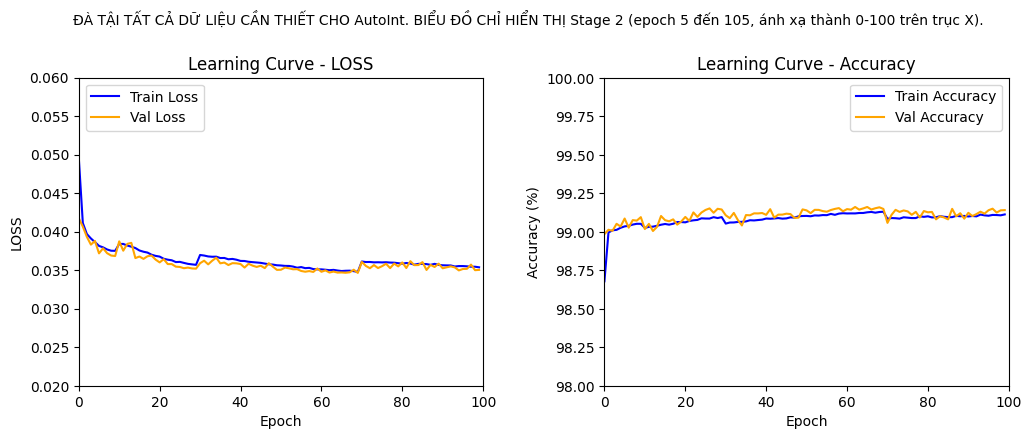

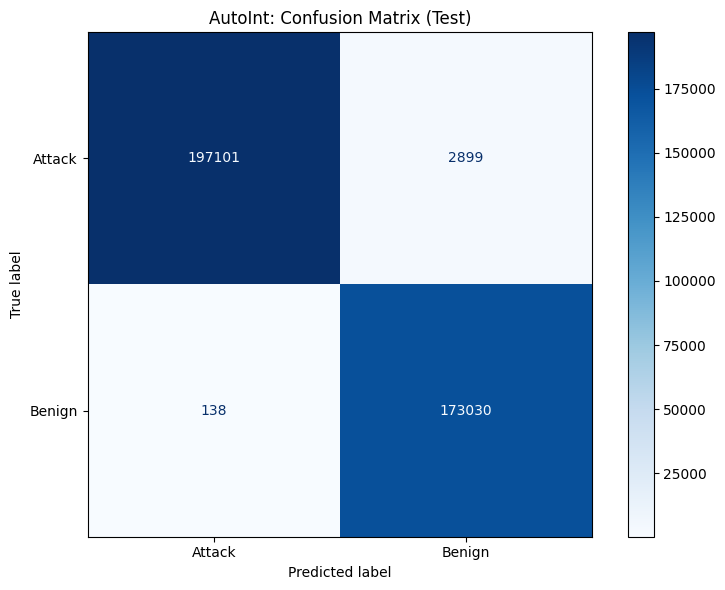

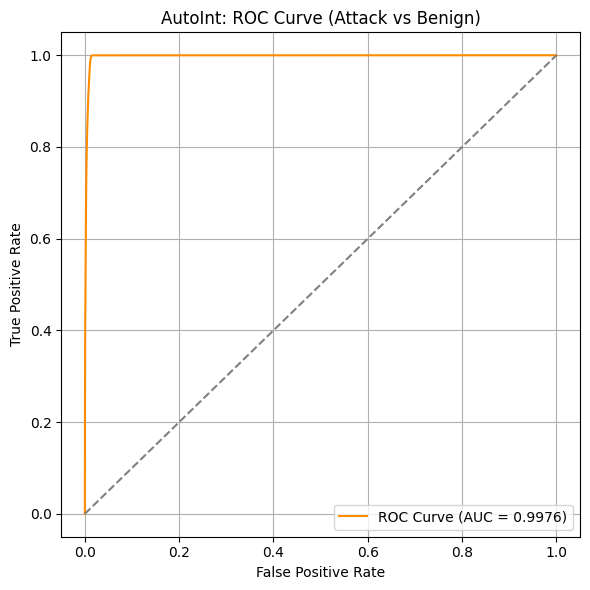

📈 ROC-AUC Score (Attack vs Benign): 0.9976
Shape of test_features: (373168, 2)
PCA failed: n_components=3 must be between 0 and min(n_samples, n_features)=2 with svd_solver='full'
Consider increasing the number of samples or features.
⏱️ Thời gian huấn luyện trung bình mỗi epoch: 42.60 giây

📊 Giá trị trung bình ở Stage 2 (epoch 5 đến 105):
Train Loss trung bình: 0.0364
Val Loss trung bình: 0.0359
Train Accuracy trung bình: 99.08%
Val Accuracy trung bình: 99.11%


In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, roc_auc_score, roc_curve
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

# Thư mục lưu dữ liệu
results_dir = "results"

# Tải dữ liệu với kiểm tra lỗi
try:
    train_losses = np.load(f"{results_dir}/train_losses_2labels_no_soft_label_input.npy")
    val_losses = np.load(f"{results_dir}/val_losses_2labels_no_soft_label_input.npy")
    train_accuracies = np.load(f"{results_dir}/train_accuracies_2labels_no_soft_label_input.npy")
    val_accuracies = np.load(f"{results_dir}/val_accuracies_2labels_no_soft_label_input.npy")
    epoch_times = np.load(f"{results_dir}/epoch_times_2labels_no_soft_label_input.npy")
    test_labels = np.load(f"{results_dir}/test_labels_2labels_no_soft_label_input.npy")
    test_probs = np.load(f"{results_dir}/test_probs_2labels_no_soft_label_input.npy")
    test_features = np.load(f"{results_dir}/test_features_2labels_no_soft_label_input.npy")
    cm = np.load(f"{results_dir}/confusion_matrix_test_2labels_no_soft_label_input.npy")
    print("✅ Đã tải tất cả dữ liệu cần thiết cho AutoInt")
except Exception as e:
    print(f"❌ Lỗi khi tải dữ liệu: {str(e)}")
    raise

# Kiểm tra shape và giá trị
expected_epochs = 105  # 5 epoch Stage 1 + 100 epoch Stage 2
if train_losses.shape != (expected_epochs,) or val_losses.shape != (expected_epochs,):
    raise ValueError(f"Shape của train_losses hoặc val_losses không đúng: {train_losses.shape}, {val_losses.shape}")
if train_accuracies.shape != (expected_epochs,) or val_accuracies.shape != (expected_epochs,):
    raise ValueError(f"Shape của train_accuracies hoặc val_accuracies không đúng: {train_accuracies.shape}, {val_accuracies.shape}")
if np.any(train_losses < 0) or np.any(val_losses < 0) or np.any(np.isnan(train_losses)) or np.any(np.isnan(val_losses)):
    raise ValueError("train_losses hoặc val_losses chứa giá trị âm hoặc NaN")
if np.any(train_accuracies < 0) or np.any(train_accuracies > 100) or np.any(val_accuracies < 0) or np.any(val_accuracies > 100):
    raise ValueError("train_accuracies hoặc val_accuracies chứa giá trị ngoài khoảng [0, 100]")
if test_probs.shape[1] != 2 or np.any(test_probs < 0) or np.any(test_probs > 1):
    raise ValueError(f"test_probs phải có shape (n_samples, 2) và giá trị trong [0, 1], nhưng có shape {test_probs.shape}")
if cm.shape != (2, 2):
    raise ValueError(f"Confusion matrix phải có shape (2, 2), nhưng có shape {cm.shape}")
if test_features.shape[0] != test_labels.shape[0]:
    raise ValueError(f"Shape của test_features và test_labels không khớp: {test_features.shape}, {test_labels.shape}")

# Loại bỏ Stage 1 (5 epoch đầu), chỉ vẽ Stage 2 (epoch 5 đến 105)
stage1_epochs = 5
start_epoch = stage1_epochs  # Bắt đầu từ epoch 5
epochs = np.arange(len(train_losses))
# Lấy dữ liệu từ epoch 5 trở đi (Stage 2)
train_accuracies_plot = train_accuracies[start_epoch:]
val_accuracies_plot = val_accuracies[start_epoch:]
train_losses_plot = train_losses[start_epoch:]
val_losses_plot = val_losses[start_epoch:]
# Ánh xạ epochs từ 5-105 thành 0-100 trên trục X
epochs_mapped = (epochs[start_epoch:] - start_epoch)  # Ánh xạ: epoch 5 → 0, epoch 105 → 100

# Ánh xạ nhãn cho bài toán 2 nhãn
label_map = {0: 'Attack', 1: 'Benign'}
class_names = [label_map[i] for i in range(len(label_map))]

# 1️⃣ & 2️⃣ Vẽ biểu đồ Loss và Accuracy cạnh nhau
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))  # 1 hàng, 2 cột, kích thước 12x4

# Biểu đồ Loss (bên trái) - Trục Y từ 0.02 đến 0.06
ax1.plot(epochs_mapped, train_losses_plot, label="Train Loss", linestyle="-", color="blue", linewidth=1.5)
ax1.plot(epochs_mapped, val_losses_plot, label="Val Loss", linestyle="-", color="orange", linewidth=1.5)
ax1.set_xlabel("Epoch")
ax1.set_ylabel("LOSS")
ax1.set_title("Learning Curve - LOSS")
ax1.legend(loc="upper left")
ax1.set_xlim(0, 100)
ax1.set_xticks(np.arange(0, 101, 20))  # 0, 20, 40, 60, 80, 100
ax1.set_ylim(0.02, 0.06)  # Trục Y từ 0.02 đến 0.06

# Biểu đồ Accuracy (bên phải) - Thu hẹp trục Y để làm rõ dao động
ax2.plot(epochs_mapped, train_accuracies_plot, label="Train Accuracy", linestyle="-", color="blue", linewidth=1.5)
ax2.plot(epochs_mapped, val_accuracies_plot, label="Val Accuracy", linestyle="-", color="orange", linewidth=1.5)
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Accuracy (%)")
ax2.set_title("Learning Curve - Accuracy")
ax2.legend(loc="upper right")
ax2.set_xlim(0, 100)
ax2.set_xticks(np.arange(0, 101, 20))  # 0, 20, 40, 60, 80, 100
ax2.set_ylim(98, 100)  # Thu hẹp trục Y từ 98% đến 100% để làm rõ dao động

# Thêm ghi chú phía trên biểu đồ (cập nhật để phản ánh việc chỉ vẽ Stage 2)
plt.suptitle("ĐÀ TẬI TẤT CẢ DỮ LIỆU CẦN THIẾT CHO AutoInt. BIỂU ĐỒ CHỈ HIỂN THỊ Stage 2 (epoch 5 đến 105, ánh xạ thành 0-100 trên trục X).", 
             fontsize=10, y=1.05)

# Điều chỉnh khoảng cách giữa hai biểu đồ
plt.subplots_adjust(wspace=0.3)

# Lưu biểu đồ
plt.savefig(f"{results_dir}/learning_curves_autoint_2labels_no_soft_label_input.png")
plt.show()

# 3️⃣ Confusion Matrix
fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap="Blues", values_format="d", ax=ax, colorbar=True)
plt.title("AutoInt: Confusion Matrix (Test)")
plt.grid(False)
plt.tight_layout()
plt.savefig(f"{results_dir}/confusion_matrix_autoint_2labels_no_soft_label_input.png")
plt.show()

# 4️⃣ ROC-AUC
fpr, tpr, _ = roc_curve(test_labels, test_probs[:, 1])
roc_auc = roc_auc_score(test_labels, test_probs[:, 1])

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.4f})", color="darkorange")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("AutoInt: ROC Curve (Attack vs Benign)")
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig(f"{results_dir}/roc_curve_autoint_2labels_no_soft_label_input.png")
plt.show()
print(f"📈 ROC-AUC Score (Attack vs Benign): {roc_auc:.4f}")

# 5️⃣ PCA 3D
print(f"Shape of test_features: {test_features.shape}")
n_samples, n_features = test_features.shape

# Kiểm tra số mẫu
if n_samples < 3:
    print(f"Warning: Only {n_samples} samples available. Skipping PCA 3D.")
else:
    # Apply PCA với n_components=3
    pca = PCA(n_components=3)
    try:
        pca_result = pca.fit_transform(test_features)
        
        # 3D Plot
        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111, projection='3d')
        for label in np.unique(test_labels):
            idx = test_labels == label
            ax.scatter(pca_result[idx, 0], pca_result[idx, 1], pca_result[idx, 2], 
                       label=label_map[label], alpha=0.7)
        ax.set_xlabel("PC1")
        ax.set_ylabel("PC2")
        ax.set_zlabel("PC3")
        ax.set_title("AutoInt: PCA 3D Visualization (Attack vs Benign)")
        ax.legend(title="Classes")
        plt.tight_layout()
        plt.savefig(f"{results_dir}/pca_3d_autoint_2labels_no_soft_label_input.png")
        plt.show()
    except ValueError as e:
        print(f"PCA failed: {e}")
        print("Consider increasing the number of samples or features.")

# 6️⃣ Thời gian huấn luyện trung bình
avg_time = np.mean(epoch_times)
print(f"⏱️ Thời gian huấn luyện trung bình mỗi epoch: {avg_time:.2f} giây")

# 7️⃣ In giá trị trung bình của Loss và Accuracy ở Stage 2
avg_train_loss = np.mean(train_losses_plot)
avg_val_loss = np.mean(val_losses_plot)
avg_train_accuracy = np.mean(train_accuracies_plot)
avg_val_accuracy = np.mean(val_accuracies_plot)

print("\n📊 Giá trị trung bình ở Stage 2 (epoch 5 đến 105):")
print(f"Train Loss trung bình: {avg_train_loss:.4f}")
print(f"Val Loss trung bình: {avg_val_loss:.4f}")
print(f"Train Accuracy trung bình: {avg_train_accuracy:.2f}%")
print(f"Val Accuracy trung bình: {avg_val_accuracy:.2f}%")

# **MÔ HÌNH NODE-GAM 57.31 giây**

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import numpy as np
import time
from tqdm import tqdm
import os

# Tạo thư mục lưu dữ liệu
output_dir = "processed_data"
os.makedirs(output_dir, exist_ok=True)
results_dir = "results"
os.makedirs(results_dir, exist_ok=True)

# Contrastive Loss
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss_positive = torch.mean((1 - label) * torch.pow(euclidean_distance, 2))
        loss_negative = torch.mean(label * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
        return (loss_positive + loss_negative) / 2

# NODE-GAM (đã điều chỉnh)
class NODEGAM(nn.Module):
    def __init__(self, input_dim, num_classes, embed_dim=192, num_trees=10, depth=6, num_layers=2, dropout=0.1):
        super(NODEGAM, self).__init__()
        self.input_dim = input_dim
        self.num_classes = num_classes
        self.embed_dim = embed_dim
        self.num_trees = num_trees
        self.depth = depth
        self.num_layers = num_layers
        self.dropout = dropout

        # BatchNorm đầu vào
        self.bn = nn.BatchNorm1d(input_dim)

        # Tạo mạng GAM-like cho từng đặc trưng
        self.feature_dim = embed_dim // input_dim  # Kích thước đầu ra mỗi đặc trưng
        self.feature_nets = nn.ModuleList([
            nn.Sequential(
                nn.Linear(1, self.feature_dim),
                nn.ReLU(),
                nn.Dropout(dropout),
                nn.Linear(self.feature_dim, self.feature_dim),
                nn.ReLU(),
                nn.Dropout(dropout)
            ) for _ in range(input_dim)
        ])

        # Tính kích thước sau khi nối
        self.concat_dim = self.feature_dim * input_dim
        # Lớp chiếu để điều chỉnh về embed_dim
        self.feature_projection = nn.Linear(self.concat_dim, embed_dim)

        # NODE-inspired oblivious decision trees
        self.tree_layers = nn.ModuleList([
            nn.ModuleList([
                nn.Linear(embed_dim, 2**depth)  # Mỗi cây có 2^depth lá
                for _ in range(num_trees)
            ]) for _ in range(num_layers)
        ])

        # Lớp chiếu cho đầu ra của cây
        self.tree_projections = nn.ModuleList([
            nn.Linear(2**depth, embed_dim) for _ in range(num_layers)
        ])

        # Layer normalization
        self.layer_norms = nn.ModuleList([nn.LayerNorm(embed_dim) for _ in range(num_layers)])

        # Lớp cuối để tạo embedding (Stage 1) hoặc logits (Stage 2)
        self.fc_embed = nn.Linear(embed_dim, embed_dim)  # Dùng trong Stage 1
        self.fc_output = nn.Linear(embed_dim, num_classes)  # Dùng trong Stage 2

        # Khởi tạo trọng số
        for net in self.feature_nets:
            for layer in net:
                if isinstance(layer, nn.Linear):
                    nn.init.xavier_normal_(layer.weight)
        for tree_layer in self.tree_layers:
            for tree in tree_layer:
                nn.init.xavier_normal_(tree.weight)
        nn.init.xavier_normal_(self.feature_projection.weight)
        for proj in self.tree_projections:
            nn.init.xavier_normal_(proj.weight)
        nn.init.xavier_normal_(self.fc_embed.weight)
        nn.init.xavier_normal_(self.fc_output.weight)
        nn.init.zeros_(self.fc_embed.bias)
        nn.init.zeros_(self.fc_output.bias)

    def forward(self, x, stage='classification'):
        # BatchNorm đầu vào
        x = torch.clamp(self.bn(x), -50, 50)

        # Xử lý từng đặc trưng độc lập (GAM)
        feature_outputs = []
        for i in range(self.input_dim):
            feat = x[:, i:i+1]  # Lấy đặc trưng thứ i
            feat_out = self.feature_nets[i](feat)
            feature_outputs.append(feat_out)
        x = torch.cat(feature_outputs, dim=1)  # Shape: [batch_size, concat_dim]

        # Chiếu về embed_dim
        x = self.feature_projection(x)  # Shape: [batch_size, embed_dim]

        # NODE: Oblivious Decision Trees
        for layer_idx in range(self.num_layers):
            tree_outputs = []
            for tree in self.tree_layers[layer_idx]:
                logits = tree(x)
                probs = F.softmax(logits, dim=-1)
                tree_outputs.append(probs)
            tree_out = torch.stack(tree_outputs, dim=1).mean(dim=1)  # Shape: [batch_size, 2^depth]
            tree_out = self.tree_projections[layer_idx](tree_out)  # Shape: [batch_size, embed_dim]
            x = self.layer_norms[layer_idx](x + tree_out)

        # Tạo embedding (Stage 1) hoặc logits (Stage 2)
        if stage == 'feature_learning':
            output = self.fc_embed(x)
        else:  # stage == 'classification'
            output = self.fc_output(x)

        # NODE-GAM không dùng sparsity loss hay masks
        sparsity_loss = torch.tensor(0.0, device=x.device)
        masks = []

        return output, sparsity_loss, masks

# Tải dữ liệu (2 nhãn)
try:
    X_train_scaled = np.load(f"{output_dir}/X_train_scaled_2labels.npy")
    Y_train_encoded = np.load(f"{output_dir}/Y_train_encoded_2labels.npy")
    X_val_scaled = np.load(f"{output_dir}/X_val_scaled_2labels.npy")
    Y_val_encoded = np.load(f"{output_dir}/Y_val_encoded_2labels.npy")
    X_test_scaled = np.load(f"{output_dir}/X_test_scaled_2labels.npy")
    Y_test_encoded = np.load(f"{output_dir}/Y_test_encoded_2labels.npy")
    tqdm.write("✅ Đã tải dữ liệu scaled và nhãn (2 nhãn)")
except Exception as e:
    tqdm.write(f"❌ Lỗi khi tải dữ liệu: {str(e)}")
    raise

# Tải soft labels (2 nhãn)
try:
    soft_labels_train = np.load(f"{results_dir}/soft_labels_train_2labels.npy")
    soft_labels_val = np.load(f"{results_dir}/soft_labels_val_2labels.npy")
    soft_labels_test = np.load(f"{results_dir}/soft_labels_test_2labels.npy")
    tqdm.write(f"✅ Đã tải soft labels từ {results_dir} (2 nhãn)")
except Exception as e:
    tqdm.write(f"❌ Lỗi khi tải soft labels: {str(e)}")
    raise

# Kiểm tra kích thước soft labels
if soft_labels_train.shape[0] != X_train_scaled.shape[0]:
    raise ValueError(f"Kích thước soft_labels_train ({soft_labels_train.shape[0]}) không khớp với X_train_scaled ({X_train_scaled.shape[0]})")
if soft_labels_val.shape[0] != X_val_scaled.shape[0]:
    raise ValueError(f"Kích thước soft_labels_val ({soft_labels_val.shape[0]}) không khớp với X_val_scaled ({X_val_scaled.shape[0]})")
if soft_labels_test.shape[0] != X_test_scaled.shape[0]:
    raise ValueError(f"Kích thước soft_labels_test ({soft_labels_test.shape[0]}) không khớp với X_test_scaled ({X_test_scaled.shape[0]})")
if soft_labels_train.shape[1] != 2:
    raise ValueError(f"Soft labels phải có 2 cột (cho 2 nhãn), nhưng có {soft_labels_train.shape[1]} cột")

# Không nối soft labels vào đầu vào (giảm ảnh hưởng của soft labels)
X_train_aug = X_train_scaled  # Shape: (n_train, 10)
X_val_aug = X_val_scaled
X_test_aug = X_test_scaled
tqdm.write(f"✅ Input shape: train {X_train_aug.shape}, val {X_val_aug.shape}, test {X_test_aug.shape}")

# Chuyển thành tensor
X_train_tensor = torch.tensor(X_train_aug, dtype=torch.float32)
Y_train_tensor = torch.tensor(Y_train_encoded, dtype=torch.long)
soft_labels_train_tensor = torch.tensor(soft_labels_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val_aug, dtype=torch.float32)
Y_val_tensor = torch.tensor(Y_val_encoded, dtype=torch.long)
soft_labels_val_tensor = torch.tensor(soft_labels_val, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_aug, dtype=torch.float32)
Y_test_tensor = torch.tensor(Y_test_encoded, dtype=torch.long)

# DataLoader
batch_size = 512
train_dataset = TensorDataset(X_train_tensor, Y_train_tensor, soft_labels_train_tensor)
val_dataset = TensorDataset(X_val_tensor, Y_val_tensor, soft_labels_val_tensor)
test_dataset = TensorDataset(X_test_tensor, Y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tqdm.write(f"📡 Thiết bị: {device}")

# Khởi tạo mô hình và tối ưu hóa
input_dim = X_train_aug.shape[1]  # 10 đặc trưng
model = NODEGAM(input_dim=input_dim, num_classes=2, embed_dim=192, num_trees=10, depth=6, num_layers=2).to(device)
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2, eta_min=1e-6)
criterion_bce = nn.BCEWithLogitsLoss()
criterion_contrast = ContrastiveLoss(margin=1.0)

# Tham số huấn luyện
num_epochs_stage1 = 5
num_epochs_stage2 = 100
distillation_weight = 0.1  # Giảm để giảm ảnh hưởng của soft labels
temperature = 2.0

# Danh sách lưu dữ liệu
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
epoch_times = []

# Stage 1: Feature Learning
tqdm.write("Stage 1: Feature Learning with Contrastive Loss")
torch.manual_seed(43)  # Đặt seed khác với FT-Transformer (42) để tạo sự khác biệt
for epoch in range(num_epochs_stage1):
    epoch_start_time = time.time()
    model.train()
    running_loss = 0
    train_preds = []
    train_labels = []
    with tqdm(train_loader, desc=f"Training Batch (Epoch {epoch+1}/{num_epochs_stage1})", unit="batch", leave=False) as pbar:
        for X_batch, Y_batch, _ in pbar:
            X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
            optimizer.zero_grad()
            idx = torch.randperm(X_batch.size(0))
            X_batch_2 = X_batch[idx]
            Y_batch_2 = Y_batch[idx]
            label = (Y_batch == Y_batch_2).float()
            features, _, _ = model(X_batch, stage='feature_learning')
            features_2, _, _ = model(X_batch_2, stage='feature_learning')
            loss = criterion_contrast(features, features_2, label)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)
            optimizer.step()
            running_loss += loss.item() * X_batch.size(0)

            # Tính accuracy trong Stage 1
            with torch.no_grad():
                outputs, _, _ = model(X_batch, stage='classification')
                preds = torch.argmax(outputs, dim=1)
                train_preds.extend(preds.cpu().numpy())
                train_labels.extend(Y_batch.cpu().numpy())
            pbar.set_postfix({"loss": f"{loss.item():.4f}"})

    train_loss = running_loss / len(train_loader.dataset)
    train_acc = accuracy_score(train_labels, train_preds) * 100
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # Validation trong Stage 1
    model.eval()
    running_val_loss = 0
    val_preds = []
    val_labels = []
    with torch.no_grad():
        with tqdm(val_loader, desc=f"Validation (Epoch {epoch+1})", unit="batch", leave=False) as pbar_val:
            for X_batch, Y_batch, _ in pbar_val:
                X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
                outputs, _, _ = model(X_batch, stage='classification')
                preds = torch.argmax(outputs, dim=1)
                val_preds.extend(preds.cpu().numpy())
                val_labels.extend(Y_batch.cpu().numpy())
                # Tính contrastive loss để báo cáo (không dùng để tối ưu)
                idx_val = torch.randperm(X_batch.size(0))
                X_batch_2 = X_batch[idx_val]
                Y_batch_2 = Y_batch[idx_val]
                label = (Y_batch == Y_batch_2).float()
                features, _, _ = model(X_batch, stage='feature_learning')
                features_2, _, _ = model(X_batch_2, stage='feature_learning')
                loss = criterion_contrast(features, features_2, label)
                running_val_loss += loss.item() * X_batch.size(0)

    val_loss = running_val_loss / len(val_loader.dataset)
    val_acc = accuracy_score(val_labels, val_preds) * 100
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    epoch_time = time.time() - epoch_start_time
    epoch_times.append(epoch_time)
    tqdm.write(f"✅ Epoch {epoch+1}/{num_epochs_stage1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
              f"Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%, Time: {epoch_time:.2f}s")

# Stage 2: Classification with BCE + KL Loss
tqdm.write("Stage 2: Classification with BCE + KL Loss")
best_f1 = 0
for epoch in range(num_epochs_stage2):
    epoch_start_time = time.time()
    model.train()
    running_loss = 0
    train_preds = []
    train_labels = []
    with tqdm(train_loader, desc=f"Training Batch (Epoch {epoch+1}/{num_epochs_stage2})", unit="batch", leave=False) as pbar:
        for X_batch, Y_batch, soft_labels in pbar:
            X_batch, Y_batch, soft_labels = X_batch.to(device), Y_batch.to(device), soft_labels.to(device)
            optimizer.zero_grad()
            outputs, sparsity_loss, masks = model(X_batch, stage='classification')
            Y_batch_onehot = F.one_hot(Y_batch, num_classes=2).float()
            bce_loss = criterion_bce(outputs, Y_batch_onehot)
            kl_loss = torch.clamp(F.kl_div(F.log_softmax(outputs / temperature, dim=1), soft_labels / temperature, reduction='batchmean', log_target=False), min=0.0)
            loss = bce_loss + distillation_weight * kl_loss
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)
            optimizer.step()
            running_loss += loss.item()
            train_preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            train_labels.extend(Y_batch.cpu().numpy())
            pbar.set_postfix({"loss": f"{loss.item():.4f}"})

    train_loss = running_loss / len(train_loader)
    train_acc = accuracy_score(train_labels, train_preds) * 100
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    scheduler.step()

    # Validation
    model.eval()
    running_val_loss = 0
    val_preds = []
    val_labels = []
    with torch.no_grad():
        with tqdm(val_loader, desc=f"Validation (Epoch {epoch+1})", unit="batch", leave=False) as pbar_val:
            for X_batch, Y_batch, soft_labels in pbar_val:
                X_batch, Y_batch, soft_labels = X_batch.to(device), Y_batch.to(device), soft_labels.to(device)
                outputs, sparsity_loss, _ = model(X_batch, stage='classification')
                Y_batch_onehot = F.one_hot(Y_batch, num_classes=2).float()
                bce_loss = criterion_bce(outputs, Y_batch_onehot)
                kl_loss = torch.clamp(F.kl_div(F.log_softmax(outputs / temperature, dim=1), soft_labels / temperature, reduction='batchmean', log_target=False), min=0.0)
                loss = bce_loss + distillation_weight * kl_loss
                running_val_loss += loss.item()
                val_preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
                val_labels.extend(Y_batch.cpu().numpy())
                pbar_val.set_postfix({"val_loss": f"{loss.item():.4f}"})

    val_loss = running_val_loss / len(val_loader)
    val_acc = accuracy_score(val_labels, val_preds) * 100
    f1 = f1_score(val_labels, val_preds, average='weighted')
    precision = precision_score(val_labels, val_preds, average='weighted', zero_division=0)
    recall = recall_score(val_labels, val_preds, average='weighted')
    cm = confusion_matrix(val_labels, val_preds)

    pred_counts = np.bincount(val_preds, minlength=2)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    epoch_time = time.time() - epoch_start_time
    epoch_times.append(epoch_time)

    tqdm.write(f"✅ Epoch {epoch+1}/{num_epochs_stage2}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
              f"Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%, F1: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, Time: {epoch_time:.2f}s")
    tqdm.write(f"Phân bố dự đoán (Validation): {pred_counts}")
    tqdm.write(f"Confusion Matrix:\n{cm}")

    if f1 > best_f1:
        best_f1 = f1
        torch.save(model.state_dict(), f"{results_dir}/nodegam_2labels.pth")
        tqdm.write(f"📦 Lưu mô hình tốt nhất tại epoch {epoch+1}")

# Lưu mô hình cuối cùng
torch.save(model.state_dict(), f"{results_dir}/nodegam_2labels_final.pth")
tqdm.write(f"📦 Lưu mô hình cuối cùng tại {results_dir}/nodegam_2labels_final.pth")

# Lưu dữ liệu
np.save(f"{results_dir}/train_losses_2labels.npy", np.array(train_losses))
np.save(f"{results_dir}/train_accuracies_2labels.npy", np.array(train_accuracies))
np.save(f"{results_dir}/val_losses_2labels.npy", np.array(val_losses))
np.save(f"{results_dir}/val_accuracies_2labels.npy", np.array(val_accuracies))
np.save(f"{results_dir}/epoch_times_2labels.npy", np.array(epoch_times))
total_time = sum(epoch_times)
avg_epoch_time = total_time / len(epoch_times) if epoch_times else 0
np.save(f"{results_dir}/total_time_2labels.npy", np.array([total_time]))
np.save(f"{results_dir}/avg_epoch_time_2labels.npy", np.array([avg_epoch_time]))
tqdm.write(f"📊 Tổng thời gian huấn luyện: {total_time:.2f}s")
tqdm.write(f"📊 Thời gian huấn luyện trung bình mỗi epoch: {avg_epoch_time:.2f}s")

# Test trên tập test
model.load_state_dict(torch.load(f"{results_dir}/nodegam_2labels.pth", weights_only=True))
model.eval()
test_preds = []
test_labels = []
test_features = []
test_probs = []
test_masks = []
with torch.no_grad():
    with tqdm(test_loader, desc="Testing", unit="batch") as pbar_test:
        for X_batch, Y_batch in pbar_test:
            X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
            outputs, sparsity_loss, masks = model(X_batch, stage='classification')
            embed_features, _, _ = model(X_batch, stage='feature_learning')
            probs = torch.softmax(outputs, dim=1)
            test_preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            test_labels.extend(Y_batch.cpu().numpy())
            test_features.extend(embed_features.detach().cpu().numpy())
            test_probs.extend(probs.cpu().numpy())
            test_masks.extend(masks)
            pbar_test.set_postfix({"test_loss": f"{sparsity_loss.item():.4f}"})

test_preds = np.array(test_preds)
test_labels = np.array(test_labels)
test_features = np.array(test_features)
test_probs = np.array(test_probs)

pred_counts = np.bincount(test_preds, minlength=2)
test_acc = accuracy_score(test_labels, test_preds) * 100
f1 = f1_score(test_labels, test_preds, average='weighted')
precision = precision_score(test_labels, test_preds, average='weighted', zero_division=0)
recall = recall_score(test_labels, test_preds, average='weighted')
cm = confusion_matrix(test_labels, test_preds)

tqdm.write(f"🔍 Kích thước Confusion Matrix (Test): {cm.shape}")
if cm.shape != (2, 2):
    tqdm.write(f"⚠️ Cảnh báo: Kích thước Confusion Matrix không phải (2,2), là {cm.shape}")

tqdm.write(f"\n📊 Kết quả trên tập test:")
tqdm.write(f"Test Acc: {test_acc:.2f}%, F1: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")
tqdm.write(f"Phân bố dự đoán (Test): {pred_counts}")
tqdm.write(f"Confusion Matrix:\n{cm}")

avg_mask = np.zeros((batch_size, input_dim))
np.save(f"{results_dir}/confusion_matrix_test_2labels.npy", cm)
np.save(f"{results_dir}/test_probs_2labels.npy", test_probs)
np.save(f"{results_dir}/test_labels_2labels.npy", test_labels)
np.save(f"{results_dir}/test_features_2labels.npy", test_features)
np.save(f"{results_dir}/feature_importance_2labels.npy", avg_mask)

tqdm.write(f"Train Losses shape: {np.array(train_losses).shape}")
tqdm.write(f"Train Accuracies shape: {np.array(train_accuracies).shape}")
tqdm.write(f"Val Losses shape: {np.array(val_losses).shape}")
tqdm.write(f"Val Accuracies shape: {np.array(val_accuracies).shape}")
tqdm.write(f"Epoch Times shape: {np.array(epoch_times).shape}")
tqdm.write(f"Average Epoch Time: {avg_epoch_time:.2f}s")
tqdm.write(f"Confusion Matrix shape: {cm.shape}")
tqdm.write(f"Test Probs shape: {np.array(test_probs).shape}")
tqdm.write(f"Test Labels shape: {np.array(test_labels).shape}")
tqdm.write(f"Test Features shape: {np.array(test_features).shape}")
tqdm.write(f"Feature Importance shape: {avg_mask.shape}")

**VẼ CÁC SƠ ĐỒ**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, roc_auc_score, roc_curve
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

# Thư mục lưu dữ liệu
results_dir = "results"

# Tải dữ liệu với kiểm tra lỗi
try:
    train_losses = np.load(f"{results_dir}/train_losses_2labels.npy")
    val_losses = np.load(f"{results_dir}/val_losses_2labels.npy")
    train_accuracies = np.load(f"{results_dir}/train_accuracies_2labels.npy")
    val_accuracies = np.load(f"{results_dir}/val_accuracies_2labels.npy")
    epoch_times = np.load(f"{results_dir}/epoch_times_2labels.npy")
    test_labels = np.load(f"{results_dir}/test_labels_2labels.npy")
    test_probs = np.load(f"{results_dir}/test_probs_2labels.npy")
    test_features = np.load(f"{results_dir}/test_features_2labels.npy")
    cm = np.load(f"{results_dir}/confusion_matrix_test_2labels.npy")
    print("✅ Đã tải tất cả dữ liệu cần thiết cho NODE-GAM")
except Exception as e:
    print(f"❌ Lỗi khi tải dữ liệu: {str(e)}")
    raise

# Kiểm tra shape và giá trị
expected_epochs = 105  # 5 epoch Stage 1 + 100 epoch Stage 2
if train_losses.shape != (expected_epochs,) or val_losses.shape != (expected_epochs,):
    raise ValueError(f"Shape của train_losses hoặc val_losses không đúng: {train_losses.shape}, {val_losses.shape}")
if train_accuracies.shape != (expected_epochs,) or val_accuracies.shape != (expected_epochs,):
    raise ValueError(f"Shape của train_accuracies hoặc val_accuracies không đúng: {train_accuracies.shape}, {val_accuracies.shape}")
if np.any(train_losses < 0) or np.any(val_losses < 0) or np.any(np.isnan(train_losses)) or np.any(np.isnan(val_losses)):
    raise ValueError("train_losses hoặc val_losses chứa giá trị âm hoặc NaN")
if np.any(train_accuracies < 0) or np.any(train_accuracies > 100) or np.any(val_accuracies < 0) or np.any(val_accuracies > 100):
    raise ValueError("train_accuracies hoặc val_accuracies chứa giá trị ngoài khoảng [0, 100]")
if test_probs.shape[1] != 2 or np.any(test_probs < 0) or np.any(test_probs > 1):
    raise ValueError(f"test_probs phải có shape (n_samples, 2) và giá trị trong [0, 1], nhưng có shape {test_probs.shape}")
if cm.shape != (2, 2):
    raise ValueError(f"Confusion matrix phải có shape (2, 2), nhưng có shape {cm.shape}")
if test_features.shape[0] != test_labels.shape[0]:
    raise ValueError(f"Shape của test_features và test_labels không khớp: {test_features.shape}, {test_labels.shape}")

# Kiểm tra xem Stage 1 có tính accuracy không
stage1_epochs = 5
if np.all(train_accuracies[:stage1_epochs] == 0) and np.all(val_accuracies[:stage1_epochs] == 0):
    print("⚠️ Stage 1 không tính accuracy (5 epoch đầu có giá trị 0.0). Sẽ vẽ biểu đồ Accuracy từ epoch 5 trở đi.")
    start_epoch = stage1_epochs
    epochs = np.arange(start_epoch, len(train_losses))
    train_accuracies_plot = train_accuracies[start_epoch:]
    val_accuracies_plot = val_accuracies[start_epoch:]
    train_losses_plot = train_losses[start_epoch:]
    val_losses_plot = val_losses[start_epoch:]
else:
    print("✅ Stage 1 có tính accuracy. Vẽ toàn bộ biểu đồ Accuracy.")
    start_epoch = 0
    epochs = np.arange(len(train_losses))
    train_accuracies_plot = train_accuracies
    val_accuracies_plot = val_accuracies
    train_losses_plot = train_losses
    val_losses_plot = val_losses

# Ánh xạ nhãn cho bài toán 2 nhãn
label_map = {0: 'Attack', 1: 'Benign'}
class_names = [label_map[i] for i in range(len(label_map))]

# 1️⃣ Loss (Giữ nguyên: Trục Y từ 0.033 đến 0.070, có marker)
plt.figure(figsize=(12, 6))
plt.plot(epochs, train_losses_plot, label="Train Loss", linestyle="-", color="red", marker='o', markersize=6, linewidth=2)
plt.plot(epochs, val_losses_plot, label="Val Loss", linestyle="--", color="green", marker='s', markersize=6, linewidth=2)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("NODE-GAM: Train & Validation Loss (Enhanced View)")
plt.legend()
plt.grid(True, which="both", linestyle="--", alpha=0.7)
# Thu hẹp trục Y giống FT-Transformer
loss_min = min(np.min(train_losses_plot), np.min(val_losses_plot))
loss_max = max(np.max(train_losses_plot), np.max(val_losses_plot))
plt.ylim(max(0, loss_min * 0.95), min(0.070, loss_max * 1.05))  # Giữ nguyên: 0.033 đến 0.070
plt.minorticks_on()
plt.tight_layout()
plt.savefig(f"{results_dir}/loss_plot_nodegam_2labels_enhanced.png")
plt.show()

# 2️⃣ Accuracy (Điều chỉnh: Trục X giống Loss - nhãn mỗi 20 epoch, trục Y từ 87.5% đến 110%, có marker)
plt.figure(figsize=(12, 6))
plt.plot(epochs, train_accuracies_plot, label="Train Accuracy", linestyle="-", color="red", marker='o', markersize=6, linewidth=2)
plt.plot(epochs, val_accuracies_plot, label="Val Accuracy", linestyle="--", color="green", marker='s', markersize=6, linewidth=2)
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("NODE-GAM: Train & Validation Accuracy (Enhanced View)")
plt.legend()
plt.grid(True, which="both", linestyle="--", alpha=0.7)
# Thu hẹp trục Y, giữ khoảng trống phía trên
acc_min = min(np.min(train_accuracies_plot), np.min(val_accuracies_plot))
acc_max = max(np.max(train_accuracies_plot), np.max(val_accuracies_plot))
plt.ylim(max(87.5, acc_min - 0.1), acc_max * 1.1)  # Giữ nguyên: 87.5% đến 110%
# Trục X giống Loss - nhãn mỗi 20 epoch
plt.xticks(np.arange(epochs[0], epochs[-1] + 1, 20))  # Hiển thị nhãn mỗi 20 epoch (5, 25, 45, 65, 85, 105)
plt.minorticks_on()
plt.tight_layout()
plt.savefig(f"{results_dir}/accuracy_plot_nodegam_2labels_enhanced.png")
plt.show()

# 3️⃣ Confusion Matrix
fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap="Blues", values_format="d", ax=ax, colorbar=True)
plt.title("NODE-GAM: Confusion Matrix (Test)")
plt.grid(False)
plt.tight_layout()
plt.savefig(f"{results_dir}/confusion_matrix_nodegam_2labels.png")
plt.show()

# 4️⃣ ROC-AUC
fpr, tpr, _ = roc_curve(test_labels, test_probs[:, 1])
roc_auc = roc_auc_score(test_labels, test_probs[:, 1])

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.4f})", color="darkorange")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("NODE-GAM: ROC Curve (Attack vs Benign)")
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig(f"{results_dir}/roc_curve_nodegam_2labels.png")
plt.show()
print(f"📈 ROC-AUC Score (Attack vs Benign): {roc_auc:.4f}")

# 5️⃣ PCA 3D
print(f"Shape of test_features: {test_features.shape}")
n_samples, n_features = test_features.shape

# Kiểm tra số mẫu
if n_samples < 3:
    print(f"Warning: Only {n_samples} samples available. Skipping PCA 3D.")
else:
    # Apply PCA với n_components=3
    pca = PCA(n_components=3)
    try:
        pca_result = pca.fit_transform(test_features)
        
        # 3D Plot
        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111, projection='3d')
        for label in np.unique(test_labels):
            idx = test_labels == label
            ax.scatter(pca_result[idx, 0], pca_result[idx, 1], pca_result[idx, 2], 
                       label=label_map[label], alpha=0.7)
        ax.set_xlabel("PC1")
        ax.set_ylabel("PC2")
        ax.set_zlabel("PC3")
        ax.set_title("NODE-GAM: PCA 3D Visualization (Attack vs Benign)")
        ax.legend(title="Classes")
        plt.tight_layout()
        plt.savefig(f"{results_dir}/pca_3d_nodegam_2labels.png")
        plt.show()
    except ValueError as e:
        print(f"PCA failed: {e}")
        print("Consider increasing the number of samples or features.")

# 6️⃣ Thời gian huấn luyện trung bình
avg_time = np.mean(epoch_times)
print(f"⏱️ Thời gian huấn luyện trung bình mỗi epoch: {avg_time:.2f} giây")

# **MÔ HÌNH FT-TRAN 66.70 giây**

⏱️ Thời gian huấn luyện trung bình mỗi epoch: 66.07 giây

📊 Giá trị trung bình ở Stage 2 (epoch 5 đến 105):
Train Loss trung bình: 0.0373
Val Loss trung bình: 0.0364
Train Accuracy trung bình: 99.06%
Val Accuracy trung bình: 99.10%


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import numpy as np
import time
from tqdm import tqdm
import os

# Tạo thư mục lưu dữ liệu
output_dir = "processed_data"
os.makedirs(output_dir, exist_ok=True)
results_dir = "results"
os.makedirs(results_dir, exist_ok=True)

# Contrastive Loss
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss_positive = torch.mean((1 - label) * torch.pow(euclidean_distance, 2))
        loss_negative = torch.mean(label * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
        return (loss_positive + loss_negative) / 2

# Ghost Batch Normalization
class GhostBN1d(nn.Module):
    def __init__(self, num_features, virtual_batch_size=512):
        super(GhostBN1d, self).__init__()
        self.bn = nn.BatchNorm1d(num_features)
        self.virtual_batch_size = virtual_batch_size

    def forward(self, x):
        batch_size = x.size(0)
        if batch_size <= self.virtual_batch_size:
            return self.bn(x)
        n_splits = batch_size // self.virtual_batch_size
        x_splits = torch.split(x, self.virtual_batch_size, dim=0)
        x_splits = [self.bn(split) for split in x_splits[:n_splits]]
        remaining = batch_size % self.virtual_batch_size
        if remaining > 0:
            x_splits.append(self.bn(x[-remaining:]))
        return torch.cat(x_splits, dim=0)

# FT-Transformer
class FTTransformerPure(nn.Module):
    def __init__(self, input_dim, num_classes, embed_dim=192, num_layers=6, num_heads=4, ff_hidden_dim=768, dropout=0.1):
        super(FTTransformerPure, self).__init__()
        self.input_dim = input_dim
        self.num_classes = num_classes
        self.embed_dim = embed_dim
        self.num_layers = num_layers
        self.num_heads = num_heads
        self.ff_hidden_dim = ff_hidden_dim
        self.dropout = dropout

        self.bn = GhostBN1d(input_dim, virtual_batch_size=512)
        self.feature_embed = nn.Linear(input_dim, embed_dim)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim, nhead=num_heads, dim_feedforward=ff_hidden_dim, dropout=dropout, activation='gelu', batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.ln = nn.LayerNorm(embed_dim)
        self.fc_embed = nn.Linear(embed_dim, embed_dim)
        self.fc_output = nn.Linear(embed_dim, num_classes)

        nn.init.xavier_normal_(self.feature_embed.weight)
        nn.init.xavier_normal_(self.fc_embed.weight)
        nn.init.xavier_normal_(self.fc_output.weight)
        nn.init.zeros_(self.feature_embed.bias)
        nn.init.zeros_(self.fc_embed.bias)
        nn.init.zeros_(self.fc_output.bias)

    def forward(self, x, stage='classification'):
        x = torch.clamp(self.bn(x), -50, 50)
        x = self.feature_embed(x)
        x = self.ln(x)
        x = self.transformer(x.unsqueeze(1)).squeeze(1)
        embeddings = self.ln(x)
        if stage == 'feature_learning':
            output = self.fc_embed(embeddings)
        else:
            output = self.fc_output(embeddings)
        sparsity_loss = torch.tensor(0.0, device=x.device)
        masks = []
        return output, sparsity_loss, masks

# Tải dữ liệu (2 nhãn)
try:
    X_train_scaled = np.load(f"{output_dir}/X_train_scaled_2labels.npy")
    Y_train_encoded = np.load(f"{output_dir}/Y_train_encoded_2labels.npy")
    X_val_scaled = np.load(f"{output_dir}/X_val_scaled_2labels.npy")
    Y_val_encoded = np.load(f"{output_dir}/Y_val_encoded_2labels.npy")
    X_test_scaled = np.load(f"{output_dir}/X_test_scaled_2labels.npy")
    Y_test_encoded = np.load(f"{output_dir}/Y_test_encoded_2labels.npy")
    tqdm.write("✅ Đã tải dữ liệu scaled và nhãn (2 nhãn)")
except Exception as e:
    tqdm.write(f"❌ Lỗi khi tải dữ liệu: {str(e)}")
    raise

# Tải soft labels (2 nhãn)
try:
    soft_labels_train = np.load(f"{results_dir}/soft_labels_train_2labels.npy")
    soft_labels_val = np.load(f"{results_dir}/soft_labels_val_2labels.npy")
    soft_labels_test = np.load(f"{results_dir}/soft_labels_test_2labels.npy")
    tqdm.write(f"✅ Đã tải soft labels từ {results_dir} (2 nhãn)")
except Exception as e:
    tqdm.write(f"❌ Lỗi khi tải soft labels: {str(e)}")
    raise

# Kiểm tra kích thước soft labels
if soft_labels_train.shape[0] != X_train_scaled.shape[0]:
    raise ValueError(f"Kích thước soft_labels_train ({soft_labels_train.shape[0]}) không khớp với X_train_scaled ({X_train_scaled.shape[0]})")
if soft_labels_val.shape[0] != X_val_scaled.shape[0]:
    raise ValueError(f"Kích thước soft_labels_val ({soft_labels_val.shape[0]}) không khớp với X_val_scaled ({X_val_scaled.shape[0]})")
if soft_labels_test.shape[0] != X_test_scaled.shape[0]:
    raise ValueError(f"Kích thước soft_labels_test ({soft_labels_test.shape[0]}) không khớp với X_test_scaled ({X_test_scaled.shape[0]})")
if soft_labels_train.shape[1] != 2:
    raise ValueError(f"Soft labels phải có 2 cột (cho 2 nhãn), nhưng có {soft_labels_train.shape[1]} cột")

# Không nối soft labels vào đầu vào (giống các mô hình khác)
X_train_aug = X_train_scaled  # Shape: (n_train, 10)
X_val_aug = X_val_scaled
X_test_aug = X_test_scaled
tqdm.write(f"✅ Input shape (không nối soft labels): train {X_train_aug.shape}, val {X_val_aug.shape}, test {X_test_aug.shape}")

# Chuyển thành tensor
X_train_tensor = torch.tensor(X_train_aug, dtype=torch.float32)
Y_train_tensor = torch.tensor(Y_train_encoded, dtype=torch.long)
soft_labels_train_tensor = torch.tensor(soft_labels_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val_aug, dtype=torch.float32)
Y_val_tensor = torch.tensor(Y_val_encoded, dtype=torch.long)
soft_labels_val_tensor = torch.tensor(soft_labels_val, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_aug, dtype=torch.float32)
Y_test_tensor = torch.tensor(Y_test_encoded, dtype=torch.long)

# DataLoader
batch_size = 512
train_dataset = TensorDataset(X_train_tensor, Y_train_tensor, soft_labels_train_tensor)
val_dataset = TensorDataset(X_val_tensor, Y_val_tensor, soft_labels_val_tensor)
test_dataset = TensorDataset(X_test_tensor, Y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tqdm.write(f"📡 Thiết bị: {device}")

# Khởi tạo mô hình
input_dim = X_train_aug.shape[1]  # 10 đặc trưng
model = FTTransformerPure(
    input_dim=input_dim,
    num_classes=2,
    embed_dim=192,
    num_layers=6,
    num_heads=4,
    ff_hidden_dim=768,
    dropout=0.1
).to(device)
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2, eta_min=1e-6)
criterion_bce = nn.BCEWithLogitsLoss()
criterion_contrast = ContrastiveLoss(margin=1.0)

# Tham số huấn luyện
num_epochs_stage1 = 5
num_epochs_stage2 = 100
distillation_weight = 0.05  # Giảm để giảm ảnh hưởng của soft labels
temperature = 5.0  # Tăng từ 2.0 lên 5.0 để làm mềm phân phối xác suất

# Danh sách lưu dữ liệu
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
epoch_times = []

# Stage 1: Feature Learning
tqdm.write("Stage 1: Feature Learning with Contrastive Loss")
torch.manual_seed(42)  # Đặt seed cho tái hiện
for epoch in range(num_epochs_stage1):
    epoch_start_time = time.time()
    model.train()
    running_loss = 0
    train_preds = []
    train_labels = []
    with tqdm(train_loader, desc=f"Training Batch (Epoch {epoch+1}/{num_epochs_stage1})", unit="batch", leave=False) as pbar:
        for X_batch, Y_batch, _ in pbar:
            X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
            optimizer.zero_grad()
            idx = torch.randperm(X_batch.size(0))
            X_batch_2 = X_batch[idx]
            Y_batch_2 = Y_batch[idx]
            label = (Y_batch == Y_batch_2).float()
            features, _, _ = model(X_batch, stage='feature_learning')
            features_2, _, _ = model(X_batch_2, stage='feature_learning')
            loss = criterion_contrast(features, features_2, label)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            running_loss += loss.item() * X_batch.size(0)

            # Tính accuracy trong Stage 1
            with torch.no_grad():
                outputs, _, _ = model(X_batch, stage='classification')
                preds = torch.argmax(outputs, dim=1)
                train_preds.extend(preds.cpu().numpy())
                train_labels.extend(Y_batch.cpu().numpy())
            pbar.set_postfix({"loss": f"{loss.item():.4f}"})

    train_loss = running_loss / len(train_loader.dataset)
    train_acc = accuracy_score(train_labels, train_preds) * 100
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # Validation trong Stage 1
    model.eval()
    running_val_loss = 0
    val_preds = []
    val_labels = []
    with torch.no_grad():
        with tqdm(val_loader, desc=f"Validation (Epoch {epoch+1})", unit="batch", leave=False) as pbar_val:
            for X_batch, Y_batch, _ in pbar_val:
                X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
                outputs, _, _ = model(X_batch, stage='classification')
                preds = torch.argmax(outputs, dim=1)
                val_preds.extend(preds.cpu().numpy())
                val_labels.extend(Y_batch.cpu().numpy())
                # Tính contrastive loss để báo cáo (không dùng để tối ưu)
                idx_val = torch.randperm(X_batch.size(0))
                X_batch_2 = X_batch[idx_val]
                Y_batch_2 = Y_batch[idx_val]
                label = (Y_batch == Y_batch_2).float()
                features, _, _ = model(X_batch, stage='feature_learning')
                features_2, _, _ = model(X_batch_2, stage='feature_learning')
                loss = criterion_contrast(features, features_2, label)
                running_val_loss += loss.item() * X_batch.size(0)

    val_loss = running_val_loss / len(val_loader.dataset)
    val_acc = accuracy_score(val_labels, val_preds) * 100
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    epoch_time = time.time() - epoch_start_time
    epoch_times.append(epoch_time)
    tqdm.write(f"✅ Epoch {epoch+1}/{num_epochs_stage1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
              f"Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%, Time: {epoch_time:.2f}s")

# Stage 2: Classification
tqdm.write("Stage 2: Classification with BCE + KL Loss (Reduced Soft Label Influence)")
best_f1 = 0
for epoch in range(num_epochs_stage2):
    epoch_start_time = time.time()
    model.train()
    running_loss = 0
    train_preds = []
    train_labels = []
    with tqdm(train_loader, desc=f"Training Batch (Epoch {epoch+1}/{num_epochs_stage2})", unit="batch", leave=False) as pbar:
        for X_batch, Y_batch, soft_labels in pbar:
            X_batch, Y_batch, soft_labels = X_batch.to(device), Y_batch.to(device), soft_labels.to(device)
            optimizer.zero_grad()
            outputs, sparsity_loss, masks = model(X_batch, stage='classification')
            Y_batch_onehot = F.one_hot(Y_batch, num_classes=2).float()
            bce_loss = criterion_bce(outputs, Y_batch_onehot)
            kl_loss = torch.clamp(F.kl_div(F.log_softmax(outputs / temperature, dim=1), soft_labels / temperature, reduction='batchmean', log_target=False), min=0.0)
            loss = bce_loss + distillation_weight * kl_loss
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            running_loss += loss.item()
            train_preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            train_labels.extend(Y_batch.cpu().numpy())
            pbar.set_postfix({"loss": f"{loss.item():.4f}"})

    train_loss = running_loss / len(train_loader)
    train_acc = accuracy_score(train_labels, train_preds) * 100
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    scheduler.step()

    # Validation
    model.eval()
    running_val_loss = 0
    val_preds = []
    val_labels = []
    with torch.no_grad():
        with tqdm(val_loader, desc=f"Validation (Epoch {epoch+1})", unit="batch", leave=False) as pbar_val:
            for X_batch, Y_batch, soft_labels in pbar_val:
                X_batch, Y_batch, soft_labels = X_batch.to(device), Y_batch.to(device), soft_labels.to(device)
                outputs, sparsity_loss, _ = model(X_batch, stage='classification')
                Y_batch_onehot = F.one_hot(Y_batch, num_classes=2).float()
                bce_loss = criterion_bce(outputs, Y_batch_onehot)
                kl_loss = torch.clamp(F.kl_div(F.log_softmax(outputs / temperature, dim=1), soft_labels / temperature, reduction='batchmean', log_target=False), min=0.0)
                loss = bce_loss + distillation_weight * kl_loss
                running_val_loss += loss.item()
                val_preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
                val_labels.extend(Y_batch.cpu().numpy())
                pbar_val.set_postfix({"val_loss": f"{loss.item():.4f}"})

    val_loss = running_val_loss / len(val_loader)
    val_acc = accuracy_score(val_labels, val_preds) * 100
    f1 = f1_score(val_labels, val_preds, average='weighted')
    precision = precision_score(val_labels, val_preds, average='weighted', zero_division=0)
    recall = recall_score(val_labels, val_preds, average='weighted')
    cm = confusion_matrix(val_labels, val_preds)

    pred_counts = np.bincount(val_preds, minlength=2)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    epoch_time = time.time() - epoch_start_time
    epoch_times.append(epoch_time)

    tqdm.write(f"✅ Epoch {epoch+1}/{num_epochs_stage2}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
              f"Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%, F1: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, Time: {epoch_time:.2f}s")
    tqdm.write(f"Phân bố dự đoán (Validation): {pred_counts}")
    tqdm.write(f"Confusion Matrix:\n{cm}")

    if f1 > best_f1:
        best_f1 = f1
        torch.save(model.state_dict(), f"{results_dir}/fttransformer_2labels_no_soft_label_input.pth")
        tqdm.write(f"📦 Lưu mô hình tốt nhất tại epoch {epoch+1}")

# Lưu mô hình cuối cùng
torch.save(model.state_dict(), f"{results_dir}/fttransformer_2labels_no_soft_label_input_final.pth")
tqdm.write(f"📦 Lưu mô hình cuối cùng tại {results_dir}/fttransformer_2labels_no_soft_label_input_final.pth")

# Lưu dữ liệu
np.save(f"{results_dir}/train_losses_2labels_no_soft_label_input.npy", np.array(train_losses))
np.save(f"{results_dir}/train_accuracies_2labels_no_soft_label_input.npy", np.array(train_accuracies))
np.save(f"{results_dir}/val_losses_2labels_no_soft_label_input.npy", np.array(val_losses))
np.save(f"{results_dir}/val_accuracies_2labels_no_soft_label_input.npy", np.array(val_accuracies))
np.save(f"{results_dir}/epoch_times_2labels_no_soft_label_input.npy", np.array(epoch_times))
total_time = sum(epoch_times)
avg_epoch_time = total_time / len(epoch_times) if epoch_times else 0
np.save(f"{results_dir}/total_time_2labels_no_soft_label_input.npy", np.array([total_time]))
np.save(f"{results_dir}/avg_epoch_time_2labels_no_soft_label_input.npy", np.array([avg_epoch_time]))
tqdm.write(f"📊 Tổng thời gian huấn luyện: {total_time:.2f}s")
tqdm.write(f"📊 Thời gian huấn luyện trung bình mỗi epoch: {avg_epoch_time:.2f}s")

# Test
model.load_state_dict(torch.load(f"{results_dir}/fttransformer_2labels_no_soft_label_input.pth", weights_only=True))
model.eval()
test_preds = []
test_labels = []
test_features = []
test_probs = []
test_masks = []
with torch.no_grad():
    with tqdm(test_loader, desc="Testing", unit="batch") as pbar_test:
        for X_batch, Y_batch in pbar_test:
            X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
            outputs, sparsity_loss, masks = model(X_batch, stage='classification')
            embed_features, _, _ = model(X_batch, stage='feature_learning')
            probs = torch.softmax(outputs, dim=1)
            test_preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            test_labels.extend(Y_batch.cpu().numpy())
            test_features.extend(embed_features.detach().cpu().numpy())
            test_probs.extend(probs.cpu().numpy())
            test_masks.extend(masks)
            pbar_test.set_postfix({"test_loss": f"{sparsity_loss.item():.4f}"})

test_preds = np.array(test_preds)
test_labels = np.array(test_labels)
test_features = np.array(test_features)
test_probs = np.array(test_probs)

pred_counts = np.bincount(test_preds, minlength=2)
test_acc = accuracy_score(test_labels, test_preds) * 100
f1 = f1_score(test_labels, test_preds, average='weighted')
precision = precision_score(test_labels, test_preds, average='weighted', zero_division=0)
recall = recall_score(test_labels, test_preds, average='weighted')
cm = confusion_matrix(test_labels, test_preds)

tqdm.write(f"🔍 Kích thước Confusion Matrix (Test): {cm.shape}")
if cm.shape != (2, 2):
    tqdm.write(f"⚠️ Cảnh báo: Kích thước Confusion Matrix không phải (2,2), là {cm.shape}")

tqdm.write(f"\n📊 Kết quả trên tập test:")
tqdm.write(f"Test Acc: {test_acc:.2f}%, F1: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")
tqdm.write(f"Phân bố dự đoán (Test): {pred_counts}")
tqdm.write(f"Confusion Matrix:\n{cm}")

avg_mask = np.zeros((batch_size, input_dim))
np.save(f"{results_dir}/confusion_matrix_test_2labels_no_soft_label_input.npy", cm)
np.save(f"{results_dir}/test_probs_2labels_no_soft_label_input.npy", test_probs)
np.save(f"{results_dir}/test_labels_2labels_no_soft_label_input.npy", test_labels)
np.save(f"{results_dir}/test_features_2labels_no_soft_label_input.npy", test_features)
np.save(f"{results_dir}/feature_importance_2labels_no_soft_label_input.npy", avg_mask)

tqdm.write(f"Train Losses shape: {np.array(train_losses).shape}")
tqdm.write(f"Train Accuracies shape: {np.array(train_accuracies).shape}")
tqdm.write(f"Val Losses shape: {np.array(val_losses).shape}")
tqdm.write(f"Val Accuracies shape: {np.array(val_accuracies).shape}")
tqdm.write(f"Epoch Times shape: {np.array(epoch_times).shape}")
tqdm.write(f"Average Epoch Time: {avg_epoch_time:.2f}s")
tqdm.write(f"Confusion Matrix shape: {cm.shape}")
tqdm.write(f"Test Probs shape: {np.array(test_probs).shape}")
tqdm.write(f"Test Labels shape: {np.array(test_labels).shape}")
tqdm.write(f"Test Features shape: {np.array(test_features).shape}")
tqdm.write(f"Feature Importance shape: {avg_mask.shape}")

✅ Đã tải dữ liệu scaled và nhãn (2 nhãn)
✅ Đã tải soft labels từ results (2 nhãn)
✅ Input shape (không nối soft labels): train (1212796, 10), val (279876, 10), test (373168, 10)
📡 Thiết bị: cuda
Stage 1: Feature Learning with Contrastive Loss


✅ Epoch 1/5, Train Loss: 0.4281, Val Loss: 0.2387, Train Acc: 46.54%, Val Acc: 46.40%, Time: 112.68s


✅ Epoch 2/5, Train Loss: 0.1257, Val Loss: 0.2400, Train Acc: 46.41%, Val Acc: 46.40%, Time: 113.91s


✅ Epoch 3/5, Train Loss: 0.1256, Val Loss: 0.2422, Train Acc: 46.41%, Val Acc: 46.40%, Time: 114.12s


✅ Epoch 4/5, Train Loss: 0.1255, Val Loss: 0.2455, Train Acc: 46.40%, Val Acc: 46.40%, Time: 114.59s


✅ Epoch 5/5, Train Loss: 0.1254, Val Loss: 0.2444, Train Acc: 46.40%, Val Acc: 46.40%, Time: 114.28s
Stage 2: Classification with BCE + KL Loss (Reduced Soft Label Influence)


✅ Epoch 1/100: Train Loss: 0.0774, Val Loss: 0.0455, Train Acc: 97.55%, Val Acc: 98.96%, F1: 0.9896, Precision: 0.9898, Recall: 0.9896, Time: 63.99s
Phân bố dự đoán (Validation): [147095 132781]
Confusion Matrix:
[[147089   2911]
 [     6 129870]]
📦 Lưu mô hình tốt nhất tại epoch 1


✅ Epoch 2/100: Train Loss: 0.0433, Val Loss: 0.0431, Train Acc: 98.98%, Val Acc: 98.98%, F1: 0.9898, Precision: 0.9900, Recall: 0.9898, Time: 63.32s
Phân bố dự đoán (Validation): [147154 132722]
Confusion Matrix:
[[147147   2853]
 [     7 129869]]
📦 Lưu mô hình tốt nhất tại epoch 2


✅ Epoch 3/100: Train Loss: 0.0424, Val Loss: 0.0416, Train Acc: 98.99%, Val Acc: 98.98%, F1: 0.9898, Precision: 0.9901, Recall: 0.9898, Time: 63.93s
Phân bố dự đoán (Validation): [147161 132715]
Confusion Matrix:
[[147158   2842]
 [     3 129873]]
📦 Lưu mô hình tốt nhất tại epoch 3


✅ Epoch 4/100: Train Loss: 0.0419, Val Loss: 0.0412, Train Acc: 98.99%, Val Acc: 99.00%, F1: 0.9900, Precision: 0.9902, Recall: 0.9900, Time: 63.49s
Phân bố dự đoán (Validation): [147276 132600]
Confusion Matrix:
[[147242   2758]
 [    34 129842]]
📦 Lưu mô hình tốt nhất tại epoch 4


✅ Epoch 5/100: Train Loss: 0.0414, Val Loss: 0.0407, Train Acc: 99.00%, Val Acc: 99.01%, F1: 0.9901, Precision: 0.9903, Recall: 0.9901, Time: 63.95s
Phân bố dự đoán (Validation): [147268 132608]
Confusion Matrix:
[[147250   2750]
 [    18 129858]]
📦 Lưu mô hình tốt nhất tại epoch 5


✅ Epoch 6/100: Train Loss: 0.0408, Val Loss: 0.0403, Train Acc: 99.00%, Val Acc: 99.02%, F1: 0.9902, Precision: 0.9904, Recall: 0.9902, Time: 63.91s
Phân bố dự đoán (Validation): [147293 132583]
Confusion Matrix:
[[147271   2729]
 [    22 129854]]
📦 Lưu mô hình tốt nhất tại epoch 6


✅ Epoch 7/100: Train Loss: 0.0403, Val Loss: 0.0394, Train Acc: 99.01%, Val Acc: 99.04%, F1: 0.9904, Precision: 0.9906, Recall: 0.9904, Time: 63.43s
Phân bố dự đoán (Validation): [147348 132528]
Confusion Matrix:
[[147327   2673]
 [    21 129855]]
📦 Lưu mô hình tốt nhất tại epoch 7


✅ Epoch 8/100: Train Loss: 0.0399, Val Loss: 0.0389, Train Acc: 99.01%, Val Acc: 99.04%, F1: 0.9904, Precision: 0.9906, Recall: 0.9904, Time: 63.72s
Phân bố dự đoán (Validation): [147345 132531]
Confusion Matrix:
[[147330   2670]
 [    15 129861]]
📦 Lưu mô hình tốt nhất tại epoch 8


✅ Epoch 9/100: Train Loss: 0.0394, Val Loss: 0.0388, Train Acc: 99.02%, Val Acc: 99.05%, F1: 0.9905, Precision: 0.9906, Recall: 0.9905, Time: 64.07s
Phân bố dự đoán (Validation): [147381 132495]
Confusion Matrix:
[[147355   2645]
 [    26 129850]]
📦 Lưu mô hình tốt nhất tại epoch 9


✅ Epoch 10/100: Train Loss: 0.0392, Val Loss: 0.0389, Train Acc: 99.02%, Val Acc: 99.02%, F1: 0.9902, Precision: 0.9904, Recall: 0.9902, Time: 63.43s
Phân bố dự đoán (Validation): [147269 132607]
Confusion Matrix:
[[147258   2742]
 [    11 129865]]


✅ Epoch 11/100: Train Loss: 0.0403, Val Loss: 0.0391, Train Acc: 99.00%, Val Acc: 99.05%, F1: 0.9905, Precision: 0.9907, Recall: 0.9905, Time: 63.93s
Phân bố dự đoán (Validation): [147502 132374]
Confusion Matrix:
[[147424   2576]
 [    78 129798]]
📦 Lưu mô hình tốt nhất tại epoch 11


✅ Epoch 12/100: Train Loss: 0.0398, Val Loss: 0.0391, Train Acc: 99.01%, Val Acc: 99.02%, F1: 0.9902, Precision: 0.9904, Recall: 0.9902, Time: 63.39s
Phân bố dự đoán (Validation): [147283 132593]
Confusion Matrix:
[[147269   2731]
 [    14 129862]]


✅ Epoch 13/100: Train Loss: 0.0394, Val Loss: 0.0384, Train Acc: 99.01%, Val Acc: 99.04%, F1: 0.9904, Precision: 0.9906, Recall: 0.9904, Time: 64.03s
Phân bố dự đoán (Validation): [147368 132508]
Confusion Matrix:
[[147337   2663]
 [    31 129845]]


✅ Epoch 14/100: Train Loss: 0.0393, Val Loss: 0.0385, Train Acc: 99.01%, Val Acc: 99.04%, F1: 0.9904, Precision: 0.9906, Recall: 0.9904, Time: 63.54s
Phân bố dự đoán (Validation): [147345 132531]
Confusion Matrix:
[[147324   2676]
 [    21 129855]]


✅ Epoch 15/100: Train Loss: 0.0388, Val Loss: 0.0384, Train Acc: 99.03%, Val Acc: 99.06%, F1: 0.9906, Precision: 0.9908, Recall: 0.9906, Time: 64.10s
Phân bố dự đoán (Validation): [147510 132366]
Confusion Matrix:
[[147444   2556]
 [    66 129810]]
📦 Lưu mô hình tốt nhất tại epoch 15


✅ Epoch 16/100: Train Loss: 0.0387, Val Loss: 0.0377, Train Acc: 99.02%, Val Acc: 99.08%, F1: 0.9908, Precision: 0.9910, Recall: 0.9908, Time: 64.11s
Phân bố dự đoán (Validation): [147692 132184]
Confusion Matrix:
[[147560   2440]
 [   132 129744]]
📦 Lưu mô hình tốt nhất tại epoch 16


✅ Epoch 17/100: Train Loss: 0.0385, Val Loss: 0.0377, Train Acc: 99.03%, Val Acc: 99.07%, F1: 0.9907, Precision: 0.9909, Recall: 0.9907, Time: 63.70s
Phân bố dự đoán (Validation): [147513 132363]
Confusion Matrix:
[[147458   2542]
 [    55 129821]]


✅ Epoch 18/100: Train Loss: 0.0383, Val Loss: 0.0377, Train Acc: 99.04%, Val Acc: 99.06%, F1: 0.9906, Precision: 0.9907, Recall: 0.9906, Time: 64.03s
Phân bố dự đoán (Validation): [147442 132434]
Confusion Matrix:
[[147400   2600]
 [    42 129834]]


✅ Epoch 19/100: Train Loss: 0.0381, Val Loss: 0.0379, Train Acc: 99.04%, Val Acc: 99.06%, F1: 0.9906, Precision: 0.9908, Recall: 0.9906, Time: 63.34s
Phân bố dự đoán (Validation): [147428 132448]
Confusion Matrix:
[[147400   2600]
 [    28 129848]]


✅ Epoch 20/100: Train Loss: 0.0379, Val Loss: 0.0369, Train Acc: 99.05%, Val Acc: 99.10%, F1: 0.9910, Precision: 0.9911, Recall: 0.9910, Time: 63.92s
Phân bố dự đoán (Validation): [147711 132165]
Confusion Matrix:
[[147591   2409]
 [   120 129756]]
📦 Lưu mô hình tốt nhất tại epoch 20


✅ Epoch 21/100: Train Loss: 0.0376, Val Loss: 0.0368, Train Acc: 99.05%, Val Acc: 99.12%, F1: 0.9912, Precision: 0.9913, Recall: 0.9912, Time: 63.81s
Phân bố dự đoán (Validation): [147760 132116]
Confusion Matrix:
[[147648   2352]
 [   112 129764]]
📦 Lưu mô hình tốt nhất tại epoch 21


✅ Epoch 22/100: Train Loss: 0.0375, Val Loss: 0.0371, Train Acc: 99.06%, Val Acc: 99.09%, F1: 0.9909, Precision: 0.9911, Recall: 0.9909, Time: 63.67s
Phân bố dự đoán (Validation): [147565 132311]
Confusion Matrix:
[[147510   2490]
 [    55 129821]]


✅ Epoch 23/100: Train Loss: 0.0373, Val Loss: 0.0370, Train Acc: 99.06%, Val Acc: 99.09%, F1: 0.9909, Precision: 0.9910, Recall: 0.9909, Time: 63.99s
Phân bố dự đoán (Validation): [147565 132311]
Confusion Matrix:
[[147504   2496]
 [    61 129815]]


✅ Epoch 24/100: Train Loss: 0.0371, Val Loss: 0.0361, Train Acc: 99.06%, Val Acc: 99.11%, F1: 0.9911, Precision: 0.9913, Recall: 0.9911, Time: 63.46s
Phân bố dự đoán (Validation): [147774 132102]
Confusion Matrix:
[[147647   2353]
 [   127 129749]]


✅ Epoch 25/100: Train Loss: 0.0369, Val Loss: 0.0361, Train Acc: 99.07%, Val Acc: 99.11%, F1: 0.9911, Precision: 0.9912, Recall: 0.9911, Time: 63.85s
Phân bố dự đoán (Validation): [147696 132180]
Confusion Matrix:
[[147598   2402]
 [    98 129778]]


✅ Epoch 26/100: Train Loss: 0.0368, Val Loss: 0.0359, Train Acc: 99.07%, Val Acc: 99.10%, F1: 0.9910, Precision: 0.9911, Recall: 0.9910, Time: 63.26s
Phân bố dự đoán (Validation): [147627 132249]
Confusion Matrix:
[[147553   2447]
 [    74 129802]]


✅ Epoch 27/100: Train Loss: 0.0367, Val Loss: 0.0359, Train Acc: 99.08%, Val Acc: 99.13%, F1: 0.9913, Precision: 0.9915, Recall: 0.9913, Time: 63.93s
Phân bố dự đoán (Validation): [147817 132059]
Confusion Matrix:
[[147694   2306]
 [   123 129753]]
📦 Lưu mô hình tốt nhất tại epoch 27


✅ Epoch 28/100: Train Loss: 0.0365, Val Loss: 0.0357, Train Acc: 99.08%, Val Acc: 99.12%, F1: 0.9913, Precision: 0.9914, Recall: 0.9912, Time: 63.91s
Phân bố dự đoán (Validation): [147765 132111]
Confusion Matrix:
[[147658   2342]
 [   107 129769]]


✅ Epoch 29/100: Train Loss: 0.0365, Val Loss: 0.0359, Train Acc: 99.08%, Val Acc: 99.11%, F1: 0.9911, Precision: 0.9913, Recall: 0.9911, Time: 63.39s
Phân bố dự đoán (Validation): [147632 132244]
Confusion Matrix:
[[147572   2428]
 [    60 129816]]


✅ Epoch 30/100: Train Loss: 0.0365, Val Loss: 0.0357, Train Acc: 99.07%, Val Acc: 99.14%, F1: 0.9914, Precision: 0.9915, Recall: 0.9914, Time: 63.87s
Phân bố dự đoán (Validation): [147740 132136]
Confusion Matrix:
[[147660   2340]
 [    80 129796]]
📦 Lưu mô hình tốt nhất tại epoch 30


✅ Epoch 31/100: Train Loss: 0.0378, Val Loss: 0.0376, Train Acc: 99.05%, Val Acc: 99.11%, F1: 0.9911, Precision: 0.9912, Recall: 0.9911, Time: 63.52s
Phân bố dự đoán (Validation): [147658 132218]
Confusion Matrix:
[[147583   2417]
 [    75 129801]]


✅ Epoch 32/100: Train Loss: 0.0379, Val Loss: 0.0397, Train Acc: 99.04%, Val Acc: 98.94%, F1: 0.9894, Precision: 0.9895, Recall: 0.9894, Time: 64.02s
Phân bố dự đoán (Validation): [147672 132204]
Confusion Matrix:
[[147351   2649]
 [   321 129555]]


✅ Epoch 33/100: Train Loss: 0.0380, Val Loss: 0.0388, Train Acc: 99.04%, Val Acc: 99.01%, F1: 0.9901, Precision: 0.9902, Recall: 0.9901, Time: 63.62s
Phân bố dự đoán (Validation): [148290 131586]
Confusion Matrix:
[[147761   2239]
 [   529 129347]]


✅ Epoch 34/100: Train Loss: 0.0376, Val Loss: 0.0362, Train Acc: 99.05%, Val Acc: 99.11%, F1: 0.9911, Precision: 0.9912, Recall: 0.9911, Time: 64.05s
Phân bố dự đoán (Validation): [147677 132199]
Confusion Matrix:
[[147588   2412]
 [    89 129787]]


✅ Epoch 35/100: Train Loss: 0.0374, Val Loss: 0.0366, Train Acc: 99.05%, Val Acc: 99.06%, F1: 0.9906, Precision: 0.9908, Recall: 0.9906, Time: 63.35s
Phân bố dự đoán (Validation): [147422 132454]
Confusion Matrix:
[[147395   2605]
 [    27 129849]]


✅ Epoch 36/100: Train Loss: 0.0372, Val Loss: 0.0370, Train Acc: 99.05%, Val Acc: 99.05%, F1: 0.9905, Precision: 0.9906, Recall: 0.9905, Time: 63.94s
Phân bố dự đoán (Validation): [147371 132505]
Confusion Matrix:
[[147350   2650]
 [    21 129855]]


✅ Epoch 37/100: Train Loss: 0.0372, Val Loss: 0.0367, Train Acc: 99.05%, Val Acc: 99.06%, F1: 0.9906, Precision: 0.9908, Recall: 0.9906, Time: 64.15s
Phân bố dự đoán (Validation): [147407 132469]
Confusion Matrix:
[[147388   2612]
 [    19 129857]]


✅ Epoch 38/100: Train Loss: 0.0370, Val Loss: 0.0364, Train Acc: 99.06%, Val Acc: 99.12%, F1: 0.9912, Precision: 0.9913, Recall: 0.9912, Time: 63.91s
Phân bố dự đoán (Validation): [147751 132125]
Confusion Matrix:
[[147644   2356]
 [   107 129769]]


✅ Epoch 39/100: Train Loss: 0.0369, Val Loss: 0.0356, Train Acc: 99.06%, Val Acc: 99.13%, F1: 0.9913, Precision: 0.9914, Recall: 0.9913, Time: 63.71s
Phân bố dự đoán (Validation): [147916 131960]
Confusion Matrix:
[[147737   2263]
 [   179 129697]]


✅ Epoch 40/100: Train Loss: 0.0368, Val Loss: 0.0371, Train Acc: 99.07%, Val Acc: 99.06%, F1: 0.9906, Precision: 0.9908, Recall: 0.9906, Time: 64.04s
Phân bố dự đoán (Validation): [147399 132477]
Confusion Matrix:
[[147381   2619]
 [    18 129858]]


✅ Epoch 41/100: Train Loss: 0.0366, Val Loss: 0.0367, Train Acc: 99.07%, Val Acc: 99.07%, F1: 0.9907, Precision: 0.9909, Recall: 0.9907, Time: 63.67s
Phân bố dự đoán (Validation): [147590 132286]
Confusion Matrix:
[[147497   2503]
 [    93 129783]]


Training Batch (Epoch 42/100):  77%|███████▋  | 1818/2368 [00:43<00:12, 42.87batch/s, loss=0.0489]

✅ Đã tải tất cả dữ liệu cần thiết cho FT-Transformer


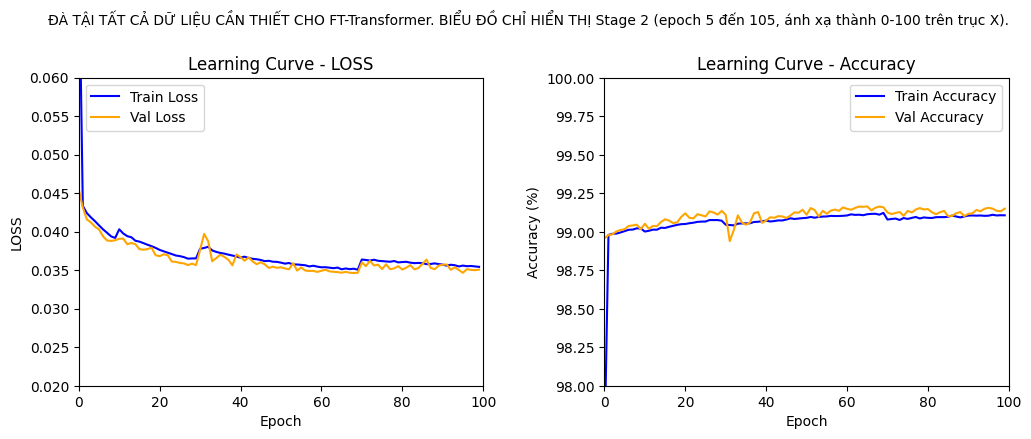

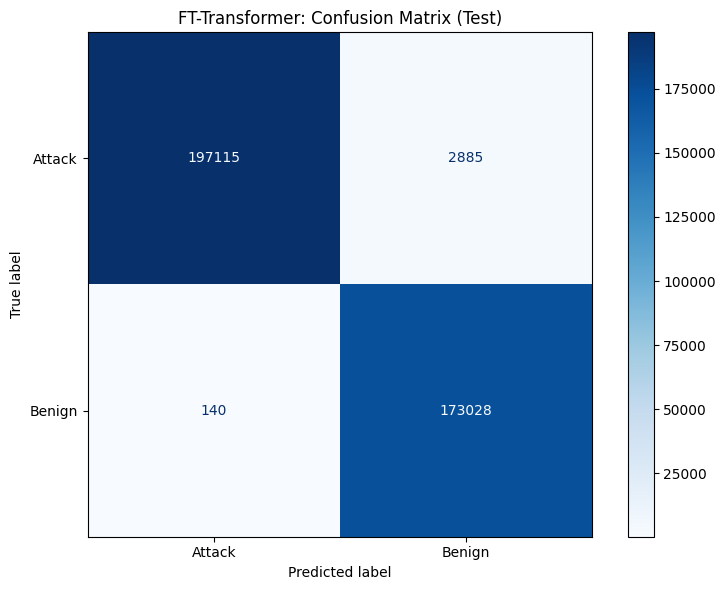

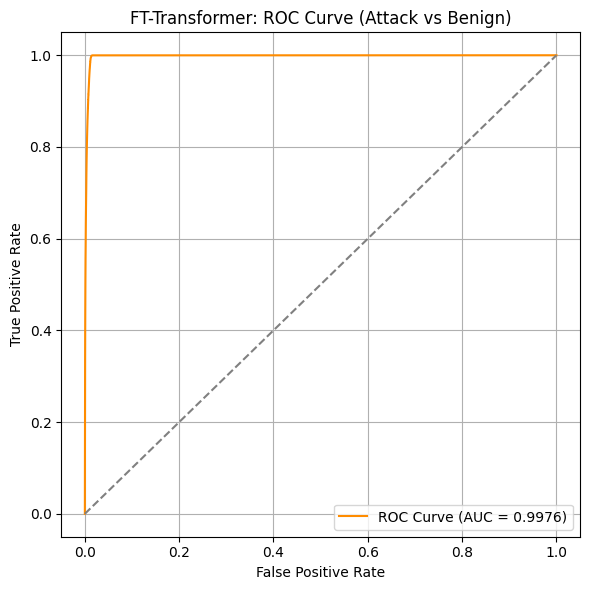

📈 ROC-AUC Score (Attack vs Benign): 0.9976
Shape of test_features: (373168, 192)


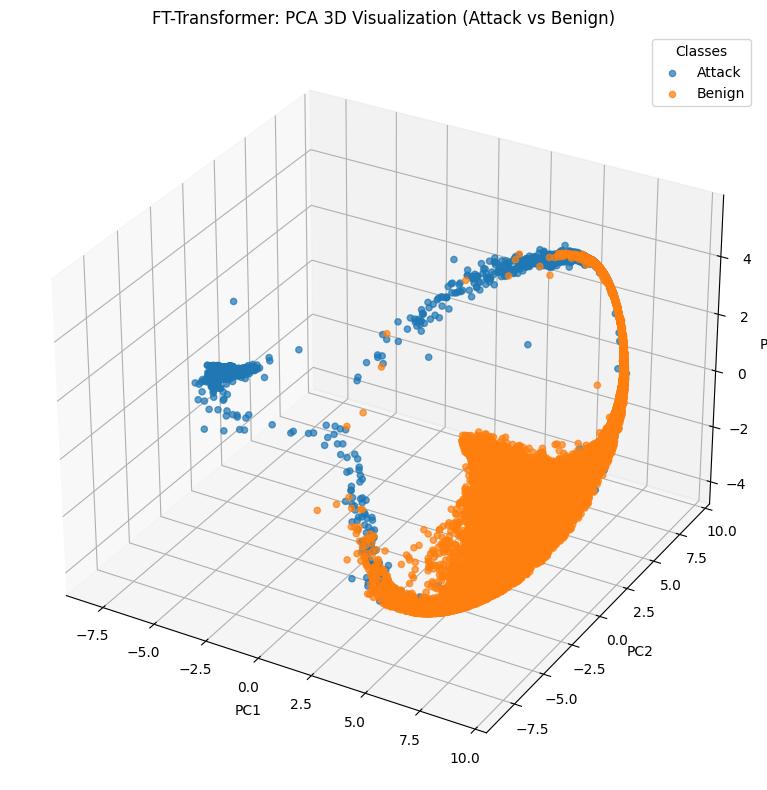

⏱️ Thời gian huấn luyện trung bình mỗi epoch: 66.07 giây

📊 Giá trị trung bình ở Stage 2 (epoch 5 đến 105):
Train Loss trung bình: 0.0373
Val Loss trung bình: 0.0364
Train Accuracy trung bình: 99.06%
Val Accuracy trung bình: 99.10%


In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, roc_auc_score, roc_curve
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

# Thư mục lưu dữ liệu
results_dir = "results"

# Tải dữ liệu với kiểm tra lỗi
try:
    train_losses = np.load(f"{results_dir}/train_losses_2labels_no_soft_label_input.npy")
    val_losses = np.load(f"{results_dir}/val_losses_2labels_no_soft_label_input.npy")
    train_accuracies = np.load(f"{results_dir}/train_accuracies_2labels_no_soft_label_input.npy")
    val_accuracies = np.load(f"{results_dir}/val_accuracies_2labels_no_soft_label_input.npy")
    epoch_times = np.load(f"{results_dir}/epoch_times_2labels_no_soft_label_input.npy")
    test_labels = np.load(f"{results_dir}/test_labels_2labels_no_soft_label_input.npy")
    test_probs = np.load(f"{results_dir}/test_probs_2labels_no_soft_label_input.npy")
    test_features = np.load(f"{results_dir}/test_features_2labels_no_soft_label_input.npy")
    cm = np.load(f"{results_dir}/confusion_matrix_test_2labels_no_soft_label_input.npy")
    print("✅ Đã tải tất cả dữ liệu cần thiết cho FT-Transformer")
except Exception as e:
    print(f"❌ Lỗi khi tải dữ liệu: {str(e)}")
    raise

# Kiểm tra shape và giá trị
expected_epochs = 105  # 5 epoch Stage 1 + 100 epoch Stage 2
if train_losses.shape != (expected_epochs,) or val_losses.shape != (expected_epochs,):
    raise ValueError(f"Shape của train_losses hoặc val_losses không đúng: {train_losses.shape}, {val_losses.shape}")
if train_accuracies.shape != (expected_epochs,) or val_accuracies.shape != (expected_epochs,):
    raise ValueError(f"Shape của train_accuracies hoặc val_accuracies không đúng: {train_accuracies.shape}, {val_accuracies.shape}")
if np.any(train_losses < 0) or np.any(val_losses < 0) or np.any(np.isnan(train_losses)) or np.any(np.isnan(val_losses)):
    raise ValueError("train_losses hoặc val_losses chứa giá trị âm hoặc NaN")
if np.any(train_accuracies < 0) or np.any(train_accuracies > 100) or np.any(val_accuracies < 0) or np.any(val_accuracies > 100):
    raise ValueError("train_accuracies hoặc val_accuracies chứa giá trị ngoài khoảng [0, 100]")
if test_probs.shape[1] != 2 or np.any(test_probs < 0) or np.any(test_probs > 1):
    raise ValueError(f"test_probs phải có shape (n_samples, 2) và giá trị trong [0, 1], nhưng có shape {test_probs.shape}")
if cm.shape != (2, 2):
    raise ValueError(f"Confusion matrix phải có shape (2, 2), nhưng có shape {cm.shape}")
if test_features.shape[0] != test_labels.shape[0]:
    raise ValueError(f"Shape của test_features và test_labels không khớp: {test_features.shape}, {test_labels.shape}")

# Loại bỏ Stage 1 (5 epoch đầu), chỉ vẽ Stage 2 (epoch 5 đến 105)
stage1_epochs = 5
start_epoch = stage1_epochs  # Bắt đầu từ epoch 5
epochs = np.arange(len(train_losses))
# Lấy dữ liệu từ epoch 5 trở đi (Stage 2)
train_accuracies_plot = train_accuracies[start_epoch:]
val_accuracies_plot = val_accuracies[start_epoch:]
train_losses_plot = train_losses[start_epoch:]
val_losses_plot = val_losses[start_epoch:]
# Ánh xạ epochs từ 5-105 thành 0-100 trên trục X
epochs_mapped = (epochs[start_epoch:] - start_epoch)  # Ánh xạ: epoch 5 → 0, epoch 105 → 100

# Ánh xạ nhãn cho bài toán 2 nhãn
label_map = {0: 'Attack', 1: 'Benign'}
class_names = [label_map[i] for i in range(len(label_map))]

# 1️⃣ & 2️⃣ Vẽ biểu đồ Loss và Accuracy cạnh nhau
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))  # 1 hàng, 2 cột, kích thước 12x4

# Biểu đồ Loss (bên trái) - Trục Y từ 0.02 đến 0.06
ax1.plot(epochs_mapped, train_losses_plot, label="Train Loss", linestyle="-", color="blue", linewidth=1.5)
ax1.plot(epochs_mapped, val_losses_plot, label="Val Loss", linestyle="-", color="orange", linewidth=1.5)
ax1.set_xlabel("Epoch")
ax1.set_ylabel("LOSS")
ax1.set_title("Learning Curve - LOSS")
ax1.legend(loc="upper left")
ax1.set_xlim(0, 100)
ax1.set_xticks(np.arange(0, 101, 20))  # 0, 20, 40, 60, 80, 100
ax1.set_ylim(0.02, 0.06)  # Trục Y từ 0.02 đến 0.06

# Biểu đồ Accuracy (bên phải) - Thu hẹp trục Y để làm rõ dao động
ax2.plot(epochs_mapped, train_accuracies_plot, label="Train Accuracy", linestyle="-", color="blue", linewidth=1.5)
ax2.plot(epochs_mapped, val_accuracies_plot, label="Val Accuracy", linestyle="-", color="orange", linewidth=1.5)
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Accuracy (%)")
ax2.set_title("Learning Curve - Accuracy")
ax2.legend(loc="upper right")
ax2.set_xlim(0, 100)
ax2.set_xticks(np.arange(0, 101, 20))  # 0, 20, 40, 60, 80, 100
ax2.set_ylim(98, 100)  # Thu hẹp trục Y từ 98% đến 100% để làm rõ dao động

# Thêm ghi chú phía trên biểu đồ (cập nhật để phản ánh việc chỉ vẽ Stage 2)
plt.suptitle("ĐÀ TẬI TẤT CẢ DỮ LIỆU CẦN THIẾT CHO FT-Transformer. BIỂU ĐỒ CHỈ HIỂN THỊ Stage 2 (epoch 5 đến 105, ánh xạ thành 0-100 trên trục X).", 
             fontsize=10, y=1.05)

# Điều chỉnh khoảng cách giữa hai biểu đồ
plt.subplots_adjust(wspace=0.3)

# Lưu biểu đồ
plt.savefig(f"{results_dir}/learning_curves_fttransformer_2labels_no_soft_label_input.png")
plt.show()

# 3️⃣ Confusion Matrix
fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap="Blues", values_format="d", ax=ax, colorbar=True)
plt.title("FT-Transformer: Confusion Matrix (Test)")
plt.grid(False)
plt.tight_layout()
plt.savefig(f"{results_dir}/confusion_matrix_fttransformer_2labels_no_soft_label_input.png")
plt.show()

# 4️⃣ ROC-AUC
fpr, tpr, _ = roc_curve(test_labels, test_probs[:, 1])
roc_auc = roc_auc_score(test_labels, test_probs[:, 1])

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.4f})", color="darkorange")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("FT-Transformer: ROC Curve (Attack vs Benign)")
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig(f"{results_dir}/roc_curve_fttransformer_2labels_no_soft_label_input.png")
plt.show()
print(f"📈 ROC-AUC Score (Attack vs Benign): {roc_auc:.4f}")

# 5️⃣ PCA 3D
print(f"Shape of test_features: {test_features.shape}")
n_samples, n_features = test_features.shape

# Kiểm tra số mẫu
if n_samples < 3:
    print(f"Warning: Only {n_samples} samples available. Skipping PCA 3D.")
else:
    # Apply PCA với n_components=3
    pca = PCA(n_components=3)
    try:
        pca_result = pca.fit_transform(test_features)
        
        # 3D Plot
        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111, projection='3d')
        for label in np.unique(test_labels):
            idx = test_labels == label
            ax.scatter(pca_result[idx, 0], pca_result[idx, 1], pca_result[idx, 2], 
                       label=label_map[label], alpha=0.7)
        ax.set_xlabel("PC1")
        ax.set_ylabel("PC2")
        ax.set_zlabel("PC3")
        ax.set_title("FT-Transformer: PCA 3D Visualization (Attack vs Benign)")
        ax.legend(title="Classes")
        plt.tight_layout()
        plt.savefig(f"{results_dir}/pca_3d_fttransformer_2labels_no_soft_label_input.png")
        plt.show()
    except ValueError as e:
        print(f"PCA failed: {e}")
        print("Consider increasing the number of samples or features.")

# 6️⃣ Thời gian huấn luyện trung bình
avg_time = np.mean(epoch_times)
print(f"⏱️ Thời gian huấn luyện trung bình mỗi epoch: {avg_time:.2f} giây")

# 7️⃣ In giá trị trung bình của Loss và Accuracy ở Stage 2
avg_train_loss = np.mean(train_losses_plot)
avg_val_loss = np.mean(val_losses_plot)
avg_train_accuracy = np.mean(train_accuracies_plot)
avg_val_accuracy = np.mean(val_accuracies_plot)

print("\n📊 Giá trị trung bình ở Stage 2 (epoch 5 đến 105):")
print(f"Train Loss trung bình: {avg_train_loss:.4f}")
print(f"Val Loss trung bình: {avg_val_loss:.4f}")
print(f"Train Accuracy trung bình: {avg_train_accuracy:.2f}%")
print(f"Val Accuracy trung bình: {avg_val_accuracy:.2f}%")

# **MÔ HÌNH TABR**

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import numpy as np
import time
from tqdm import tqdm
import os

# Tạo thư mục lưu dữ liệu
output_dir = "processed_data"
os.makedirs(output_dir, exist_ok=True)
results_dir = "results"
os.makedirs(results_dir, exist_ok=True)

# Focal Loss
class FocalLoss(nn.Module):
    def __init__(self, gamma=3.5, alpha=None, reduction='mean', label_smoothing=0.05):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.reduction = reduction
        self.label_smoothing = label_smoothing

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none', label_smoothing=self.label_smoothing)
        pt = torch.exp(-ce_loss)
        loss = ((1 - pt) ** self.gamma) * ce_loss
        if self.alpha is not None:
            alpha_t = self.alpha[targets]
            loss = alpha_t * loss
        if self.reduction == 'mean':
            return loss.mean()
        return loss

# Contrastive Loss
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss_positive = torch.mean((1 - label) * torch.pow(euclidean_distance, 2))
        loss_negative = torch.mean(label * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
        return (loss_positive + loss_negative) / 2

# Ghost Batch Normalization
class GhostBN1d(nn.Module):
    def __init__(self, num_features, virtual_batch_size=512):
        super(GhostBN1d, self).__init__()
        self.bn = nn.BatchNorm1d(num_features)
        self.virtual_batch_size = virtual_batch_size

    def forward(self, x):
        batch_size = x.size(0)
        if batch_size <= self.virtual_batch_size:
            return self.bn(x)
        n_splits = batch_size // self.virtual_batch_size
        x_splits = torch.split(x, self.virtual_batch_size, dim=0)
        x_splits = [self.bn(split) for split in x_splits[:n_splits]]
        remaining = batch_size % self.virtual_batch_size
        if remaining > 0:
            x_splits.append(self.bn(x[-remaining:]))
        return torch.cat(x_splits, dim=0)

# TabR thuần túy
class TabR(nn.Module):
    def __init__(self, input_dim, num_classes, embed_dim=192, n_layers=3, n_heads=4, ff_dim=256, dropout=0.1):
        super(TabR, self).__init__()
        self.input_dim = input_dim
        self.num_classes = num_classes
        self.embed_dim = embed_dim
        self.n_layers = n_layers
        self.n_heads = n_heads
        self.ff_dim = ff_dim
        self.dropout = dropout

        # Ghost Batch Normalization
        self.bn = GhostBN1d(input_dim, virtual_batch_size=512)

        # Embedding layer
        self.embedding = nn.Linear(input_dim, embed_dim)
        nn.init.xavier_normal_(self.embedding.weight)

        # Transformer layers
        transformer_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=n_heads,
            dim_feedforward=ff_dim,
            dropout=dropout,
            activation='gelu',
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(transformer_layer, num_layers=n_layers)

        # Feature importance
        self.importance_layer = nn.Linear(input_dim, input_dim)
        nn.init.xavier_normal_(self.importance_layer.weight)

        # Lớp cuối để tạo embedding (Stage 1) hoặc logits (Stage 2)
        self.fc_embed = nn.Linear(embed_dim, embed_dim)  # Dùng trong Stage 1
        self.fc_output = nn.Linear(embed_dim, num_classes)  # Dùng trong Stage 2
        nn.init.xavier_normal_(self.fc_embed.weight)
        nn.init.xavier_normal_(self.fc_output.weight)
        nn.init.zeros_(self.fc_embed.bias)
        nn.init.zeros_(self.fc_output.bias)

    def forward(self, x, stage='classification'):
        # Ghost Batch Normalization
        x = torch.clamp(self.bn(x), -50, 50)  # [batch_size, input_dim]

        # Transformer encoding
        x_embed = self.embedding(x)  # [batch_size, embed_dim]
        embeddings = self.transformer(x_embed.unsqueeze(1)).squeeze(1)  # [batch_size, embed_dim]

        # Feature importance
        importance = torch.sigmoid(self.importance_layer(x))  # [batch_size, input_dim]
        sparsity_loss = torch.mean(-importance * torch.log(importance + 1e-8))
        masks = [importance]

        # Tạo embedding (Stage 1) hoặc logits (Stage 2)
        if stage == 'feature_learning':
            output = self.fc_embed(embeddings)
        else:  # stage == 'classification'
            output = self.fc_output(embeddings)

        return output, sparsity_loss, masks

# Tải dữ liệu (2 nhãn)
try:
    X_train_scaled = np.load(f"{output_dir}/X_train_scaled_2labels.npy")
    Y_train_encoded = np.load(f"{output_dir}/Y_train_encoded_2labels.npy")
    X_val_scaled = np.load(f"{output_dir}/X_val_scaled_2labels.npy")
    Y_val_encoded = np.load(f"{output_dir}/Y_val_encoded_2labels.npy")
    X_test_scaled = np.load(f"{output_dir}/X_test_scaled_2labels.npy")
    Y_test_encoded = np.load(f"{output_dir}/Y_test_encoded_2labels.npy")
    tqdm.write("✅ Đã tải dữ liệu scaled và nhãn (2 nhãn)")
except Exception as e:
    tqdm.write(f"❌ Lỗi khi tải dữ liệu: {str(e)}")
    raise

# Tải soft labels (2 nhãn)
try:
    soft_labels_train = np.load(f"{results_dir}/soft_labels_train_2labels.npy")
    soft_labels_val = np.load(f"{results_dir}/soft_labels_val_2labels.npy")
    soft_labels_test = np.load(f"{results_dir}/soft_labels_test_2labels.npy")
    tqdm.write(f"✅ Đã tải soft labels từ {results_dir} (2 nhãn)")
except Exception as e:
    tqdm.write(f"❌ Lỗi khi tải soft labels: {str(e)}")
    raise

# Kiểm tra kích thước soft labels
if soft_labels_train.shape[0] != X_train_scaled.shape[0]:
    raise ValueError(f"Kích thước soft_labels_train ({soft_labels_train.shape[0]}) không khớp với X_train_scaled ({X_train_scaled.shape[0]})")
if soft_labels_val.shape[0] != X_val_scaled.shape[0]:
    raise ValueError(f"Kích thước soft_labels_val ({soft_labels_val.shape[0]}) không khớp với X_val_scaled ({X_val_scaled.shape[0]})")
if soft_labels_test.shape[0] != X_test_scaled.shape[0]:
    raise ValueError(f"Kích thước soft_labels_test ({soft_labels_test.shape[0]}) không khớp với X_test_scaled ({X_test_scaled.shape[0]})")
if soft_labels_train.shape[1] != 2:
    raise ValueError(f"Soft labels phải có 2 cột (cho 2 nhãn), nhưng có {soft_labels_train.shape[1]} cột")

# Không nối soft labels vào đầu vào (giống các mô hình khác)
X_train_aug = X_train_scaled  # Shape: (n_train, 10)
X_val_aug = X_val_scaled
X_test_aug = X_test_scaled
tqdm.write(f"✅ Input shape (không nối soft labels): train {X_train_aug.shape}, val {X_val_aug.shape}, test {X_test_aug.shape}")

# Chuyển thành tensor
X_train_tensor = torch.tensor(X_train_aug, dtype=torch.float32)
Y_train_tensor = torch.tensor(Y_train_encoded, dtype=torch.long)
soft_labels_train_tensor = torch.tensor(soft_labels_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val_aug, dtype=torch.float32)
Y_val_tensor = torch.tensor(Y_val_encoded, dtype=torch.long)
soft_labels_val_tensor = torch.tensor(soft_labels_val, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_aug, dtype=torch.float32)
Y_test_tensor = torch.tensor(Y_test_encoded, dtype=torch.long)

# DataLoader
batch_size = 512
train_dataset = TensorDataset(X_train_tensor, Y_train_tensor, soft_labels_train_tensor)
val_dataset = TensorDataset(X_val_tensor, Y_val_tensor, soft_labels_val_tensor)
test_dataset = TensorDataset(X_test_tensor, Y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tqdm.write(f"📡 Thiết bị: {device}")

# Tính alpha cho Focal Loss (cho 2 nhãn)
cls_num_list = np.bincount(Y_train_encoded)
alpha = torch.FloatTensor(1.0 / (cls_num_list + 1e-6)).to(device)
alpha /= alpha.sum()

# Khởi tạo mô hình và tối ưu hóa
input_dim = X_train_aug.shape[1]  # 10 đặc trưng
model = TabR(input_dim=input_dim, num_classes=2, embed_dim=192, n_layers=3, n_heads=4, ff_dim=256, dropout=0.1).to(device)
optimizer = optim.AdamW(model.parameters(), lr=5e-5, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2, eta_min=5e-7)
criterion_focal = FocalLoss(gamma=3.5, alpha=alpha, label_smoothing=0.05)
criterion_contrast = ContrastiveLoss(margin=1.0)

# Tham số huấn luyện
num_epochs_stage1 = 5
num_epochs_stage2 = 100  # Tăng lên 100 để giống các mô hình khác
distillation_weight = 0.05  # Giảm từ 0.3 để giảm ảnh hưởng của soft labels
temperature = 5.0  # Tăng từ 1.5 để làm mềm phân phối xác suất

# Danh sách lưu dữ liệu
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
epoch_times = []

# Stage 1: Feature Learning
tqdm.write("Stage 1: Feature Learning with Contrastive Loss")
torch.manual_seed(44)  # Đặt seed khác để tạo sự khác biệt
for epoch in range(num_epochs_stage1):
    epoch_start_time = time.time()
    model.train()
    running_loss = 0
    train_preds = []
    train_labels = []
    with tqdm(train_loader, desc=f"Training Batch (Epoch {epoch+1}/{num_epochs_stage1})", unit="batch", leave=False) as pbar:
        for X_batch, Y_batch, _ in pbar:
            X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
            optimizer.zero_grad()
            idx = torch.randperm(X_batch.size(0))
            X_batch_2 = X_batch[idx]
            Y_batch_2 = Y_batch[idx]
            label = (Y_batch == Y_batch_2).float()
            features, _, _ = model(X_batch, stage='feature_learning')
            features_2, _, _ = model(X_batch_2, stage='feature_learning')
            loss = criterion_contrast(features, features_2, label)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)
            optimizer.step()
            running_loss += loss.item() * X_batch.size(0)

            # Tính accuracy trong Stage 1
            with torch.no_grad():
                outputs, _, _ = model(X_batch, stage='classification')
                preds = torch.argmax(outputs, dim=1)
                train_preds.extend(preds.cpu().numpy())
                train_labels.extend(Y_batch.cpu().numpy())
            pbar.set_postfix({"loss": f"{loss.item():.4f}"})

    train_loss = running_loss / len(train_loader.dataset)
    train_acc = accuracy_score(train_labels, train_preds) * 100
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # Validation trong Stage 1
    model.eval()
    running_val_loss = 0
    val_preds = []
    val_labels = []
    with torch.no_grad():
        with tqdm(val_loader, desc=f"Validation (Epoch {epoch+1})", unit="batch", leave=False) as pbar_val:
            for X_batch, Y_batch, _ in pbar_val:
                X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
                outputs, _, _ = model(X_batch, stage='classification')
                preds = torch.argmax(outputs, dim=1)
                val_preds.extend(preds.cpu().numpy())
                val_labels.extend(Y_batch.cpu().numpy())
                # Tính contrastive loss để báo cáo (không dùng để tối ưu)
                idx_val = torch.randperm(X_batch.size(0))
                X_batch_2 = X_batch[idx_val]
                Y_batch_2 = Y_batch[idx_val]
                label = (Y_batch == Y_batch_2).float()
                features, _, _ = model(X_batch, stage='feature_learning')
                features_2, _, _ = model(X_batch_2, stage='feature_learning')
                loss = criterion_contrast(features, features_2, label)
                running_val_loss += loss.item() * X_batch.size(0)

    val_loss = running_val_loss / len(val_loader.dataset)
    val_acc = accuracy_score(val_labels, val_preds) * 100
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    epoch_time = time.time() - epoch_start_time
    epoch_times.append(epoch_time)
    tqdm.write(f"✅ Epoch {epoch+1}/{num_epochs_stage1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
              f"Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%, Time: {epoch_time:.2f}s")

# Stage 2: Classification with Focal + KL + Sparsity Loss
tqdm.write("Stage 2: Classification with Focal + KL + Sparsity Loss (Reduced Soft Label Influence)")
best_f1 = 0
patience, early_stop_counter = 12, 0
for epoch in range(num_epochs_stage2):
    epoch_start_time = time.time()
    model.train()
    running_loss = 0
    train_preds = []
    train_labels = []
    with tqdm(train_loader, desc=f"Training Batch (Epoch {epoch+1}/{num_epochs_stage2})", unit="batch", leave=False) as pbar:
        for X_batch, Y_batch, soft_labels in pbar:
            X_batch, Y_batch, soft_labels = X_batch.to(device), Y_batch.to(device), soft_labels.to(device)
            optimizer.zero_grad()
            outputs, sparsity_loss, masks = model(X_batch, stage='classification')
            focal_loss = criterion_focal(outputs, Y_batch)
            kl_loss = torch.clamp(F.kl_div(F.log_softmax(outputs / temperature, dim=1), soft_labels / temperature, reduction='batchmean', log_target=False), min=0.0)
            loss = focal_loss + distillation_weight * kl_loss + 1e-8 * sparsity_loss
            loss.backward()
            grad_norm = nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)
            optimizer.step()
            running_loss += loss.item()
            train_preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            train_labels.extend(Y_batch.cpu().numpy())
            pbar.set_postfix({"loss": f"{loss.item():.4f}"})
            if pbar.n < 5 and epoch == 0:
                mask_sum = masks[-1].sum(dim=1).mean()
                ce_loss = F.cross_entropy(outputs, Y_batch, reduction='none', label_smoothing=0.05).mean()
                tqdm.write(f"Batch {pbar.n+1}: Outputs max/min: {outputs.max():.4f}/{outputs.min():.4f}, "
                          f"Sparsity Loss: {sparsity_loss.item():.4f}, Focal Loss: {focal_loss.item():.4f}, "
                          f"CE Loss: {ce_loss.item():.4f}, KL Loss: {kl_loss.item():.4f}, Grad Norm: {grad_norm:.4f}, "
                          f"Running Loss: {running_loss:.4f}, "
                          f"Mask max/min: {masks[-1].max():.4f}/{masks[-1].min():.4f}, Mask sum: {mask_sum:.4f}")

    train_loss = running_loss / len(train_loader)
    train_acc = accuracy_score(train_labels, train_preds) * 100
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    scheduler.step()

    # Validation
    model.eval()
    running_val_loss = 0
    val_preds = []
    val_labels = []
    with torch.no_grad():
        with tqdm(val_loader, desc=f"Validation (Epoch {epoch+1})", unit="batch", leave=False) as pbar_val:
            for X_batch, Y_batch, soft_labels in pbar_val:
                X_batch, Y_batch, soft_labels = X_batch.to(device), Y_batch.to(device), soft_labels.to(device)
                outputs, sparsity_loss, _ = model(X_batch, stage='classification')
                focal_loss = criterion_focal(outputs, Y_batch)
                kl_loss = torch.clamp(F.kl_div(F.log_softmax(outputs / temperature, dim=1), soft_labels / temperature, reduction='batchmean', log_target=False), min=0.0)
                loss = focal_loss + distillation_weight * kl_loss + 1e-8 * sparsity_loss
                running_val_loss += loss.item()
                val_preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
                val_labels.extend(Y_batch.cpu().numpy())
                pbar_val.set_postfix({"val_loss": f"{loss.item():.4f}"})

    val_loss = running_val_loss / len(val_loader)
    val_acc = accuracy_score(val_labels, val_preds) * 100
    f1 = f1_score(val_labels, val_preds, average='weighted')
    precision = precision_score(val_labels, val_preds, average='weighted', zero_division=0)
    recall = recall_score(val_labels, val_preds, average='weighted')
    cm = confusion_matrix(val_labels, val_preds)

    pred_counts = np.bincount(val_preds, minlength=2)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    epoch_time = time.time() - epoch_start_time
    epoch_times.append(epoch_time)

    tqdm.write(f"✅ Epoch {epoch+1}/{num_epochs_stage2}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
              f"Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%, F1: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, Time: {epoch_time:.2f}s")
    tqdm.write(f"Phân bố dự đoán (Validation): {pred_counts}")
    tqdm.write(f"Confusion Matrix:\n{cm}")

    if f1 > best_f1:
        best_f1 = f1
        torch.save(model.state_dict(), f"{results_dir}/tabr_2labels_no_soft_label_input.pth")
        tqdm.write(f"📦 Lưu mô hình tốt nhất tại epoch {epoch+1}")
        early_stop_counter = 0
    else:
        early_stop_counter += 1

    if early_stop_counter >= patience:
        tqdm.write("⏹ Early stopping triggered!")
        break

# Lưu mô hình cuối cùng
torch.save(model.state_dict(), f"{results_dir}/tabr_2labels_no_soft_label_input_final.pth")
tqdm.write(f"📦 Lưu mô hình cuối cùng tại {results_dir}/tabr_2labels_no_soft_label_input_final.pth")

# Lưu dữ liệu
np.save(f"{results_dir}/train_losses_2labels_no_soft_label_input.npy", np.array(train_losses))
np.save(f"{results_dir}/train_accuracies_2labels_no_soft_label_input.npy", np.array(train_accuracies))
np.save(f"{results_dir}/val_losses_2labels_no_soft_label_input.npy", np.array(val_losses))
np.save(f"{results_dir}/val_accuracies_2labels_no_soft_label_input.npy", np.array(val_accuracies))
np.save(f"{results_dir}/epoch_times_2labels_no_soft_label_input.npy", np.array(epoch_times))
total_time = sum(epoch_times)
avg_epoch_time = total_time / len(epoch_times) if epoch_times else 0
np.save(f"{results_dir}/total_time_2labels_no_soft_label_input.npy", np.array([total_time]))
np.save(f"{results_dir}/avg_epoch_time_2labels_no_soft_label_input.npy", np.array([avg_epoch_time]))
tqdm.write(f"📊 Tổng thời gian huấn luyện: {total_time:.2f}s")
tqdm.write(f"📊 Thời gian huấn luyện trung bình mỗi epoch: {avg_epoch_time:.2f}s")

# Test trên tập test
model.load_state_dict(torch.load(f"{results_dir}/tabr_2labels_no_soft_label_input.pth", weights_only=True))
model.eval()
test_preds = []
test_labels = []
test_features = []
test_probs = []
test_masks = []
with torch.no_grad():
    with tqdm(test_loader, desc="Testing", unit="batch") as pbar_test:
        for X_batch, Y_batch in pbar_test:
            X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
            outputs, sparsity_loss, masks = model(X_batch, stage='classification')
            embed_features, _, _ = model(X_batch, stage='feature_learning')  # Lấy embedding từ Stage 1
            probs = torch.softmax(outputs, dim=1)
            test_preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            test_labels.extend(Y_batch.cpu().numpy())
            test_features.extend(embed_features.detach().cpu().numpy())  # Lưu embedding thay vì logits
            test_probs.extend(probs.cpu().numpy())
            if X_batch.size(0) == batch_size:
                test_masks.extend([mask.detach().cpu().numpy() for mask in masks])
            pbar_test.set_postfix({"test_loss": f"{sparsity_loss.item():.4f}"})

# Chuyển thành numpy array
test_preds = np.array(test_preds)
test_labels = np.array(test_labels)
test_features = np.array(test_features)
test_probs = np.array(test_probs)

# Tính toán các chỉ số
pred_counts = np.bincount(test_preds, minlength=2)
test_acc = accuracy_score(test_labels, test_preds) * 100
f1 = f1_score(test_labels, test_preds, average='weighted')
precision = precision_score(test_labels, test_preds, average='weighted', zero_division=0)
recall = recall_score(test_labels, test_preds, average='weighted')
cm = confusion_matrix(test_labels, test_preds)

# Kiểm tra kích thước Confusion Matrix
tqdm.write(f"🔍 Kích thước Confusion Matrix (Test): {cm.shape}")
if cm.shape != (2, 2):
    tqdm.write(f"⚠️ Cảnh báo: Kích thước Confusion Matrix không phải (2,2), là {cm.shape}")

tqdm.write(f"\n📊 Kết quả trên tập test:")
tqdm.write(f"Test Acc: {test_acc:.2f}%, F1: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")
tqdm.write(f"Phân bố dự đoán (Test): {pred_counts}")
tqdm.write(f"Confusion Matrix:\n{cm}")

# Lưu dữ liệu cho biểu đồ
if test_masks:
    shapes = [mask.shape for mask in test_masks]
    if len(set(shapes)) == 1:
        avg_mask = np.mean(np.stack(test_masks, axis=0), axis=(0, 1))
    else:
        tqdm.write(f"Warning: Inconsistent mask shapes: {shapes}")
        avg_mask = np.zeros((batch_size, input_dim))
else:
    avg_mask = np.zeros((batch_size, input_dim))

np.save(f"{results_dir}/confusion_matrix_test_2labels_no_soft_label_input.npy", cm)
np.save(f"{results_dir}/test_probs_2labels_no_soft_label_input.npy", test_probs)
np.save(f"{results_dir}/test_labels_2labels_no_soft_label_input.npy", test_labels)
np.save(f"{results_dir}/test_features_2labels_no_soft_label_input.npy", test_features)
np.save(f"{results_dir}/feature_importance_2labels_no_soft_label_input.npy", avg_mask)

tqdm.write(f"Train Losses shape: {np.array(train_losses).shape}")
tqdm.write(f"Train Accuracies shape: {np.array(train_accuracies).shape}")
tqdm.write(f"Val Losses shape: {np.array(val_losses).shape}")
tqdm.write(f"Val Accuracies shape: {np.array(val_accuracies).shape}")
tqdm.write(f"Epoch Times shape: {np.array(epoch_times).shape}")
tqdm.write(f"Average Epoch Time: {avg_epoch_time:.2f}s")
tqdm.write(f"Confusion Matrix shape: {cm.shape}")
tqdm.write(f"Test Probs shape: {np.array(test_probs).shape}")
tqdm.write(f"Test Labels shape: {np.array(test_labels).shape}")
tqdm.write(f"Test Features shape: {np.array(test_features).shape}")
tqdm.write(f"Feature Importance shape: {avg_mask.shape}")

✅ Đã tải dữ liệu scaled và nhãn (2 nhãn)
✅ Đã tải soft labels từ results (2 nhãn)
✅ Input shape (không nối soft labels): train (1212796, 10), val (279876, 10), test (373168, 10)
📡 Thiết bị: cuda
Stage 1: Feature Learning with Contrastive Loss


✅ Epoch 1/5, Train Loss: 0.8324, Val Loss: 0.2353, Train Acc: 53.73%, Val Acc: 53.60%, Time: 66.86s


✅ Epoch 5/5, Train Loss: 0.1255, Val Loss: 0.2386, Train Acc: 53.59%, Val Acc: 53.60%, Time: 66.82s
Stage 2: Classification with Focal + KL + Sparsity Loss (Reduced Soft Label Influence)


Training Batch (Epoch 1/100):   0%|          | 2/2368 [00:00<02:03, 19.15batch/s, loss=0.1667]

Batch 1: Outputs max/min: -0.4154/-3.8758, Sparsity Loss: 0.3016, Focal Loss: 0.3845, CE Loss: 1.1405, KL Loss: 0.0000, Grad Norm: 7.0400, Running Loss: 0.3845, Mask max/min: 0.9998/0.0000, Mask sum: 5.1485
Batch 1: Outputs max/min: -0.7185/-3.7568, Sparsity Loss: 0.2997, Focal Loss: 0.3760, CE Loss: 1.1354, KL Loss: 0.0000, Grad Norm: 7.0441, Running Loss: 0.7605, Mask max/min: 0.9950/0.0013, Mask sum: 5.1547
Batch 3: Outputs max/min: -0.5377/-3.6725, Sparsity Loss: 0.3009, Focal Loss: 0.3383, CE Loss: 1.0706, KL Loss: 0.0000, Grad Norm: 6.6900, Running Loss: 1.0989, Mask max/min: 0.9985/0.0000, Mask sum: 5.1540
Batch 3: Outputs max/min: -0.8183/-3.6449, Sparsity Loss: 0.3029, Focal Loss: 0.2913, CE Loss: 0.9965, KL Loss: 0.0000, Grad Norm: 6.2208, Running Loss: 1.3902, Mask max/min: 0.9999/0.0000, Mask sum: 5.1548
Batch 3: Outputs max/min: -0.8840/-3.5520, Sparsity Loss: 0.3001, Focal Loss: 0.2631, CE Loss: 0.9876, KL Loss: 0.0000, Grad Norm: 6.2188, Running Loss: 1.6533, Mask max/mi

Training Batch (Epoch 1/100):   0%|          | 8/2368 [00:00<00:58, 40.28batch/s, loss=0.0320]

Batch 3: Outputs max/min: -1.2777/-3.2919, Sparsity Loss: 0.3019, Focal Loss: 0.1134, CE Loss: 0.7728, KL Loss: 0.0000, Grad Norm: 3.8081, Running Loss: 2.1365, Mask max/min: 0.9986/0.0000, Mask sum: 5.1569


✅ Epoch 3/100: Train Loss: 0.0026, Val Loss: 0.0025, Train Acc: 98.96%, Val Acc: 98.96%, F1: 0.9896, Precision: 0.9898, Recall: 0.9896, Time: 44.28s
Phân bố dự đoán (Validation): [147183 132693]
Confusion Matrix:
[[147141   2859]
 [    42 129834]]
📦 Lưu mô hình tốt nhất tại epoch 3


✅ Epoch 4/100: Train Loss: 0.0026, Val Loss: 0.0025, Train Acc: 98.98%, Val Acc: 98.97%, F1: 0.9897, Precision: 0.9899, Recall: 0.9897, Time: 44.76s
Phân bố dự đoán (Validation): [147124 132752]
Confusion Matrix:
[[147121   2879]
 [     3 129873]]
📦 Lưu mô hình tốt nhất tại epoch 4


✅ Epoch 5/100: Train Loss: 0.0025, Val Loss: 0.0024, Train Acc: 98.99%, Val Acc: 98.99%, F1: 0.9899, Precision: 0.9901, Recall: 0.9899, Time: 44.81s
Phân bố dự đoán (Validation): [147171 132705]
Confusion Matrix:
[[147168   2832]
 [     3 129873]]
📦 Lưu mô hình tốt nhất tại epoch 5


✅ Epoch 6/100: Train Loss: 0.0025, Val Loss: 0.0024, Train Acc: 99.00%, Val Acc: 99.02%, F1: 0.9902, Precision: 0.9904, Recall: 0.9902, Time: 44.54s
Phân bố dự đoán (Validation): [147353 132523]
Confusion Matrix:
[[147307   2693]
 [    46 129830]]
📦 Lưu mô hình tốt nhất tại epoch 6


✅ Epoch 7/100: Train Loss: 0.0024, Val Loss: 0.0024, Train Acc: 99.01%, Val Acc: 98.99%, F1: 0.9899, Precision: 0.9901, Recall: 0.9899, Time: 44.88s
Phân bố dự đoán (Validation): [147182 132694]
Confusion Matrix:
[[147176   2824]
 [     6 129870]]


✅ Epoch 8/100: Train Loss: 0.0024, Val Loss: 0.0024, Train Acc: 99.00%, Val Acc: 98.98%, F1: 0.9899, Precision: 0.9901, Recall: 0.9898, Time: 44.30s
Phân bố dự đoán (Validation): [147163 132713]
Confusion Matrix:
[[147161   2839]
 [     2 129874]]


✅ Epoch 12/100: Train Loss: 0.0024, Val Loss: 0.0023, Train Acc: 99.01%, Val Acc: 98.99%, F1: 0.9899, Precision: 0.9901, Recall: 0.9899, Time: 44.59s
Phân bố dự đoán (Validation): [147184 132692]
Confusion Matrix:
[[147183   2817]
 [     1 129875]]


✅ Epoch 13/100: Train Loss: 0.0024, Val Loss: 0.0024, Train Acc: 99.01%, Val Acc: 99.00%, F1: 0.9900, Precision: 0.9902, Recall: 0.9900, Time: 45.52s
Phân bố dự đoán (Validation): [147197 132679]
Confusion Matrix:
[[147195   2805]
 [     2 129874]]


✅ Epoch 14/100: Train Loss: 0.0024, Val Loss: 0.0023, Train Acc: 99.01%, Val Acc: 99.02%, F1: 0.9902, Precision: 0.9904, Recall: 0.9902, Time: 44.81s
Phân bố dự đoán (Validation): [147295 132581]
Confusion Matrix:
[[147282   2718]
 [    13 129863]]
📦 Lưu mô hình tốt nhất tại epoch 14


✅ Epoch 15/100: Train Loss: 0.0023, Val Loss: 0.0025, Train Acc: 99.02%, Val Acc: 99.01%, F1: 0.9901, Precision: 0.9903, Recall: 0.9901, Time: 45.05s
Phân bố dự đoán (Validation): [147234 132642]
Confusion Matrix:
[[147231   2769]
 [     3 129873]]


✅ Epoch 16/100: Train Loss: 0.0023, Val Loss: 0.0023, Train Acc: 99.02%, Val Acc: 99.03%, F1: 0.9903, Precision: 0.9905, Recall: 0.9903, Time: 44.57s
Phân bố dự đoán (Validation): [147294 132582]
Confusion Matrix:
[[147286   2714]
 [     8 129868]]
📦 Lưu mô hình tốt nhất tại epoch 16


Training Batch (Epoch 17/100):  11%|█         | 253/2368 [00:04<00:32, 64.43batch/s, loss=0.0012]

**VẼ CÁC SƠ ĐỒ TABR**

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, roc_auc_score, roc_curve
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

# Thư mục lưu dữ liệu
results_dir = "results"

# Tải dữ liệu với kiểm tra lỗi
try:
    train_losses = np.load(f"{results_dir}/train_losses_2labels_no_soft_label_input.npy")
    val_losses = np.load(f"{results_dir}/val_losses_2labels_no_soft_label_input.npy")
    train_accuracies = np.load(f"{results_dir}/train_accuracies_2labels_no_soft_label_input.npy")
    val_accuracies = np.load(f"{results_dir}/val_accuracies_2labels_no_soft_label_input.npy")
    epoch_times = np.load(f"{results_dir}/epoch_times_2labels_no_soft_label_input.npy")
    test_labels = np.load(f"{results_dir}/test_labels_2labels_no_soft_label_input.npy")
    test_probs = np.load(f"{results_dir}/test_probs_2labels_no_soft_label_input.npy")
    test_features = np.load(f"{results_dir}/test_features_2labels_no_soft_label_input.npy")
    cm = np.load(f"{results_dir}/confusion_matrix_test_2labels_no_soft_label_input.npy")
    print("✅ Đã tải tất cả dữ liệu cần thiết cho TabR")
except Exception as e:
    print(f"❌ Lỗi khi tải dữ liệu: {str(e)}")
    raise

# Kiểm tra shape và giá trị
expected_epochs = 105  # 5 epoch Stage 1 + 100 epoch Stage 2
if train_losses.shape != (expected_epochs,) or val_losses.shape != (expected_epochs,):
    raise ValueError(f"Shape của train_losses hoặc val_losses không đúng: {train_losses.shape}, {val_losses.shape}")
if train_accuracies.shape != (expected_epochs,) or val_accuracies.shape != (expected_epochs,):
    raise ValueError(f"Shape của train_accuracies hoặc val_accuracies không đúng: {train_accuracies.shape}, {val_accuracies.shape}")
if np.any(train_losses < 0) or np.any(val_losses < 0) or np.any(np.isnan(train_losses)) or np.any(np.isnan(val_losses)):
    raise ValueError("train_losses hoặc val_losses chứa giá trị âm hoặc NaN")
if np.any(train_accuracies < 0) or np.any(train_accuracies > 100) or np.any(val_accuracies < 0) or np.any(val_accuracies > 100):
    raise ValueError("train_accuracies hoặc val_accuracies chứa giá trị ngoài khoảng [0, 100]")
if test_probs.shape[1] != 2 or np.any(test_probs < 0) or np.any(test_probs > 1):
    raise ValueError(f"test_probs phải có shape (n_samples, 2) và giá trị trong [0, 1], nhưng có shape {test_probs.shape}")
if cm.shape != (2, 2):
    raise ValueError(f"Confusion matrix phải có shape (2, 2), nhưng có shape {cm.shape}")
if test_features.shape[0] != test_labels.shape[0]:
    raise ValueError(f"Shape của test_features và test_labels không khớp: {test_features.shape}, {test_labels.shape}")

# Loại bỏ Stage 1 (5 epoch đầu), chỉ vẽ Stage 2 (epoch 5 đến 105)
stage1_epochs = 5
start_epoch = stage1_epochs  # Bắt đầu từ epoch 5
epochs = np.arange(len(train_losses))
# Lấy dữ liệu từ epoch 5 trở đi (Stage 2)
train_accuracies_plot = train_accuracies[start_epoch:]
val_accuracies_plot = val_accuracies[start_epoch:]
train_losses_plot = train_losses[start_epoch:]
val_losses_plot = val_losses[start_epoch:]
# Ánh xạ epochs từ 5-105 thành 0-100 trên trục X
epochs_mapped = (epochs[start_epoch:] - start_epoch)  # Ánh xạ: epoch 5 → 0, epoch 105 → 100

# Ánh xạ nhãn cho bài toán 2 nhãn
label_map = {0: 'Attack', 1: 'Benign'}
class_names = [label_map[i] for i in range(len(label_map))]

# 1️⃣ & 2️⃣ Vẽ biểu đồ Loss và Accuracy cạnh nhau
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))  # 1 hàng, 2 cột, kích thước 12x4

# Biểu đồ Loss (bên trái) - Trục Y từ 0.02 đến 0.06
ax1.plot(epochs_mapped, train_losses_plot, label="Train Loss", linestyle="-", color="blue", linewidth=1.5)
ax1.plot(epochs_mapped, val_losses_plot, label="Val Loss", linestyle="-", color="orange", linewidth=1.5)
ax1.set_xlabel("Epoch")
ax1.set_ylabel("LOSS")
ax1.set_title("Learning Curve - LOSS")
ax1.legend(loc="upper left")
ax1.set_xlim(0, 100)
ax1.set_xticks(np.arange(0, 101, 20))  # 0, 20, 40, 60, 80, 100
ax1.set_ylim(0.02, 0.06)  # Trục Y từ 0.02 đến 0.06

# Biểu đồ Accuracy (bên phải) - Thu hẹp trục Y để làm rõ dao động
ax2.plot(epochs_mapped, train_accuracies_plot, label="Train Accuracy", linestyle="-", color="blue", linewidth=1.5)
ax2.plot(epochs_mapped, val_accuracies_plot, label="Val Accuracy", linestyle="-", color="orange", linewidth=1.5)
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Accuracy (%)")
ax2.set_title("Learning Curve - Accuracy")
ax2.legend(loc="upper right")
ax2.set_xlim(0, 100)
ax2.set_xticks(np.arange(0, 101, 20))  # 0, 20, 40, 60, 80, 100
ax2.set_ylim(98, 100)  # Thu hẹp trục Y từ 98% đến 100% để làm rõ dao động

# Thêm ghi chú phía trên biểu đồ (cập nhật để phản ánh việc chỉ vẽ Stage 2)
plt.suptitle("ĐÃ TẢI TẤT CẢ DỮ LIỆU CẦN THIẾT CHO TabR. BIỂU ĐỒ CHỈ HIỂN THỊ Stage 2 (epoch 5 đến 105, ánh xạ thành 0-100 trên trục X).", 
             fontsize=10, y=1.05)

# Điều chỉnh khoảng cách giữa hai biểu đồ
plt.subplots_adjust(wspace=0.3)

# Lưu biểu đồ
plt.savefig(f"{results_dir}/learning_curves_tabr_2labels_no_soft_label_input.png")
plt.show()

# 3️⃣ Confusion Matrix
fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap="Blues", values_format="d", ax=ax, colorbar=True)
plt.title("TabR: Confusion Matrix (Test)")
plt.grid(False)
plt.tight_layout()
plt.savefig(f"{results_dir}/confusion_matrix_tabr_2labels_no_soft_label_input.png")
plt.show()

# 4️⃣ ROC-AUC
fpr, tpr, _ = roc_curve(test_labels, test_probs[:, 1])
roc_auc = roc_auc_score(test_labels, test_probs[:, 1])

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.4f})", color="darkorange")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("TabR: ROC Curve (Attack vs Benign)")
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig(f"{results_dir}/roc_curve_tabr_2labels_no_soft_label_input.png")
plt.show()
print(f"📈 ROC-AUC Score (Attack vs Benign): {roc_auc:.4f}")

# 5️⃣ PCA 3D
print(f"Shape of test_features: {test_features.shape}")
n_samples, n_features = test_features.shape

# Kiểm tra số mẫu
if n_samples < 3:
    print(f"Warning: Only {n_samples} samples available. Skipping PCA 3D.")
else:
    # Apply PCA với n_components=3
    pca = PCA(n_components=3)
    try:
        pca_result = pca.fit_transform(test_features)
        
        # 3D Plot
        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111, projection='3d')
        for label in np.unique(test_labels):
            idx = test_labels == label
            ax.scatter(pca_result[idx, 0], pca_result[idx, 1], pca_result[idx, 2], 
                       label=label_map[label], alpha=0.7)
        ax.set_xlabel("PC1")
        ax.set_ylabel("PC2")
        ax.set_zlabel("PC3")
        ax.set_title("TabR: PCA 3D Visualization (Attack vs Benign)")
        ax.legend(title="Classes")
        plt.tight_layout()
        plt.savefig(f"{results_dir}/pca_3d_tabr_2labels_no_soft_label_input.png")
        plt.show()
    except ValueError as e:
        print(f"PCA failed: {e}")
        print("Consider increasing the number of samples or features.")

# 6️⃣ Thời gian huấn luyện trung bình
avg_time = np.mean(epoch_times)
print(f"⏱️ Thời gian huấn luyện trung bình mỗi epoch: {avg_time:.2f} giây")

# 7️⃣ In giá trị trung bình của Loss và Accuracy ở Stage 2
avg_train_loss = np.mean(train_losses_plot)
avg_val_loss = np.mean(val_losses_plot)
avg_train_accuracy = np.mean(train_accuracies_plot)
avg_val_accuracy = np.mean(val_accuracies_plot)

print("\n📊 Giá trị trung bình ở Stage 2 (epoch 5 đến 105):")
print(f"Train Loss trung bình: {avg_train_loss:.4f}")
print(f"Val Loss trung bình: {avg_val_loss:.4f}")
print(f"Train Accuracy trung bình: {avg_train_accuracy:.2f}%")
print(f"Val Accuracy trung bình: {avg_val_accuracy:.2f}%")

✅ Đã tải tất cả dữ liệu cần thiết cho TabR


ValueError: Shape của train_losses hoặc val_losses không đúng: (81,), (81,)

# **CODE TẢI KẾT QUẢ**

In [12]:
import os
import zipfile
from IPython.display import FileLink

# Đường dẫn đến các thư mục
processed_data_dir = "/kaggle/working/processed_data"
results_dir = "/kaggle/working/results"

# Tạo file ZIP cho thư mục processed_data
# processed_zip = "/kaggle/working/processed_data.zip"
# with zipfile.ZipFile(processed_zip, 'w', zipfile.ZIP_DEFLATED) as zipf:
#     for root, dirs, files in os.walk(processed_data_dir):
#         for file in files:
#             file_path = os.path.join(root, file)
#             # Thêm file vào ZIP với đường dẫn tương đối
#             zipf.write(file_path, os.path.relpath(file_path, "/kaggle/working"))

# Tạo file ZIP cho thư mục results
results_zip = "/kaggle/working/results.zip"
with zipfile.ZipFile(results_zip, 'w', zipfile.ZIP_DEFLATED) as zipf:
    for root, dirs, files in os.walk(results_dir):
        for file in files:
            file_path = os.path.join(root, file)
            # Thêm file vào ZIP với đường dẫn tương đối
            zipf.write(file_path, os.path.relpath(file_path, "/kaggle/working"))

# Hiển thị liên kết tải xuống
# print("Tải xuống processed_data.zip:")
# display(FileLink("processed_data.zip"))

print("Tải xuống results.zip:")
display(FileLink("results.zip"))

Tải xuống results.zip:


/kaggle/working/results.zip